In [1]:
import math
import random
import warnings
from typing import Literal, NamedTuple
import os
import numpy as np
import rtdl_num_embeddings  # https://github.com/yandex-research/rtdl-num-embeddings
import scipy.special
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch import Tensor
from tqdm import tqdm

warnings.simplefilter('ignore')
from tabm_reference import Model, make_parameter_groups
import polars as pl
import pandas as pd 
import gc
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import torch
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import wandb

/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/analytics/sentry.py:90: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  self.hub = sentry_sdk.Hub(client)


In [2]:
def set_seed(seed):
    random.seed(seed)
    
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(42) 

In [4]:
def plot_losses(res_dict):
    plt.figure(figsize=(12, 7))

    plt.plot(res_dict['train_r2'], label='Train R2', marker='s')
    for i, val in enumerate(res_dict['train_r2']):
        plt.annotate(f'{val:.4f}', (i, val), xytext=(5, 5), textcoords='offset points')

    plt.plot(res_dict['test_r2'], label='Test R2', marker='^')
    for i, val in enumerate(res_dict['test_r2']):
        plt.annotate(f'{val:.4f}', (i, val), xytext=(5, 5), textcoords='offset points')

    plt.title(f'{res_dict["details"]}')
    plt.xlabel('Iteration/Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

def create_daily_stats(train_df, target_col):
    daily_avg = (
        train_df
        .group_by(["symbol_id", "date_id"], maintain_order=True)
        .agg([pl.col(target_col).mean().alias("daily_avg"), 
            pl.col(target_col).std().alias("daily_std"),
            pl.col(target_col).min().alias("daily_min"),
            pl.col(target_col).max().alias("daily_max"),
            pl.col(target_col).median().alias("daily_median"),
            pl.col(target_col).skew().alias("daily_skew"),
            pl.col(target_col).kurtosis().alias("daily_kurtosis"),
            pl.col(target_col).last().alias("last_value"),
            pl.col(target_col).first().alias("first_value"),
            (pl.col(target_col).max() - pl.col(target_col).min()).alias("daily_range"),
            pl.col(target_col).sum().alias("target_sum"),
            pl.col(target_col).count().alias("daily_count")
            ]
            )
    )
    daily_avg = daily_avg.sort(["date_id", "symbol_id"])

    columns_to_shift = ["daily_avg", "daily_std", "daily_min", "daily_max", "daily_median", "daily_skew", "daily_kurtosis", "last_value", "first_value",
    "daily_range", "target_sum", "daily_count"]

    daily_avg = daily_avg.with_columns([
        pl.col(col_name)
        .shift(1)
        .over("symbol_id")
        .alias(f"lag_1_{col_name}_{target_col}")
        for col_name in columns_to_shift
    ])

    s1 = [f"lag_1_{col_name}_{target_col}" for col_name in columns_to_shift if col_name != "date_id"]

    selected_cols = ["symbol_id","date_id"] + s1
    daily_avg = daily_avg.select(selected_cols)

    train_df = train_df.join(daily_avg,
              on=["symbol_id", "date_id"],
              how="left")

    return train_df


In [5]:
def create_daily_stats2(train_df, target_col):
    daily_avg = (
        train_df
        .group_by(["symbol_id", "date_id"], maintain_order = True)
        .agg([pl.col(target_col).mean().alias("daily_avg"), 
            pl.col(target_col).std().alias("daily_std"),
            pl.col(target_col).min().alias("daily_min"),
            pl.col(target_col).max().alias("daily_max"),
            pl.col(target_col).median().alias("daily_median"),
            pl.col(target_col).last().alias("last_value"),
            (pl.col(target_col).max() - pl.col(target_col).min()).alias("daily_range"),
            pl.col(target_col).sum().alias("target_sum"),
            ]
            )
    )
    daily_avg = daily_avg.sort(["symbol_id", "date_id"])

    columns_to_shift = ["daily_avg", "daily_std", "daily_min", "daily_max", "daily_median", "last_value","daily_range", "target_sum"]

    daily_avg = daily_avg.with_columns([
        pl.col(col_name)
        .shift(1)
        .over("symbol_id")
        .alias(f"lag_1_{col_name}_{target_col}")
        for col_name in columns_to_shift
    ])


    s1 = [f"lag_1_{col_name}_{target_col}" for col_name in columns_to_shift if col_name != "date_id"]

    selected_cols = ["symbol_id","date_id"] + s1
    daily_avg = daily_avg.select(selected_cols)

    train_df = train_df.join(daily_avg,
              on=["symbol_id", "date_id"],
              how="left")
              
    return train_df

In [6]:
%%time
df_list = []
for part_in in ["6","7","8","9"]:
    part_id = part_in
    data_dir = f"train.parquet/partition_id={part_id}/part-0.parquet"
    df_list.append(pl.read_parquet(data_dir))
    gc.collect()

train_df = pl.concat(df_list)
del df_list
gc.collect()

train_df = train_df.sort(["symbol_id", "date_id", "time_id"])
responder_cols = [col for col in train_df.columns if col.startswith('responder')]

CPU times: user 1min 54s, sys: 24.4 s, total: 2min 18s
Wall time: 9.88 s


In [9]:
%%time
for col_name in ["responder_6"]:
    train_df = create_daily_stats(train_df, col_name)
gc.collect()

CPU times: user 6.72 s, sys: 2.55 s, total: 9.27 s
Wall time: 639 ms


0

In [10]:
%%time
for col_name in ["responder_0","responder_1","responder_2","responder_3","responder_4","responder_5","responder_7","responder_8"]:
    train_df = create_daily_stats2(train_df, col_name)
gc.collect()

CPU times: user 2min 21s, sys: 1min 55s, total: 4min 17s
Wall time: 16.9 s


0

In [11]:
default_features = [f"feature_{idx:02d}" for idx in range(79)]
train_df = train_df.with_columns(null_count = pl.sum_horizontal([pl.col(col).is_null() for col in default_features]))

In [12]:
train_df = train_df.fill_null(0)
train_df = train_df.fill_nan(0)

In [13]:
train_df = train_df.with_columns([
    (2 * np.pi * pl.col("time_id") / 967).sin().alias("sin_time_id").cast(pl.Float32),
    (2 * np.pi * pl.col("time_id") / 967).cos().alias("cos_time_id").cast(pl.Float32),
])
gc.collect()

0

In [15]:
feature_cols = joblib.load("model_cols/cb_v18_model_cols.pkl")
len(feature_cols)

115

In [16]:
feature_cols = list(set(feature_cols + default_features))

In [17]:
len(feature_cols)

120

In [18]:
cat_cols = ["symbol_id", "feature_10"]

In [19]:
def prepare_data_for_tabm(df, feature_cols, cat_cols, add_noise = False, noise_scale = 0.001):
    numeric_cols = [x for x in feature_cols if not x in cat_cols]
    cat_cardinalities = [42, 15]

    y_train_np = df.filter(pl.col("date_id") < 1550).select("responder_6").to_numpy().astype(np.float32)
    y_test_np = df.filter(pl.col("date_id") >= 1550).select("responder_6").to_numpy().astype(np.float32)


    X_cont_train = df.filter(pl.col("date_id") < 1550).select(numeric_cols).to_numpy().astype(np.float32)
    X_cont_test = df.filter(pl.col("date_id") >= 1550).select(numeric_cols).to_numpy().astype(np.float32)
    X_cat_train = df.filter(pl.col("date_id") < 1550).select(cat_cols).to_numpy().astype(np.int64)
    X_cat_test = df.filter(pl.col("date_id") >= 1550).select(cat_cols).to_numpy().astype(np.int64)
    
    train_weights = df.filter(pl.col("date_id") < 1550).select("weight").to_numpy().astype(np.float32)
    test_weights = df.filter(pl.col("date_id") >= 1550).select("weight").to_numpy().astype(np.float32)

    data_numpy = {
        'train': {
            'x_cont': X_cont_train,
            'x_cat': X_cat_train,
            'y': y_train_np.astype(np.float32),
            'weights' : train_weights,
        },
        'test': {
            'x_cont': X_cont_test,
            'x_cat': X_cat_test,
            'y': y_test_np.astype(np.float32),
            'weights': test_weights,
        },
        }

    if add_noise:
        noise = (
            np.random.default_rng(0)
            .normal(0.0, noise_scale, X_cont_train.shape)
            .astype(X_cont_train.dtype)
        )
        preprocessing = sklearn.preprocessing.StandardScaler().fit(data_numpy['train']['x_cont'] + noise)
    else:
        preprocessing = sklearn.preprocessing.StandardScaler().fit(data_numpy['train']['x_cont'])
    
    for part in data_numpy:
        data_numpy[part]['x_cont'] = preprocessing.transform(data_numpy[part]['x_cont']).astype(np.float32)
    
    return data_numpy, cat_cardinalities, preprocessing

In [20]:
def prepare_data_for_inference(df, feature_cols, cat_cols):
    numeric_cols = [x for x in feature_cols if not x in cat_cols]
    cat_cardinalities = [42, 15]
    y_train = df.select("responder_6")
    y_train_np = y_train.to_numpy()

    X_cont_train = df.select(numeric_cols).to_numpy().astype(np.float32)
    X_cat_train = df.select(cat_cols).to_numpy().astype(np.int64)
    weights = df.select("weight").to_numpy().astype(np.float32)
    data_numpy = {
        'train': {
            'x_cont': X_cont_train,
            'x_cat': X_cat_train,
            'y': y_train_np.astype(np.float32),
            'weights': weights
        }
        }
    preprocessing = sklearn.preprocessing.StandardScaler().fit(
    data_numpy['train']['x_cont'])
    for part in data_numpy:
        data_numpy[part]['x_cont'] = preprocessing.transform(data_numpy[part]['x_cont']).astype(np.float32)
    return data_numpy, cat_cardinalities, preprocessing

In [21]:
%%time
data_numpy, cat_cardinalities, scaler = prepare_data_for_tabm(train_df, feature_cols, cat_cols, add_noise = False)

CPU times: user 25.3 s, sys: 1min, total: 1min 25s
Wall time: 16.3 s


In [22]:
task_type = 'regression'
n_classes = None
class RegressionLabelStats(NamedTuple):
    mean: float
    std: float

Y_train = data_numpy['train']['y'].copy()
if task_type == 'regression':
    # For regression tasks, it is highly recommended to standardize the training labels.
    regression_label_stats = RegressionLabelStats(
        Y_train.mean().item(), Y_train.std().item()
    )
    Y_train = (Y_train - regression_label_stats.mean) / regression_label_stats.std
else:
    regression_label_stats = None

regression_label_stats

RegressionLabelStats(mean=-0.0014552467036992311, std=0.8571650385856628)

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = {
    part: {k: torch.as_tensor(v, device=device) for k, v in data_numpy[part].items()}
    for part in data_numpy
}
Y_train = torch.as_tensor(Y_train, device=device)
if task_type == 'regression':
    for part in data:
        data[part]['y'] = data[part]['y'].float()
    Y_train = Y_train.float()

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
amp_dtype = (
    torch.bfloat16
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else torch.float16
    if torch.cuda.is_available()
    else None
)
amp_enabled = True and amp_dtype is not None
grad_scaler = torch.cuda.amp.GradScaler() if amp_dtype is torch.float16 else None  # type: ignore

compile_model = False

print(
    f'Device:        {device.type.upper()}'
    f'\nAMP:           {amp_enabled} (dtype: {amp_dtype})'
    f'\ntorch.compile: {compile_model}'
)

Device:        CUDA
AMP:           True (dtype: torch.bfloat16)
torch.compile: False


In [26]:
if compile_model:
    model = torch.compile(model)
    evaluation_mode = torch.no_grad
else:
    evaluation_mode = torch.inference_mode

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
@torch.autocast(device.type, enabled=amp_enabled, dtype=amp_dtype)  # type: ignore[code]
def apply_model(part: str, idx: Tensor, inp_model) -> Tensor:
    return (
        inp_model(
            data[part]['x_cont'][idx],
            data[part]['x_cat'][idx] if 'x_cat' in data[part] else None,
        )
        .squeeze(-1)
        .float()
    )
    
base_loss_fn2 = torch.nn.MSELoss(reduction='none').to(device)

def loss_fn2(y_pred: Tensor, y_true: Tensor, weight) -> Tensor:
    k = y_pred.shape[-1 if task_type == 'regression' else -2]
    sample_losses = base_loss_fn2(y_pred.flatten(0, 1), y_true.repeat_interleave(k))
    return (sample_losses * weight).mean()


In [30]:
def train_step(model, optimizer, loss_fn, batch_size, device):
    model.train()
    total_loss = 0.0
    total_r2 = 0.0
    total_rmse = 0.0
    total_samples = len(data['train']['y'])
    step_count = 0 
    y_preds_list = []
    y_true_list = []
    weights_list = []
    with tqdm(torch.randperm(total_samples, device=device).split(batch_size),
        desc="Training",
        total=math.ceil(total_samples / batch_size),
        leave=True) as pbar:
            for batch_idx in pbar:
                step_count += 1
                optimizer.zero_grad()
                y_pred = apply_model('train', batch_idx, model)
                y_true = Y_train[batch_idx]
                s_weights = data["train"]["weights"][batch_idx]
                loss = loss_fn2(y_pred, y_true, s_weights)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                y_preds_cpu = y_pred.detach().cpu().numpy()
                y_preds_cpu = y_preds_cpu * regression_label_stats.std + regression_label_stats.mean
                y_preds_cpu = y_preds_cpu.mean(axis = 1)
                y_preds_cpu = np.clip(y_preds_cpu, -5, 5)
                y_true_cpu = data_numpy["train"]["y"][batch_idx.cpu().numpy()]

                y_true_list.append(y_true_cpu)
                y_preds_list.append(y_preds_cpu)
                weights_list.append(s_weights.cpu().numpy())

                rmse = mean_squared_error(y_true_cpu, y_preds_cpu, squared = False, sample_weight=s_weights.cpu().numpy())
                total_rmse += rmse


                running_loss = total_loss / (step_count)
                running_rmse = total_rmse / (step_count)

                if step_count % 400 == 0:
                    running_r2 = r2_score(np.concatenate(y_true_list), np.concatenate(y_preds_list), sample_weight=np.concatenate(weights_list))
                    pbar.set_postfix({"Loss": running_loss,"rmse": running_rmse ,"R²": running_r2})

    avg_loss = total_loss / step_count
    
    y_preds_list = np.concatenate(y_preds_list)
    y_true_list = np.concatenate(y_true_list)
    avg_r2 = r2_score(y_true_list, y_preds_list, sample_weight=np.concatenate(weights_list))
    avg_rmse = mean_squared_error(y_true_list, y_preds_list, squared = False, sample_weight=np.concatenate(weights_list))
    return avg_loss, avg_r2, avg_rmse

def test_step(model, batch_size, device):
    model.eval()
    total_loss = 0.0
    total_r2 = 0.0
    y_preds_list = []
    y_true_list = []
    total_samples = len(data['test']['y'])
    step_count = 0
    weights_list = []
    with torch.no_grad():
        with tqdm(
            torch.arange(total_samples, device=device).split(batch_size),
            desc="Testing",
            total=math.ceil(total_samples / batch_size),
            leave=True,
        ) as pbar:

            for batch_idx in pbar:  
                step_count += 1
                y_pred = apply_model('test', batch_idx, model)
                y_true = data_numpy['test']['y'][batch_idx.cpu().numpy()]
                s_weights = data_numpy['test']["weights"][batch_idx.cpu().numpy()]

                y_preds_cpu = y_pred.detach().cpu().numpy()
                y_preds_cpu = y_preds_cpu * regression_label_stats.std + regression_label_stats.mean
                y_preds_cpu = y_preds_cpu.mean(axis = 1)
                y_preds_cpu = np.clip(y_preds_cpu, -5, 5)
                
                loss = mean_squared_error(y_true, y_preds_cpu, squared = False, sample_weight=s_weights)

                total_loss += loss 
                y_true_list.append(y_true)
                y_preds_list.append(y_preds_cpu)

                running_loss = total_loss / (step_count)
                weights_list.append(s_weights)
                if step_count % 150 == 0:
                    running_r2 = r2_score(np.concatenate(y_true_list), np.concatenate(y_preds_list), sample_weight=np.concatenate(weights_list))
                    pbar.set_postfix({"Loss": running_loss, "R²": running_r2})


    y_preds_list = np.concatenate(y_preds_list)
    y_true_list = np.concatenate(y_true_list)

    final_r2 = r2_score(y_true_list, y_preds_list, sample_weight=np.concatenate(weights_list))
    avg_loss = mean_squared_error(y_true_list, y_preds_list, squared = False, sample_weight=np.concatenate(weights_list))

    return avg_loss, final_r2

# Training Experiments

In [30]:
%%time
####### Inputs ########
SAVE_EXP = False
short_id = int(time.time()) % 100000
BATCH_SIZE = 1024
drop_rate = 0.1
model_arch = "tabm-mini"
LR = 2e-4
w_decay = 1e-4
d_block = 128
n_block = 3
n_k = 32
exp_name = f"exp_{model_arch}_dblocks_{d_block}_nblocks_{n_block}_LR_{format(LR, '.0e')}_BS_{BATCH_SIZE}_DR_{drop_rate}_k_{n_k}_id_{short_id}"
details = exp_name 
note = "final model training"
wandb.init(
    project="js_tabm",
    name=exp_name,  
    tags = ["train"],
    config={ 
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "drop_out": drop_rate,
        "model_arch": model_arch,
        "n_block": n_block,
        "d_block": d_block,
        "feature_cols": feature_cols,
        "model_k": n_k,
        "weight_decay": w_decay,
    },
)
wandb.run.notes = note
#################################################################
result_dict = { "details": str,
    'epoch': [],
    'train_loss': [],
    'train_r2': [],
    'test_loss': [],
    'test_r2': [],
    'learning_rate': [],
    'train_rmse' : [],
    'batch_size' : int,
    'drop_out' : float,
    'model_arch' : str,
    'n_block' : int,
    'd_block' : int,
    'feature_cols' : list,
    'model_k' : int,
    'weight_decay' : float,
}


result_dict["batch_size"] = BATCH_SIZE
result_dict["learning_rate"] = LR
result_dict["drop_out"] = drop_rate
result_dict["model_arch"] = model_arch
result_dict["details"] = details
result_dict["n_block"] = n_block
result_dict["d_block"] = d_block
result_dict["feature_cols"] = feature_cols
result_dict["model_k"] = n_k
result_dict["weight_decay"] = w_decay



arch_type = model_arch
#bins = rtdl_num_embeddings.compute_bins(data['train']['x_cont'])
bins = None

model = Model(
    n_num_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    n_classes=n_classes,
    backbone={
        'type': 'MLP',
        'n_blocks': n_block,
        'd_block': d_block,
        'dropout': drop_rate,
    },
    bins=bins,
    num_embeddings=(
        None
        if bins is None
        else {
            'type': 'PiecewiseLinearEmbeddings',
            'd_embedding': 16,
            'activation': False,
        }
    ),
    arch_type=arch_type,
    k=n_k,
).to(device)

optimizer = torch.optim.AdamW(make_parameter_groups(model), lr=LR, weight_decay = w_decay)

best = {
    'epoch': -1,
    'test_r2': -math.inf,
    'model_state_dict': None,
    'train_r2' : -math.inf,
}
print(f"EXPERIMENT {exp_name}\n")

for epoch in range(15):
    print(f"\nEpoch {epoch + 1}:")

    train_loss, train_r2, train_rmse = train_step(model = model, optimizer = optimizer, loss_fn = loss_fn2, batch_size = BATCH_SIZE, device = device)
    test_loss, test_r2 = test_step(model = model, batch_size = 8192, device = device)
    print(f"Train rmse: {train_rmse:.5f}, Train R2: {train_r2:.5f}, Train loss: {train_loss:.5f}")
    print(f"Test loss: {test_loss:.5f}, Test R2: {test_r2:.5f}")

    result_dict["epoch"].append(epoch + 1)
    result_dict["train_loss"].append(train_loss)
    result_dict["train_r2"].append(train_r2)
    result_dict["train_rmse"].append(train_rmse)
    result_dict["test_loss"].append(test_loss)
    result_dict["test_r2"].append(test_r2)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_r2": train_r2,
        "train_rmse": train_rmse,
        "test_loss": test_loss,
        "test_r2": test_r2,
    })

    if train_r2 > best["train_r2"]:
        best["train_r2"] = train_r2

    if test_r2 > best["test_r2"]:
        print(f"Model Saved - Epoch {epoch+1} - Test R2: {test_r2:.5f}\n")
        best['epoch'] = epoch
        best["test_r2"] = test_r2
        best["model_state_dict"] = model.state_dict()

torch.save(model.state_dict(), f"tabm_experiment_models/tabm_{short_id}_last.pt")
torch.save(best["model_state_dict"], f"tabm_experiment_models/tabm_{short_id}_best.pt")

print(f"\nBest Epoch: {best['epoch'] + 1}, Best Test R2: {best['test_r2']:.5f}")
wandb.run.summary["best_test_r2"] = best["test_r2"]
wandb.run.summary["best_train_r2"] = best["train_r2"]
wandb.finish()

if SAVE_EXP:
    joblib.dump(result_dict, f"tabm_experiment_logs/{exp_name}_log.pkl")

del model, optimizer
gc.collect()
torch.cuda.empty_cache()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: turkenm. Use `wandb login --relogin` to force relogin
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_2e-04_BS_1024_DR_0.1_k_32_id_84296


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 374.49it/s, Loss=0.76, R²=0.00789] 


Train rmse: 0.82355, Train R2: 0.01459, Train loss: 2.10645
Test loss: 0.79891, Test R2: 0.00772
Model Saved - Epoch 1 - Test R2: 0.00772


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 407.72it/s, Loss=0.76, R²=0.00795] 


Train rmse: 0.82126, Train R2: 0.02005, Train loss: 2.09768
Test loss: 0.79889, Test R2: 0.00777
Model Saved - Epoch 2 - Test R2: 0.00777


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.41it/s, Loss=0.76, R²=0.0086]  


Train rmse: 0.82044, Train R2: 0.02202, Train loss: 2.09461
Test loss: 0.79862, Test R2: 0.00844
Model Saved - Epoch 3 - Test R2: 0.00844


Epoch 4:


Testing: 100%|██████████| 676/676 [00:01<00:00, 402.67it/s, Loss=0.76, R²=0.00885] 


Train rmse: 0.81988, Train R2: 0.02335, Train loss: 2.09267
Test loss: 0.79853, Test R2: 0.00867
Model Saved - Epoch 4 - Test R2: 0.00867


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.78it/s, Loss=0.76, R²=0.00909] 


Train rmse: 0.81945, Train R2: 0.02438, Train loss: 2.09124
Test loss: 0.79844, Test R2: 0.00889
Model Saved - Epoch 5 - Test R2: 0.00889


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.26it/s, Loss=0.759, R²=0.00928]


Train rmse: 0.81907, Train R2: 0.02527, Train loss: 2.08998
Test loss: 0.79836, Test R2: 0.00909
Model Saved - Epoch 6 - Test R2: 0.00909


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.75it/s, Loss=0.759, R²=0.0092] 


Train rmse: 0.81872, Train R2: 0.02612, Train loss: 2.08873
Test loss: 0.79838, Test R2: 0.00904

Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.25it/s, Loss=0.759, R²=0.00929]


Train rmse: 0.81839, Train R2: 0.02691, Train loss: 2.08765
Test loss: 0.79837, Test R2: 0.00908

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.28it/s, Loss=0.759, R²=0.00929]


Train rmse: 0.81805, Train R2: 0.02771, Train loss: 2.08645
Test loss: 0.79836, Test R2: 0.00908

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.47it/s, Loss=0.759, R²=0.00949]


Train rmse: 0.81765, Train R2: 0.02866, Train loss: 2.08500
Test loss: 0.79828, Test R2: 0.00929
Model Saved - Epoch 10 - Test R2: 0.00929


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 402.92it/s, Loss=0.759, R²=0.00974]


Train rmse: 0.81723, Train R2: 0.02965, Train loss: 2.08351
Test loss: 0.79818, Test R2: 0.00953
Model Saved - Epoch 11 - Test R2: 0.00953


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.08it/s, Loss=0.759, R²=0.00976]


Train rmse: 0.81682, Train R2: 0.03062, Train loss: 2.08195
Test loss: 0.79818, Test R2: 0.00954
Model Saved - Epoch 12 - Test R2: 0.00954


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.77it/s, Loss=0.759, R²=0.0098]


Train rmse: 0.81640, Train R2: 0.03162, Train loss: 2.08022
Test loss: 0.79816, Test R2: 0.00959
Model Saved - Epoch 13 - Test R2: 0.00959


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.46it/s, Loss=0.759, R²=0.00974]


Train rmse: 0.81597, Train R2: 0.03265, Train loss: 2.07863
Test loss: 0.79817, Test R2: 0.00955

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 412.70it/s, Loss=0.759, R²=0.00966]


Train rmse: 0.81542, Train R2: 0.03395, Train loss: 2.07677
Test loss: 0.79821, Test R2: 0.00948

Best Epoch: 13, Best Test R2: 0.00959


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,██▅▄▄▃▃▃▃▂▁▁▁▁▁
test_r2,▁▁▄▅▅▆▆▆▆▇█████
train_loss,█▆▅▅▄▄▄▄▃▃▃▂▂▁▁
train_r2,▁▃▄▄▅▅▅▅▆▆▆▇▇██
train_rmse,█▆▅▅▄▄▄▄▃▃▃▂▂▁▁
best_test_r2,0.00959
best_train_r2,0.03395
epoch,15
test_loss,0.79821
test_r2,0.00948


CPU times: user 14min 5s, sys: 13.8 s, total: 14min 19s
Wall time: 14min 23s


## Wandb Sweeps

In [49]:
def train():
    wandb.init()
    config = wandb.config

    ####### Inputs ########
    SAVE_EXP = False
    short_id = int(time.time()) % 100000
    BATCH_SIZE = 1024
    exp_name = f"exp_{config.model_arch}_dblocks_{config.d_block}_nblocks_{config.n_block}_LR_{format(config.learning_rate, '.0e')}_BS_{BATCH_SIZE}_DR_{config.drop_out}_k_{config.n_k}_id_{short_id}"
    details = exp_name
    note = "tabm_v15 - final model - deneme"
    wandb.run.notes = note

    # Model and optimizer setup
    arch_type = config.model_arch
    bins = None
    model = Model(
            n_num_features=n_cont_features,
            cat_cardinalities=cat_cardinalities,
            n_classes=n_classes,
            backbone={
                'type': 'MLP',
                'n_blocks': config.n_block,
                'd_block': config.d_block,
                'dropout': config.drop_out,
            },
            bins=bins,
            num_embeddings=(
                None
                if bins is None
                else {
                    'type': 'PiecewiseLinearEmbeddings',
                    'd_embedding': 16,
                    'activation': False,
                    'version': 'B',
                }
            ),
            arch_type=arch_type,
            k=config.n_k,
        ).to(device)
    
    n_k = config.n_k

    optimizer = torch.optim.AdamW(make_parameter_groups(model), lr=config.learning_rate, weight_decay=config.weight_decay)

    best = {
        'epoch': -1,
        'test_r2': -math.inf,
        'model_state_dict': None,
        'train_r2': -math.inf,
    }
    print(f"EXPERIMENT {exp_name}\n")

    for epoch in range(15):
        print(f"\nEpoch {epoch + 1}:")

        train_loss, train_r2, train_rmse = train_step(model = model, optimizer = optimizer, loss_fn = loss_fn2, batch_size = BATCH_SIZE, device = device)
        test_loss, test_r2 = test_step(model = model, batch_size = 8192, device = device)
        print(f"Train rmse: {train_rmse:.5f}, Train R2: {train_r2:.5f}, Train loss: {train_loss:.5f}")
        print(f"Test loss: {test_loss:.5f}, Test R2: {test_r2:.5f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_r2": train_r2,
            "train_rmse": train_rmse,
            "test_loss": test_loss,
            "test_r2": test_r2,
        })

        if train_r2 > best["train_r2"]:
            best["train_r2"] = train_r2

        if test_r2 > best["test_r2"]:
            print(f"Model Saved - Epoch {epoch + 1} - Test R2: {test_r2:.5f}\n")
            best['epoch'] = epoch
            best["test_r2"] = test_r2
            best["model_state_dict"] = model.state_dict()
    print(f"\nBest Epoch: {best['epoch'] + 1}, Best Test R2: {best['test_r2']:.5f}")
    wandb.run.summary["best_test_r2"] = best["test_r2"]
    wandb.run.summary["best_train_r2"] = best["train_r2"]
    wandb.finish()

    del model, optimizer
    gc.collect()
    torch.cuda.empty_cache()


In [47]:
sweep_config = {
    "method": "grid", 
    "metric": {
        "name": "test_r2", 
        "goal": "maximize",  
    },
    "parameters": {
        "model_arch": {
            "values": ["tabm-mini"],
        },
        "learning_rate": {
            "values": [1.5e-4, 2e-4, 1e-4],
        },
        "drop_out": {
            "values": [0.1, 0.15], 
        },
        "n_block": {
            "values": [3], 
        },
        "d_block": {
            "values": [64, 128],
        },
        "weight_decay": {
            "values": [1e-4, 2e-4],
        },
        "n_k": {
            "values": [16, 32],
        },
    },
}

In [48]:
sweep_id = wandb.sweep(sweep_config, project="js_tabm")

Create sweep with ID: mtpap5fv
Sweep URL: https://wandb.ai/turkenm/js_tabm/sweeps/mtpap5fv


In [50]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: wgy8rfir with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-wgy8rfir.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_16_id_87621


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 839.37it/s, Loss=0.76, R²=0.00773] 


Train rmse: 0.82457, Train R2: 0.01214, Train loss: 2.11075
Test loss: 0.79897, Test R2: 0.00758
Model Saved - Epoch 1 - Test R2: 0.00758


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 848.73it/s, Loss=0.76, R²=0.00826] 


Train rmse: 0.82237, Train R2: 0.01741, Train loss: 2.10238
Test loss: 0.79878, Test R2: 0.00805
Model Saved - Epoch 2 - Test R2: 0.00805


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.66it/s, Loss=0.76, R²=0.00842] 


Train rmse: 0.82156, Train R2: 0.01934, Train loss: 2.09931
Test loss: 0.79872, Test R2: 0.00820
Model Saved - Epoch 3 - Test R2: 0.00820


Epoch 4:


Training:   3%|▎         | 590/18964 [00:00<00:28, 648.12it/s, Loss=2.1, rmse=0.822, R²=0.0199]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=104, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 54146), raddr=('127.0.0.1', 57273)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 841.04it/s, Loss=0.76, R²=0.00851] 


Train rmse: 0.82110, Train R2: 0.02043, Train loss: 2.09759
Test loss: 0.79867, Test R2: 0.00833
Model Saved - Epoch 4 - Test R2: 0.00833


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 845.90it/s, Loss=0.76, R²=0.00875] 


Train rmse: 0.82076, Train R2: 0.02125, Train loss: 2.09624
Test loss: 0.79858, Test R2: 0.00855
Model Saved - Epoch 5 - Test R2: 0.00855


Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 843.19it/s, Loss=0.76, R²=0.00852] 


Train rmse: 0.82047, Train R2: 0.02194, Train loss: 2.09520
Test loss: 0.79867, Test R2: 0.00832

Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 851.95it/s, Loss=0.76, R²=0.00894] 


Train rmse: 0.82024, Train R2: 0.02250, Train loss: 2.09436
Test loss: 0.79851, Test R2: 0.00872
Model Saved - Epoch 7 - Test R2: 0.00872


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 846.75it/s, Loss=0.76, R²=0.00901] 


Train rmse: 0.82001, Train R2: 0.02304, Train loss: 2.09348
Test loss: 0.79848, Test R2: 0.00879
Model Saved - Epoch 8 - Test R2: 0.00879


Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 840.47it/s, Loss=0.759, R²=0.0093] 


Train rmse: 0.81982, Train R2: 0.02350, Train loss: 2.09285
Test loss: 0.79837, Test R2: 0.00906
Model Saved - Epoch 9 - Test R2: 0.00906


Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 843.81it/s, Loss=0.759, R²=0.00915]


Train rmse: 0.81961, Train R2: 0.02400, Train loss: 2.09211
Test loss: 0.79843, Test R2: 0.00891

Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 847.98it/s, Loss=0.759, R²=0.00926]


Train rmse: 0.81943, Train R2: 0.02442, Train loss: 2.09153
Test loss: 0.79840, Test R2: 0.00900

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 846.52it/s, Loss=0.759, R²=0.00925]


Train rmse: 0.81921, Train R2: 0.02495, Train loss: 2.09078
Test loss: 0.79840, Test R2: 0.00900

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 837.51it/s, Loss=0.759, R²=0.00937]


Train rmse: 0.81902, Train R2: 0.02539, Train loss: 2.09008
Test loss: 0.79836, Test R2: 0.00910
Model Saved - Epoch 13 - Test R2: 0.00910


Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 833.97it/s, Loss=0.76, R²=0.00911] 


Train rmse: 0.81882, Train R2: 0.02588, Train loss: 2.08941
Test loss: 0.79845, Test R2: 0.00886

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 827.55it/s, Loss=0.759, R²=0.00939]


Train rmse: 0.81860, Train R2: 0.02639, Train loss: 2.08866
Test loss: 0.79835, Test R2: 0.00911
Model Saved - Epoch 15 - Test R2: 0.00911


Best Epoch: 15, Best Test R2: 0.00911


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▅▅▄▅▃▂▁▂▁▁▁▂▁
test_r2,▁▃▄▄▅▄▆▇█▇███▇█
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▁▁▁
train_r2,▁▄▅▅▅▆▆▆▇▇▇▇███
train_rmse,█▅▄▄▄▃▃▃▂▂▂▂▁▁▁
best_test_r2,0.00911
best_train_r2,0.02639
epoch,15
test_loss,0.79835
test_r2,0.00911


wandb: Agent Starting Run: lo5p5cqw with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-lo5p5cqw.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_16_id_88130


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 834.75it/s, Loss=0.76, R²=0.00763] 


Train rmse: 0.82465, Train R2: 0.01195, Train loss: 2.11102
Test loss: 0.79903, Test R2: 0.00744
Model Saved - Epoch 1 - Test R2: 0.00744


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 838.42it/s, Loss=0.76, R²=0.0082]  


Train rmse: 0.82245, Train R2: 0.01721, Train loss: 2.10252
Test loss: 0.79879, Test R2: 0.00803
Model Saved - Epoch 2 - Test R2: 0.00803


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 841.29it/s, Loss=0.76, R²=0.00836] 


Train rmse: 0.82167, Train R2: 0.01909, Train loss: 2.09956
Test loss: 0.79873, Test R2: 0.00817
Model Saved - Epoch 3 - Test R2: 0.00817


Epoch 4:


Training:   9%|▉         | 1797/18964 [00:02<00:27, 633.51it/s, Loss=2.1, rmse=0.819, R²=0.0207] /home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 52626), raddr=('127.0.0.1', 56305)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 824.00it/s, Loss=0.76, R²=0.00859] 


Train rmse: 0.82119, Train R2: 0.02024, Train loss: 2.09778
Test loss: 0.79863, Test R2: 0.00841
Model Saved - Epoch 4 - Test R2: 0.00841


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 842.71it/s, Loss=0.76, R²=0.00838] 


Train rmse: 0.82087, Train R2: 0.02099, Train loss: 2.09660
Test loss: 0.79871, Test R2: 0.00822

Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 842.66it/s, Loss=0.76, R²=0.00879] 


Train rmse: 0.82060, Train R2: 0.02164, Train loss: 2.09563
Test loss: 0.79856, Test R2: 0.00860
Model Saved - Epoch 6 - Test R2: 0.00860


Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 847.54it/s, Loss=0.76, R²=0.009]   


Train rmse: 0.82037, Train R2: 0.02219, Train loss: 2.09481
Test loss: 0.79849, Test R2: 0.00878
Model Saved - Epoch 7 - Test R2: 0.00878


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 843.36it/s, Loss=0.76, R²=0.00869] 


Train rmse: 0.82017, Train R2: 0.02265, Train loss: 2.09414
Test loss: 0.79860, Test R2: 0.00850

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 852.51it/s, Loss=0.76, R²=0.00862] 


Train rmse: 0.81998, Train R2: 0.02310, Train loss: 2.09350
Test loss: 0.79863, Test R2: 0.00842

Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 848.09it/s, Loss=0.76, R²=0.00908] 


Train rmse: 0.81983, Train R2: 0.02347, Train loss: 2.09301
Test loss: 0.79846, Test R2: 0.00885
Model Saved - Epoch 10 - Test R2: 0.00885


Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 844.68it/s, Loss=0.76, R²=0.00918] 


Train rmse: 0.81969, Train R2: 0.02381, Train loss: 2.09250
Test loss: 0.79842, Test R2: 0.00895
Model Saved - Epoch 11 - Test R2: 0.00895


Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 848.17it/s, Loss=0.759, R²=0.00913]


Train rmse: 0.81952, Train R2: 0.02420, Train loss: 2.09198
Test loss: 0.79842, Test R2: 0.00894

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 844.66it/s, Loss=0.759, R²=0.00912]


Train rmse: 0.81937, Train R2: 0.02458, Train loss: 2.09138
Test loss: 0.79844, Test R2: 0.00889

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 845.59it/s, Loss=0.76, R²=0.00903] 


Train rmse: 0.81922, Train R2: 0.02493, Train loss: 2.09088
Test loss: 0.79848, Test R2: 0.00880

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 849.24it/s, Loss=0.76, R²=0.00905] 


Train rmse: 0.81906, Train R2: 0.02530, Train loss: 2.09029
Test loss: 0.79846, Test R2: 0.00884

Best Epoch: 11, Best Test R2: 0.00895


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▅▃▄▃▂▃▃▁▁▁▁▂▂
test_r2,▁▄▄▆▅▆▇▆▆████▇▇
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇▇███
train_rmse,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
best_test_r2,0.00895
best_train_r2,0.0253
epoch,15
test_loss,0.79846
test_r2,0.00884


wandb: Agent Starting Run: i8li5dc4 with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-i8li5dc4.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_32_id_88637


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 537.10it/s, Loss=0.76, R²=0.00684] 


Train rmse: 0.82524, Train R2: 0.01053, Train loss: 2.11347
Test loss: 0.79931, Test R2: 0.00672
Model Saved - Epoch 1 - Test R2: 0.00672


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 539.69it/s, Loss=0.76, R²=0.00769] 


Train rmse: 0.82331, Train R2: 0.01517, Train loss: 2.10604
Test loss: 0.79899, Test R2: 0.00754
Model Saved - Epoch 2 - Test R2: 0.00754


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 536.82it/s, Loss=0.76, R²=0.00791] 


Train rmse: 0.82253, Train R2: 0.01704, Train loss: 2.10306
Test loss: 0.79890, Test R2: 0.00775
Model Saved - Epoch 3 - Test R2: 0.00775


Epoch 4:


Training:   3%|▎         | 581/18964 [00:01<00:41, 439.55it/s, Loss=2.1, rmse=0.822, R²=0.017]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=105, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 56358), raddr=('127.0.0.1', 58823)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 537.24it/s, Loss=0.76, R²=0.00796] 


Train rmse: 0.82203, Train R2: 0.01823, Train loss: 2.10102
Test loss: 0.79887, Test R2: 0.00782
Model Saved - Epoch 4 - Test R2: 0.00782


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 538.74it/s, Loss=0.76, R²=0.0085]  


Train rmse: 0.82164, Train R2: 0.01914, Train loss: 2.09944
Test loss: 0.79866, Test R2: 0.00833
Model Saved - Epoch 5 - Test R2: 0.00833


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 536.58it/s, Loss=0.76, R²=0.00837] 


Train rmse: 0.82130, Train R2: 0.01996, Train loss: 2.09821
Test loss: 0.79871, Test R2: 0.00823

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.55it/s, Loss=0.76, R²=0.0089]  


Train rmse: 0.82101, Train R2: 0.02066, Train loss: 2.09709
Test loss: 0.79850, Test R2: 0.00874
Model Saved - Epoch 7 - Test R2: 0.00874


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.05it/s, Loss=0.76, R²=0.0087]  


Train rmse: 0.82070, Train R2: 0.02139, Train loss: 2.09601
Test loss: 0.79858, Test R2: 0.00855

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.60it/s, Loss=0.76, R²=0.00884] 


Train rmse: 0.82041, Train R2: 0.02209, Train loss: 2.09488
Test loss: 0.79852, Test R2: 0.00870

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 542.95it/s, Loss=0.759, R²=0.00921]


Train rmse: 0.82012, Train R2: 0.02277, Train loss: 2.09390
Test loss: 0.79837, Test R2: 0.00907
Model Saved - Epoch 10 - Test R2: 0.00907


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 542.68it/s, Loss=0.76, R²=0.00888] 


Train rmse: 0.81981, Train R2: 0.02353, Train loss: 2.09273
Test loss: 0.79851, Test R2: 0.00872

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.49it/s, Loss=0.76, R²=0.00909] 


Train rmse: 0.81946, Train R2: 0.02436, Train loss: 2.09135
Test loss: 0.79842, Test R2: 0.00895

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.44it/s, Loss=0.76, R²=0.00916] 


Train rmse: 0.81901, Train R2: 0.02543, Train loss: 2.08962
Test loss: 0.79839, Test R2: 0.00901

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.08it/s, Loss=0.76, R²=0.00928] 


Train rmse: 0.81851, Train R2: 0.02662, Train loss: 2.08771
Test loss: 0.79836, Test R2: 0.00910
Model Saved - Epoch 14 - Test R2: 0.00910


Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.85it/s, Loss=0.76, R²=0.00884] 


Train rmse: 0.81802, Train R2: 0.02777, Train loss: 2.08581
Test loss: 0.79852, Test R2: 0.00871

Best Epoch: 14, Best Test R2: 0.00910


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▅▅▃▄▂▃▂▁▂▁▁▁▂
test_r2,▁▃▄▄▆▅▇▆▇█▇███▇
train_loss,█▆▅▅▄▄▄▄▃▃▃▂▂▁▁
train_r2,▁▃▄▄▄▅▅▅▆▆▆▇▇██
train_rmse,█▆▅▅▅▄▄▄▃▃▃▂▂▁▁
best_test_r2,0.0091
best_train_r2,0.02777
epoch,15
test_loss,0.79852
test_r2,0.00871


wandb: Agent Starting Run: 1c2c1pvc with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-1c2c1pvc.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_32_id_89345


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.34it/s, Loss=0.76, R²=0.00688] 


Train rmse: 0.82533, Train R2: 0.01033, Train loss: 2.11393
Test loss: 0.79931, Test R2: 0.00673
Model Saved - Epoch 1 - Test R2: 0.00673


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.93it/s, Loss=0.76, R²=0.00777] 


Train rmse: 0.82332, Train R2: 0.01515, Train loss: 2.10617
Test loss: 0.79896, Test R2: 0.00760
Model Saved - Epoch 2 - Test R2: 0.00760


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.01it/s, Loss=0.76, R²=0.00795] 


Train rmse: 0.82247, Train R2: 0.01717, Train loss: 2.10305
Test loss: 0.79889, Test R2: 0.00778
Model Saved - Epoch 3 - Test R2: 0.00778


Epoch 4:


Training:   3%|▎         | 585/18964 [00:01<00:41, 443.15it/s, Loss=2.09, rmse=0.818, R²=0.0165]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 32930), raddr=('127.0.0.1', 54931)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 543.62it/s, Loss=0.76, R²=0.00796] 


Train rmse: 0.82198, Train R2: 0.01834, Train loss: 2.10104
Test loss: 0.79888, Test R2: 0.00780
Model Saved - Epoch 4 - Test R2: 0.00780


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.30it/s, Loss=0.76, R²=0.00851] 


Train rmse: 0.82163, Train R2: 0.01917, Train loss: 2.09965
Test loss: 0.79867, Test R2: 0.00831
Model Saved - Epoch 5 - Test R2: 0.00831


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.35it/s, Loss=0.76, R²=0.00844] 


Train rmse: 0.82131, Train R2: 0.01993, Train loss: 2.09838
Test loss: 0.79870, Test R2: 0.00825

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.48it/s, Loss=0.76, R²=0.00866] 


Train rmse: 0.82100, Train R2: 0.02067, Train loss: 2.09718
Test loss: 0.79860, Test R2: 0.00848
Model Saved - Epoch 7 - Test R2: 0.00848


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.58it/s, Loss=0.759, R²=0.00935]


Train rmse: 0.82071, Train R2: 0.02138, Train loss: 2.09604
Test loss: 0.79835, Test R2: 0.00912
Model Saved - Epoch 8 - Test R2: 0.00912


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.85it/s, Loss=0.759, R²=0.00949]


Train rmse: 0.82041, Train R2: 0.02209, Train loss: 2.09490
Test loss: 0.79830, Test R2: 0.00924
Model Saved - Epoch 9 - Test R2: 0.00924


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.42it/s, Loss=0.759, R²=0.00919]


Train rmse: 0.82000, Train R2: 0.02306, Train loss: 2.09340
Test loss: 0.79841, Test R2: 0.00898

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.23it/s, Loss=0.759, R²=0.00961]


Train rmse: 0.81958, Train R2: 0.02405, Train loss: 2.09175
Test loss: 0.79823, Test R2: 0.00942
Model Saved - Epoch 11 - Test R2: 0.00942


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.21it/s, Loss=0.759, R²=0.00959]


Train rmse: 0.81920, Train R2: 0.02497, Train loss: 2.09019
Test loss: 0.79824, Test R2: 0.00938

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.06it/s, Loss=0.759, R²=0.00951]


Train rmse: 0.81881, Train R2: 0.02591, Train loss: 2.08874
Test loss: 0.79828, Test R2: 0.00928

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.32it/s, Loss=0.759, R²=0.00946]


Train rmse: 0.81842, Train R2: 0.02683, Train loss: 2.08718
Test loss: 0.79829, Test R2: 0.00927

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 542.86it/s, Loss=0.759, R²=0.00962]


Train rmse: 0.81800, Train R2: 0.02783, Train loss: 2.08534
Test loss: 0.79824, Test R2: 0.00938

Best Epoch: 11, Best Test R2: 0.00942


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▅▅▄▄▃▂▁▂▁▁▁▁▁
test_r2,▁▃▄▄▅▅▆▇█▇█████
train_loss,█▆▅▅▅▄▄▄▃▃▃▂▂▁▁
train_r2,▁▃▄▄▅▅▅▅▆▆▆▇▇██
train_rmse,█▆▅▅▄▄▄▄▃▃▃▂▂▁▁
best_test_r2,0.00942
best_train_r2,0.02783
epoch,15
test_loss,0.79824
test_r2,0.00938


wandb: Agent Starting Run: kcxrgodu with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-kcxrgodu.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_2e-04_BS_1024_DR_0.1_k_16_id_90053


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.26it/s, Loss=0.76, R²=0.0082]  


Train rmse: 0.82418, Train R2: 0.01308, Train loss: 2.10905
Test loss: 0.79880, Test R2: 0.00800
Model Saved - Epoch 1 - Test R2: 0.00800


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.47it/s, Loss=0.76, R²=0.00756] 


Train rmse: 0.82198, Train R2: 0.01834, Train loss: 2.10049
Test loss: 0.79902, Test R2: 0.00745

Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.59it/s, Loss=0.76, R²=0.00796] 


Train rmse: 0.82126, Train R2: 0.02007, Train loss: 2.09770
Test loss: 0.79888, Test R2: 0.00780

Epoch 4:


Training:   7%|▋         | 1235/18964 [00:01<00:27, 636.41it/s, Loss=2.1, rmse=0.821, R²=0.0207]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=105, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 44360), raddr=('127.0.0.1', 55373)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 855.32it/s, Loss=0.76, R²=0.00797] 


Train rmse: 0.82079, Train R2: 0.02118, Train loss: 2.09605
Test loss: 0.79887, Test R2: 0.00783

Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.13it/s, Loss=0.76, R²=0.00813] 


Train rmse: 0.82041, Train R2: 0.02210, Train loss: 2.09462
Test loss: 0.79880, Test R2: 0.00799

Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.11it/s, Loss=0.76, R²=0.00861] 


Train rmse: 0.82003, Train R2: 0.02300, Train loss: 2.09330
Test loss: 0.79863, Test R2: 0.00843
Model Saved - Epoch 6 - Test R2: 0.00843


Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.59it/s, Loss=0.76, R²=0.00786] 


Train rmse: 0.81971, Train R2: 0.02377, Train loss: 2.09211
Test loss: 0.79892, Test R2: 0.00771

Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.83it/s, Loss=0.76, R²=0.00856] 


Train rmse: 0.81936, Train R2: 0.02458, Train loss: 2.09090
Test loss: 0.79866, Test R2: 0.00835

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.00it/s, Loss=0.76, R²=0.00851] 


Train rmse: 0.81900, Train R2: 0.02544, Train loss: 2.08958
Test loss: 0.79868, Test R2: 0.00830

Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 853.40it/s, Loss=0.76, R²=0.00851] 


Train rmse: 0.81859, Train R2: 0.02643, Train loss: 2.08795
Test loss: 0.79868, Test R2: 0.00831

Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.53it/s, Loss=0.76, R²=0.00847] 


Train rmse: 0.81815, Train R2: 0.02747, Train loss: 2.08630
Test loss: 0.79871, Test R2: 0.00822

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.44it/s, Loss=0.76, R²=0.00825] 


Train rmse: 0.81773, Train R2: 0.02847, Train loss: 2.08475
Test loss: 0.79878, Test R2: 0.00806

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.79it/s, Loss=0.76, R²=0.00802] 


Train rmse: 0.81720, Train R2: 0.02972, Train loss: 2.08286
Test loss: 0.79887, Test R2: 0.00784

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.31it/s, Loss=0.76, R²=0.00764]  


Train rmse: 0.81663, Train R2: 0.03108, Train loss: 2.08086
Test loss: 0.79903, Test R2: 0.00743

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.58it/s, Loss=0.76, R²=0.00773] 


Train rmse: 0.81600, Train R2: 0.03258, Train loss: 2.07879
Test loss: 0.79901, Test R2: 0.00748

Best Epoch: 6, Best Test R2: 0.00843


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,▄█▅▅▄▁▆▂▂▂▂▄▅██
test_r2,▅▁▄▄▅█▃▇▇▇▇▅▄▁▁
train_loss,█▆▅▅▅▄▄▄▃▃▃▂▂▁▁
train_r2,▁▃▄▄▄▅▅▅▅▆▆▇▇▇█
train_rmse,█▆▅▅▅▄▄▄▄▃▃▂▂▂▁
best_test_r2,0.00843
best_train_r2,0.03258
epoch,15
test_loss,0.79901
test_r2,0.00748


wandb: Agent Starting Run: og8r5t17 with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-og8r5t17.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_2e-04_BS_1024_DR_0.1_k_16_id_90556


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.72it/s, Loss=0.76, R²=0.00803] 


Train rmse: 0.82418, Train R2: 0.01309, Train loss: 2.10923
Test loss: 0.79887, Test R2: 0.00782
Model Saved - Epoch 1 - Test R2: 0.00782


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.00it/s, Loss=0.76, R²=0.00841] 


Train rmse: 0.82207, Train R2: 0.01812, Train loss: 2.10122
Test loss: 0.79871, Test R2: 0.00821
Model Saved - Epoch 2 - Test R2: 0.00821


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.27it/s, Loss=0.76, R²=0.00829] 


Train rmse: 0.82136, Train R2: 0.01981, Train loss: 2.09842
Test loss: 0.79875, Test R2: 0.00812

Epoch 4:


Training:   7%|▋         | 1254/18964 [00:01<00:27, 645.69it/s, Loss=2.1, rmse=0.82, R²=0.0204] /home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 58114), raddr=('127.0.0.1', 36375)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 855.79it/s, Loss=0.76, R²=0.00848] 


Train rmse: 0.82092, Train R2: 0.02088, Train loss: 2.09680
Test loss: 0.79869, Test R2: 0.00828
Model Saved - Epoch 4 - Test R2: 0.00828


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.19it/s, Loss=0.76, R²=0.00863] 


Train rmse: 0.82058, Train R2: 0.02169, Train loss: 2.09564
Test loss: 0.79863, Test R2: 0.00841
Model Saved - Epoch 5 - Test R2: 0.00841


Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 853.01it/s, Loss=0.759, R²=0.00913]


Train rmse: 0.82028, Train R2: 0.02240, Train loss: 2.09458
Test loss: 0.79844, Test R2: 0.00889
Model Saved - Epoch 6 - Test R2: 0.00889


Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.04it/s, Loss=0.759, R²=0.00916]


Train rmse: 0.82004, Train R2: 0.02297, Train loss: 2.09381
Test loss: 0.79843, Test R2: 0.00891
Model Saved - Epoch 7 - Test R2: 0.00891


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.39it/s, Loss=0.76, R²=0.00899] 


Train rmse: 0.81981, Train R2: 0.02353, Train loss: 2.09296
Test loss: 0.79850, Test R2: 0.00874

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.52it/s, Loss=0.759, R²=0.00919]


Train rmse: 0.81960, Train R2: 0.02402, Train loss: 2.09215
Test loss: 0.79843, Test R2: 0.00892
Model Saved - Epoch 9 - Test R2: 0.00892


Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.61it/s, Loss=0.759, R²=0.00919]


Train rmse: 0.81937, Train R2: 0.02456, Train loss: 2.09143
Test loss: 0.79842, Test R2: 0.00894
Model Saved - Epoch 10 - Test R2: 0.00894


Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.41it/s, Loss=0.759, R²=0.00919]


Train rmse: 0.81917, Train R2: 0.02504, Train loss: 2.09070
Test loss: 0.79843, Test R2: 0.00891

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.36it/s, Loss=0.759, R²=0.00941]


Train rmse: 0.81900, Train R2: 0.02546, Train loss: 2.09006
Test loss: 0.79834, Test R2: 0.00914
Model Saved - Epoch 12 - Test R2: 0.00914


Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.49it/s, Loss=0.759, R²=0.00941]


Train rmse: 0.81880, Train R2: 0.02593, Train loss: 2.08937
Test loss: 0.79834, Test R2: 0.00915
Model Saved - Epoch 13 - Test R2: 0.00915


Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.74it/s, Loss=0.759, R²=0.0095] 


Train rmse: 0.81859, Train R2: 0.02643, Train loss: 2.08864
Test loss: 0.79831, Test R2: 0.00921
Model Saved - Epoch 14 - Test R2: 0.00921


Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.18it/s, Loss=0.759, R²=0.00934]


Train rmse: 0.81841, Train R2: 0.02686, Train loss: 2.08794
Test loss: 0.79836, Test R2: 0.00908

Best Epoch: 14, Best Test R2: 0.00921


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▇▆▅▃▃▃▂▂▃▁▁▁▂
test_r2,▁▃▂▃▄▆▆▆▇▇▆███▇
train_loss,█▅▄▄▄▃▃▃▂▂▂▂▁▁▁
train_r2,▁▄▄▅▅▆▆▆▇▇▇▇███
train_rmse,█▅▅▄▄▃▃▃▂▂▂▂▁▁▁
best_test_r2,0.00921
best_train_r2,0.02686
epoch,15
test_loss,0.79836
test_r2,0.00908


wandb: Agent Starting Run: nxtgifj3 with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-nxtgifj3.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_2e-04_BS_1024_DR_0.1_k_32_id_91058


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 542.38it/s, Loss=0.76, R²=0.00717] 


Train rmse: 0.82486, Train R2: 0.01145, Train loss: 2.11205
Test loss: 0.79919, Test R2: 0.00704
Model Saved - Epoch 1 - Test R2: 0.00704


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.33it/s, Loss=0.76, R²=0.00808] 


Train rmse: 0.82294, Train R2: 0.01606, Train loss: 2.10472
Test loss: 0.79884, Test R2: 0.00789
Model Saved - Epoch 2 - Test R2: 0.00789


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.59it/s, Loss=0.76, R²=0.008]   


Train rmse: 0.82218, Train R2: 0.01787, Train loss: 2.10185
Test loss: 0.79885, Test R2: 0.00787

Epoch 4:


Training:   3%|▎         | 592/18964 [00:01<00:40, 449.32it/s, Loss=2.1, rmse=0.821, R²=0.0183]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=106, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 36308), raddr=('127.0.0.1', 49425)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 545.27it/s, Loss=0.76, R²=0.00811] 


Train rmse: 0.82168, Train R2: 0.01907, Train loss: 2.09981
Test loss: 0.79881, Test R2: 0.00797
Model Saved - Epoch 4 - Test R2: 0.00797


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.51it/s, Loss=0.76, R²=0.00841] 


Train rmse: 0.82129, Train R2: 0.02000, Train loss: 2.09834
Test loss: 0.79869, Test R2: 0.00826
Model Saved - Epoch 5 - Test R2: 0.00826


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.35it/s, Loss=0.76, R²=0.00845] 


Train rmse: 0.82093, Train R2: 0.02085, Train loss: 2.09694
Test loss: 0.79868, Test R2: 0.00831
Model Saved - Epoch 6 - Test R2: 0.00831


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.14it/s, Loss=0.76, R²=0.00873] 


Train rmse: 0.82056, Train R2: 0.02172, Train loss: 2.09569
Test loss: 0.79856, Test R2: 0.00859
Model Saved - Epoch 7 - Test R2: 0.00859


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.17it/s, Loss=0.76, R²=0.00901] 


Train rmse: 0.82024, Train R2: 0.02250, Train loss: 2.09438
Test loss: 0.79845, Test R2: 0.00886
Model Saved - Epoch 8 - Test R2: 0.00886


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.78it/s, Loss=0.76, R²=0.00869] 


Train rmse: 0.81983, Train R2: 0.02348, Train loss: 2.09282
Test loss: 0.79857, Test R2: 0.00856

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 542.33it/s, Loss=0.76, R²=0.00916] 


Train rmse: 0.81943, Train R2: 0.02442, Train loss: 2.09127
Test loss: 0.79841, Test R2: 0.00897
Model Saved - Epoch 10 - Test R2: 0.00897


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.09it/s, Loss=0.76, R²=0.00914] 


Train rmse: 0.81907, Train R2: 0.02527, Train loss: 2.08992
Test loss: 0.79841, Test R2: 0.00898
Model Saved - Epoch 11 - Test R2: 0.00898


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.13it/s, Loss=0.759, R²=0.00938]


Train rmse: 0.81872, Train R2: 0.02611, Train loss: 2.08856
Test loss: 0.79832, Test R2: 0.00919
Model Saved - Epoch 12 - Test R2: 0.00919


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.30it/s, Loss=0.759, R²=0.00951]


Train rmse: 0.81837, Train R2: 0.02695, Train loss: 2.08724
Test loss: 0.79826, Test R2: 0.00933
Model Saved - Epoch 13 - Test R2: 0.00933


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.69it/s, Loss=0.759, R²=0.0093] 


Train rmse: 0.81796, Train R2: 0.02792, Train loss: 2.08573
Test loss: 0.79836, Test R2: 0.00910

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.09it/s, Loss=0.759, R²=0.00955]


Train rmse: 0.81755, Train R2: 0.02889, Train loss: 2.08413
Test loss: 0.79827, Test R2: 0.00931

Best Epoch: 13, Best Test R2: 0.00933


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▅▅▄▄▃▂▃▂▂▁▁▂▁
test_r2,▁▄▄▄▅▅▆▇▆▇▇██▇█
train_loss,█▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train_r2,▁▃▄▄▄▅▅▅▆▆▇▇▇██
train_rmse,█▆▅▅▅▄▄▄▃▃▂▂▂▁▁
best_test_r2,0.00933
best_train_r2,0.02889
epoch,15
test_loss,0.79827
test_r2,0.00931


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3jblxhzd with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-3jblxhzd.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_2e-04_BS_1024_DR_0.1_k_32_id_91773


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.46it/s, Loss=0.76, R²=0.00713] 


Train rmse: 0.82486, Train R2: 0.01144, Train loss: 2.11203
Test loss: 0.79920, Test R2: 0.00700
Model Saved - Epoch 1 - Test R2: 0.00700


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.45it/s, Loss=0.76, R²=0.00767] 


Train rmse: 0.82291, Train R2: 0.01611, Train loss: 2.10463
Test loss: 0.79901, Test R2: 0.00749
Model Saved - Epoch 2 - Test R2: 0.00749


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.26it/s, Loss=0.76, R²=0.00743] 


Train rmse: 0.82218, Train R2: 0.01786, Train loss: 2.10177
Test loss: 0.79907, Test R2: 0.00734

Epoch 4:


Training:   3%|▎         | 585/18964 [00:01<00:41, 445.98it/s, Loss=2.11, rmse=0.822, R²=0.0188]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 35830), raddr=('127.0.0.1', 35233)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 544.35it/s, Loss=0.76, R²=0.00736] 


Train rmse: 0.82169, Train R2: 0.01902, Train loss: 2.09990
Test loss: 0.79911, Test R2: 0.00723

Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.02it/s, Loss=0.76, R²=0.00805] 


Train rmse: 0.82129, Train R2: 0.01999, Train loss: 2.09832
Test loss: 0.79884, Test R2: 0.00791
Model Saved - Epoch 5 - Test R2: 0.00791


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.37it/s, Loss=0.76, R²=0.00821] 


Train rmse: 0.82090, Train R2: 0.02092, Train loss: 2.09689
Test loss: 0.79878, Test R2: 0.00805
Model Saved - Epoch 6 - Test R2: 0.00805


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.68it/s, Loss=0.76, R²=0.00842] 


Train rmse: 0.82050, Train R2: 0.02187, Train loss: 2.09551
Test loss: 0.79870, Test R2: 0.00825
Model Saved - Epoch 7 - Test R2: 0.00825


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.97it/s, Loss=0.76, R²=0.00869] 


Train rmse: 0.82009, Train R2: 0.02285, Train loss: 2.09393
Test loss: 0.79861, Test R2: 0.00848
Model Saved - Epoch 8 - Test R2: 0.00848


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.62it/s, Loss=0.76, R²=0.00885] 


Train rmse: 0.81965, Train R2: 0.02389, Train loss: 2.09235
Test loss: 0.79853, Test R2: 0.00866
Model Saved - Epoch 9 - Test R2: 0.00866


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.71it/s, Loss=0.76, R²=0.00866] 


Train rmse: 0.81910, Train R2: 0.02521, Train loss: 2.09031
Test loss: 0.79864, Test R2: 0.00841

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.47it/s, Loss=0.76, R²=0.00839] 


Train rmse: 0.81858, Train R2: 0.02645, Train loss: 2.08845
Test loss: 0.79873, Test R2: 0.00817

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.38it/s, Loss=0.76, R²=0.00861] 


Train rmse: 0.81811, Train R2: 0.02756, Train loss: 2.08686
Test loss: 0.79866, Test R2: 0.00835

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.76it/s, Loss=0.76, R²=0.00843] 


Train rmse: 0.81766, Train R2: 0.02864, Train loss: 2.08515
Test loss: 0.79872, Test R2: 0.00819

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 541.69it/s, Loss=0.76, R²=0.00813] 


Train rmse: 0.81718, Train R2: 0.02976, Train loss: 2.08335
Test loss: 0.79887, Test R2: 0.00783

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.51it/s, Loss=0.76, R²=0.0082]  


Train rmse: 0.81668, Train R2: 0.03095, Train loss: 2.08157
Test loss: 0.79882, Test R2: 0.00796

Best Epoch: 9, Best Test R2: 0.00866


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▇▇▄▄▃▂▁▂▃▂▃▅▄
test_r2,▁▃▂▂▅▅▆▇█▇▆▇▆▄▅
train_loss,█▆▆▅▅▅▄▄▃▃▃▂▂▁▁
train_r2,▁▃▃▄▄▄▅▅▅▆▆▇▇██
train_rmse,█▆▆▅▅▅▄▄▄▃▃▂▂▁▁
best_test_r2,0.00866
best_train_r2,0.03095
epoch,15
test_loss,0.79882
test_r2,0.00796


wandb: Agent Starting Run: bbj7uoxa with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-bbj7uoxa.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_16_id_92480


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.68it/s, Loss=0.76, R²=0.00723] 


Train rmse: 0.82524, Train R2: 0.01053, Train loss: 2.11345
Test loss: 0.79917, Test R2: 0.00708
Model Saved - Epoch 1 - Test R2: 0.00708


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.17it/s, Loss=0.76, R²=0.00796] 


Train rmse: 0.82307, Train R2: 0.01573, Train loss: 2.10486
Test loss: 0.79889, Test R2: 0.00778
Model Saved - Epoch 2 - Test R2: 0.00778


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.63it/s, Loss=0.76, R²=0.00841] 


Train rmse: 0.82221, Train R2: 0.01779, Train loss: 2.10172
Test loss: 0.79872, Test R2: 0.00821
Model Saved - Epoch 3 - Test R2: 0.00821


Epoch 4:


Training:   7%|▋         | 1254/18964 [00:01<00:27, 645.13it/s, Loss=2.1, rmse=0.821, R²=0.0188]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=107, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 52844), raddr=('127.0.0.1', 53893)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 852.61it/s, Loss=0.76, R²=0.00856] 


Train rmse: 0.82170, Train R2: 0.01900, Train loss: 2.09971
Test loss: 0.79866, Test R2: 0.00836
Model Saved - Epoch 4 - Test R2: 0.00836


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 851.21it/s, Loss=0.76, R²=0.00852] 


Train rmse: 0.82136, Train R2: 0.01982, Train loss: 2.09847
Test loss: 0.79867, Test R2: 0.00833

Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 852.77it/s, Loss=0.76, R²=0.00864] 


Train rmse: 0.82108, Train R2: 0.02048, Train loss: 2.09744
Test loss: 0.79862, Test R2: 0.00844
Model Saved - Epoch 6 - Test R2: 0.00844


Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.74it/s, Loss=0.76, R²=0.00886] 


Train rmse: 0.82088, Train R2: 0.02097, Train loss: 2.09665
Test loss: 0.79854, Test R2: 0.00865
Model Saved - Epoch 7 - Test R2: 0.00865


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 853.65it/s, Loss=0.76, R²=0.0088]  


Train rmse: 0.82067, Train R2: 0.02147, Train loss: 2.09593
Test loss: 0.79856, Test R2: 0.00859

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.11it/s, Loss=0.76, R²=0.00888] 


Train rmse: 0.82050, Train R2: 0.02187, Train loss: 2.09533
Test loss: 0.79853, Test R2: 0.00868
Model Saved - Epoch 9 - Test R2: 0.00868


Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.72it/s, Loss=0.76, R²=0.00858] 


Train rmse: 0.82037, Train R2: 0.02219, Train loss: 2.09487
Test loss: 0.79865, Test R2: 0.00837

Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 852.63it/s, Loss=0.76, R²=0.00866] 


Train rmse: 0.82021, Train R2: 0.02256, Train loss: 2.09433
Test loss: 0.79860, Test R2: 0.00849

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.67it/s, Loss=0.76, R²=0.00879] 


Train rmse: 0.82007, Train R2: 0.02290, Train loss: 2.09380
Test loss: 0.79857, Test R2: 0.00858

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 853.00it/s, Loss=0.76, R²=0.00892] 


Train rmse: 0.81996, Train R2: 0.02316, Train loss: 2.09341
Test loss: 0.79852, Test R2: 0.00870
Model Saved - Epoch 13 - Test R2: 0.00870


Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 848.98it/s, Loss=0.759, R²=0.00905]


Train rmse: 0.81985, Train R2: 0.02342, Train loss: 2.09312
Test loss: 0.79845, Test R2: 0.00886
Model Saved - Epoch 14 - Test R2: 0.00886


Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 853.22it/s, Loss=0.76, R²=0.00886] 


Train rmse: 0.81974, Train R2: 0.02368, Train loss: 2.09269
Test loss: 0.79852, Test R2: 0.00868

Best Epoch: 14, Best Test R2: 0.00886


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▄▃▃▃▂▂▂▃▂▂▂▁▂
test_r2,▁▄▅▆▆▆▇▇▇▆▇▇▇█▇
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
train_r2,▁▄▅▆▆▆▇▇▇▇▇████
train_rmse,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
best_test_r2,0.00886
best_train_r2,0.02368
epoch,15
test_loss,0.79852
test_r2,0.00868


wandb: Agent Starting Run: qbzrawqm with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-qbzrawqm.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_16_id_92983


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.34it/s, Loss=0.76, R²=0.00693] 


Train rmse: 0.82528, Train R2: 0.01044, Train loss: 2.11351
Test loss: 0.79928, Test R2: 0.00680
Model Saved - Epoch 1 - Test R2: 0.00680


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.25it/s, Loss=0.76, R²=0.0079]  


Train rmse: 0.82304, Train R2: 0.01581, Train loss: 2.10465
Test loss: 0.79891, Test R2: 0.00773
Model Saved - Epoch 2 - Test R2: 0.00773


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.35it/s, Loss=0.76, R²=0.00822] 


Train rmse: 0.82221, Train R2: 0.01780, Train loss: 2.10156
Test loss: 0.79879, Test R2: 0.00803
Model Saved - Epoch 3 - Test R2: 0.00803


Epoch 4:


Training:   3%|▎         | 594/18964 [00:00<00:28, 655.85it/s, Loss=2.12, rmse=0.825, R²=0.0181]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 45080), raddr=('127.0.0.1', 46117)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 852.62it/s, Loss=0.76, R²=0.00831] 


Train rmse: 0.82169, Train R2: 0.01904, Train loss: 2.09961
Test loss: 0.79875, Test R2: 0.00811
Model Saved - Epoch 4 - Test R2: 0.00811


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 853.55it/s, Loss=0.76, R²=0.008]   


Train rmse: 0.82133, Train R2: 0.01988, Train loss: 2.09831
Test loss: 0.79887, Test R2: 0.00784

Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.96it/s, Loss=0.76, R²=0.00825] 


Train rmse: 0.82106, Train R2: 0.02053, Train loss: 2.09726
Test loss: 0.79877, Test R2: 0.00808

Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.19it/s, Loss=0.76, R²=0.00825] 


Train rmse: 0.82085, Train R2: 0.02104, Train loss: 2.09648
Test loss: 0.79876, Test R2: 0.00810

Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.17it/s, Loss=0.76, R²=0.00825] 


Train rmse: 0.82063, Train R2: 0.02156, Train loss: 2.09576
Test loss: 0.79877, Test R2: 0.00807

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 853.54it/s, Loss=0.76, R²=0.00826] 


Train rmse: 0.82046, Train R2: 0.02196, Train loss: 2.09513
Test loss: 0.79876, Test R2: 0.00809

Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.81it/s, Loss=0.76, R²=0.00867] 


Train rmse: 0.82027, Train R2: 0.02241, Train loss: 2.09449
Test loss: 0.79862, Test R2: 0.00846
Model Saved - Epoch 10 - Test R2: 0.00846


Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.80it/s, Loss=0.76, R²=0.00845] 


Train rmse: 0.82013, Train R2: 0.02275, Train loss: 2.09400
Test loss: 0.79870, Test R2: 0.00826

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.51it/s, Loss=0.76, R²=0.00839] 


Train rmse: 0.81995, Train R2: 0.02317, Train loss: 2.09343
Test loss: 0.79871, Test R2: 0.00822

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.66it/s, Loss=0.76, R²=0.00875] 


Train rmse: 0.81980, Train R2: 0.02353, Train loss: 2.09294
Test loss: 0.79858, Test R2: 0.00853
Model Saved - Epoch 13 - Test R2: 0.00853


Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 847.31it/s, Loss=0.76, R²=0.00871] 


Train rmse: 0.81965, Train R2: 0.02389, Train loss: 2.09238
Test loss: 0.79860, Test R2: 0.00850

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.21it/s, Loss=0.76, R²=0.00856] 


Train rmse: 0.81953, Train R2: 0.02419, Train loss: 2.09197
Test loss: 0.79864, Test R2: 0.00839

Best Epoch: 13, Best Test R2: 0.00853


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▄▃▃▄▃▃▃▃▁▂▂▁▁▂
test_r2,▁▅▆▆▅▆▆▆▆█▇▇██▇
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇▇███
train_rmse,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
best_test_r2,0.00853
best_train_r2,0.02419
epoch,15
test_loss,0.79864
test_r2,0.00839


wandb: Agent Starting Run: q7y2ccdp with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-q7y2ccdp.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_32_id_93484


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.92it/s, Loss=0.76, R²=0.00612] 


Train rmse: 0.82584, Train R2: 0.00911, Train loss: 2.11591
Test loss: 0.79960, Test R2: 0.00602
Model Saved - Epoch 1 - Test R2: 0.00602


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.16it/s, Loss=0.76, R²=0.00737] 


Train rmse: 0.82392, Train R2: 0.01370, Train loss: 2.10825
Test loss: 0.79912, Test R2: 0.00721
Model Saved - Epoch 2 - Test R2: 0.00721


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.89it/s, Loss=0.76, R²=0.00762] 


Train rmse: 0.82318, Train R2: 0.01548, Train loss: 2.10558
Test loss: 0.79901, Test R2: 0.00747
Model Saved - Epoch 3 - Test R2: 0.00747


Epoch 4:


Training:   6%|▋         | 1215/18964 [00:02<00:40, 440.02it/s, Loss=2.1, rmse=0.82, R²=0.0168]  /home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=107, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 58144), raddr=('127.0.0.1', 36423)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 544.92it/s, Loss=0.76, R²=0.00768] 


Train rmse: 0.82268, Train R2: 0.01666, Train loss: 2.10372
Test loss: 0.79898, Test R2: 0.00755
Model Saved - Epoch 4 - Test R2: 0.00755


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 533.77it/s, Loss=0.76, R²=0.00776] 


Train rmse: 0.82235, Train R2: 0.01747, Train loss: 2.10230
Test loss: 0.79895, Test R2: 0.00763
Model Saved - Epoch 5 - Test R2: 0.00763


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 538.84it/s, Loss=0.76, R²=0.008]   


Train rmse: 0.82207, Train R2: 0.01812, Train loss: 2.10123
Test loss: 0.79887, Test R2: 0.00784
Model Saved - Epoch 6 - Test R2: 0.00784


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 533.33it/s, Loss=0.76, R²=0.00799] 


Train rmse: 0.82182, Train R2: 0.01871, Train loss: 2.10027
Test loss: 0.79887, Test R2: 0.00783

Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 536.14it/s, Loss=0.76, R²=0.00821] 


Train rmse: 0.82162, Train R2: 0.01920, Train loss: 2.09944
Test loss: 0.79877, Test R2: 0.00806
Model Saved - Epoch 8 - Test R2: 0.00806


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 530.08it/s, Loss=0.76, R²=0.00836] 


Train rmse: 0.82143, Train R2: 0.01966, Train loss: 2.09874
Test loss: 0.79872, Test R2: 0.00819
Model Saved - Epoch 9 - Test R2: 0.00819


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 535.49it/s, Loss=0.76, R²=0.00835] 


Train rmse: 0.82124, Train R2: 0.02010, Train loss: 2.09804
Test loss: 0.79872, Test R2: 0.00821
Model Saved - Epoch 10 - Test R2: 0.00821


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 536.51it/s, Loss=0.76, R²=0.00849] 


Train rmse: 0.82109, Train R2: 0.02046, Train loss: 2.09748
Test loss: 0.79867, Test R2: 0.00832
Model Saved - Epoch 11 - Test R2: 0.00832


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 532.89it/s, Loss=0.76, R²=0.00874] 


Train rmse: 0.82092, Train R2: 0.02087, Train loss: 2.09681
Test loss: 0.79858, Test R2: 0.00855
Model Saved - Epoch 12 - Test R2: 0.00855


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 539.03it/s, Loss=0.759, R²=0.00898]


Train rmse: 0.82076, Train R2: 0.02124, Train loss: 2.09626
Test loss: 0.79848, Test R2: 0.00878
Model Saved - Epoch 13 - Test R2: 0.00878


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 538.45it/s, Loss=0.76, R²=0.00875] 


Train rmse: 0.82060, Train R2: 0.02163, Train loss: 2.09570
Test loss: 0.79856, Test R2: 0.00859

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 539.03it/s, Loss=0.76, R²=0.00887] 


Train rmse: 0.82045, Train R2: 0.02199, Train loss: 2.09517
Test loss: 0.79851, Test R2: 0.00872

Best Epoch: 13, Best Test R2: 0.00878


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▄▄▄▃▃▃▃▂▂▂▁▁▁
test_r2,▁▄▅▅▅▆▆▆▆▇▇▇███
train_loss,█▅▅▄▃▃▃▂▂▂▂▂▁▁▁
train_r2,▁▃▄▅▆▆▆▆▇▇▇▇███
train_rmse,█▆▅▄▃▃▃▃▂▂▂▂▁▁▁
best_test_r2,0.00878
best_train_r2,0.02199
epoch,15
test_loss,0.79851
test_r2,0.00872


wandb: Agent Starting Run: l9ynem1x with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-l9ynem1x.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_32_id_94200


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 535.41it/s, Loss=0.76, R²=0.0061]  


Train rmse: 0.82591, Train R2: 0.00894, Train loss: 2.11613
Test loss: 0.79961, Test R2: 0.00599
Model Saved - Epoch 1 - Test R2: 0.00599


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 541.50it/s, Loss=0.76, R²=0.00721] 


Train rmse: 0.82393, Train R2: 0.01368, Train loss: 2.10832
Test loss: 0.79918, Test R2: 0.00706
Model Saved - Epoch 2 - Test R2: 0.00706


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 536.39it/s, Loss=0.76, R²=0.0073]  


Train rmse: 0.82309, Train R2: 0.01568, Train loss: 2.10530
Test loss: 0.79913, Test R2: 0.00717
Model Saved - Epoch 3 - Test R2: 0.00717


Epoch 4:


Training:   3%|▎         | 584/18964 [00:01<00:41, 441.03it/s, Loss=2.1, rmse=0.821, R²=0.0167]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=106, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 39874), raddr=('127.0.0.1', 40335)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 540.19it/s, Loss=0.76, R²=0.0077]  


Train rmse: 0.82253, Train R2: 0.01703, Train loss: 2.10312
Test loss: 0.79898, Test R2: 0.00756
Model Saved - Epoch 4 - Test R2: 0.00756


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 537.45it/s, Loss=0.76, R²=0.00791] 


Train rmse: 0.82213, Train R2: 0.01799, Train loss: 2.10142
Test loss: 0.79891, Test R2: 0.00773
Model Saved - Epoch 5 - Test R2: 0.00773


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 535.07it/s, Loss=0.76, R²=0.00784] 


Train rmse: 0.82178, Train R2: 0.01882, Train loss: 2.10009
Test loss: 0.79893, Test R2: 0.00769

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 538.69it/s, Loss=0.76, R²=0.00813] 


Train rmse: 0.82151, Train R2: 0.01947, Train loss: 2.09902
Test loss: 0.79882, Test R2: 0.00795
Model Saved - Epoch 7 - Test R2: 0.00795


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 540.19it/s, Loss=0.76, R²=0.00803] 


Train rmse: 0.82126, Train R2: 0.02006, Train loss: 2.09803
Test loss: 0.79884, Test R2: 0.00789

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 539.23it/s, Loss=0.76, R²=0.0085]  


Train rmse: 0.82100, Train R2: 0.02067, Train loss: 2.09706
Test loss: 0.79868, Test R2: 0.00829
Model Saved - Epoch 9 - Test R2: 0.00829


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 537.76it/s, Loss=0.76, R²=0.00857] 


Train rmse: 0.82076, Train R2: 0.02125, Train loss: 2.09607
Test loss: 0.79864, Test R2: 0.00840
Model Saved - Epoch 10 - Test R2: 0.00840


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 549.02it/s, Loss=0.76, R²=0.00851] 


Train rmse: 0.82053, Train R2: 0.02180, Train loss: 2.09524
Test loss: 0.79866, Test R2: 0.00834

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.79it/s, Loss=0.76, R²=0.00881] 


Train rmse: 0.82029, Train R2: 0.02237, Train loss: 2.09436
Test loss: 0.79855, Test R2: 0.00862
Model Saved - Epoch 12 - Test R2: 0.00862


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.92it/s, Loss=0.76, R²=0.00881] 


Train rmse: 0.82005, Train R2: 0.02294, Train loss: 2.09346
Test loss: 0.79854, Test R2: 0.00863
Model Saved - Epoch 13 - Test R2: 0.00863


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.52it/s, Loss=0.76, R²=0.00888] 


Train rmse: 0.81983, Train R2: 0.02347, Train loss: 2.09268
Test loss: 0.79853, Test R2: 0.00868
Model Saved - Epoch 14 - Test R2: 0.00868


Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.76it/s, Loss=0.76, R²=0.00889] 


Train rmse: 0.81959, Train R2: 0.02403, Train loss: 2.09180
Test loss: 0.79852, Test R2: 0.00869
Model Saved - Epoch 15 - Test R2: 0.00869


Best Epoch: 15, Best Test R2: 0.00869


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▅▄▃▄▃▃▂▂▂▁▁▁▁
test_r2,▁▄▄▅▆▅▆▆▇▇▇████
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▁▁▁
train_r2,▁▃▄▅▅▆▆▆▆▇▇▇▇██
train_rmse,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁
best_test_r2,0.00869
best_train_r2,0.02403
epoch,15
test_loss,0.79852
test_r2,0.00869


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o075olgw with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-o075olgw.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_16_id_94919


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.28it/s, Loss=0.76, R²=0.00732] 


Train rmse: 0.82511, Train R2: 0.01086, Train loss: 2.11314
Test loss: 0.79914, Test R2: 0.00715
Model Saved - Epoch 1 - Test R2: 0.00715


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 861.46it/s, Loss=0.76, R²=0.00796] 


Train rmse: 0.82304, Train R2: 0.01582, Train loss: 2.10529
Test loss: 0.79890, Test R2: 0.00776
Model Saved - Epoch 2 - Test R2: 0.00776


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 863.75it/s, Loss=0.76, R²=0.00807] 


Train rmse: 0.82227, Train R2: 0.01766, Train loss: 2.10240
Test loss: 0.79885, Test R2: 0.00788
Model Saved - Epoch 3 - Test R2: 0.00788


Epoch 4:


Training:   3%|▎         | 593/18964 [00:00<00:28, 651.97it/s, Loss=2.09, rmse=0.818, R²=0.0188]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 45580), raddr=('127.0.0.1', 39419)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 857.07it/s, Loss=0.76, R²=0.00836] 


Train rmse: 0.82181, Train R2: 0.01874, Train loss: 2.10076
Test loss: 0.79873, Test R2: 0.00818
Model Saved - Epoch 4 - Test R2: 0.00818


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.89it/s, Loss=0.76, R²=0.00808] 


Train rmse: 0.82151, Train R2: 0.01945, Train loss: 2.09953
Test loss: 0.79883, Test R2: 0.00792

Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.18it/s, Loss=0.76, R²=0.00826] 


Train rmse: 0.82128, Train R2: 0.02002, Train loss: 2.09865
Test loss: 0.79877, Test R2: 0.00808

Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.50it/s, Loss=0.76, R²=0.00812] 


Train rmse: 0.82107, Train R2: 0.02052, Train loss: 2.09787
Test loss: 0.79881, Test R2: 0.00797

Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.15it/s, Loss=0.76, R²=0.00803] 


Train rmse: 0.82089, Train R2: 0.02094, Train loss: 2.09721
Test loss: 0.79885, Test R2: 0.00787

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.93it/s, Loss=0.76, R²=0.00858] 


Train rmse: 0.82073, Train R2: 0.02132, Train loss: 2.09666
Test loss: 0.79865, Test R2: 0.00837
Model Saved - Epoch 9 - Test R2: 0.00837


Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.67it/s, Loss=0.76, R²=0.00879] 


Train rmse: 0.82056, Train R2: 0.02172, Train loss: 2.09607
Test loss: 0.79856, Test R2: 0.00860
Model Saved - Epoch 10 - Test R2: 0.00860


Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.91it/s, Loss=0.76, R²=0.00886] 


Train rmse: 0.82043, Train R2: 0.02203, Train loss: 2.09556
Test loss: 0.79853, Test R2: 0.00867
Model Saved - Epoch 11 - Test R2: 0.00867


Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 861.90it/s, Loss=0.76, R²=0.00886] 


Train rmse: 0.82028, Train R2: 0.02239, Train loss: 2.09500
Test loss: 0.79853, Test R2: 0.00867

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 862.78it/s, Loss=0.76, R²=0.00897] 


Train rmse: 0.82014, Train R2: 0.02273, Train loss: 2.09444
Test loss: 0.79849, Test R2: 0.00877
Model Saved - Epoch 13 - Test R2: 0.00877


Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.07it/s, Loss=0.76, R²=0.00882] 


Train rmse: 0.82001, Train R2: 0.02305, Train loss: 2.09394
Test loss: 0.79854, Test R2: 0.00864

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 862.15it/s, Loss=0.76, R²=0.00888] 


Train rmse: 0.81988, Train R2: 0.02336, Train loss: 2.09350
Test loss: 0.79852, Test R2: 0.00869

Best Epoch: 13, Best Test R2: 0.00877


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▅▄▅▄▄▅▃▂▁▁▁▂▁
test_r2,▁▄▄▅▄▅▅▄▆▇███▇█
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇▇███
train_rmse,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
best_test_r2,0.00877
best_train_r2,0.02336
epoch,15
test_loss,0.79852
test_r2,0.00869


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jfr7u7vq with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-jfr7u7vq.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_16_id_95427


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.29it/s, Loss=0.76, R²=0.00718] 


Train rmse: 0.82502, Train R2: 0.01108, Train loss: 2.11291
Test loss: 0.79919, Test R2: 0.00703
Model Saved - Epoch 1 - Test R2: 0.00703


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.92it/s, Loss=0.76, R²=0.0082]  


Train rmse: 0.82285, Train R2: 0.01625, Train loss: 2.10467
Test loss: 0.79880, Test R2: 0.00800
Model Saved - Epoch 2 - Test R2: 0.00800


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.76it/s, Loss=0.76, R²=0.00799] 


Train rmse: 0.82209, Train R2: 0.01807, Train loss: 2.10183
Test loss: 0.79888, Test R2: 0.00780

Epoch 4:


Training:   7%|▋         | 1252/18964 [00:01<00:27, 639.10it/s, Loss=2.1, rmse=0.82, R²=0.0185] /home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=107, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 35526), raddr=('127.0.0.1', 57801)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 861.95it/s, Loss=0.76, R²=0.00828] 


Train rmse: 0.82166, Train R2: 0.01911, Train loss: 2.10010
Test loss: 0.79876, Test R2: 0.00810
Model Saved - Epoch 4 - Test R2: 0.00810


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.24it/s, Loss=0.76, R²=0.00836] 


Train rmse: 0.82130, Train R2: 0.01996, Train loss: 2.09880
Test loss: 0.79874, Test R2: 0.00816
Model Saved - Epoch 5 - Test R2: 0.00816


Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.51it/s, Loss=0.76, R²=0.00834] 


Train rmse: 0.82106, Train R2: 0.02055, Train loss: 2.09780
Test loss: 0.79873, Test R2: 0.00817
Model Saved - Epoch 6 - Test R2: 0.00817


Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.03it/s, Loss=0.76, R²=0.00849] 


Train rmse: 0.82080, Train R2: 0.02117, Train loss: 2.09686
Test loss: 0.79868, Test R2: 0.00829
Model Saved - Epoch 7 - Test R2: 0.00829


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 861.70it/s, Loss=0.76, R²=0.00847] 


Train rmse: 0.82057, Train R2: 0.02170, Train loss: 2.09608
Test loss: 0.79869, Test R2: 0.00827

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.50it/s, Loss=0.76, R²=0.00847] 


Train rmse: 0.82035, Train R2: 0.02224, Train loss: 2.09520
Test loss: 0.79869, Test R2: 0.00828

Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.34it/s, Loss=0.76, R²=0.00861] 


Train rmse: 0.82014, Train R2: 0.02272, Train loss: 2.09440
Test loss: 0.79863, Test R2: 0.00842
Model Saved - Epoch 10 - Test R2: 0.00842


Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.03it/s, Loss=0.76, R²=0.00861] 


Train rmse: 0.81990, Train R2: 0.02330, Train loss: 2.09355
Test loss: 0.79863, Test R2: 0.00841

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.24it/s, Loss=0.76, R²=0.00835] 


Train rmse: 0.81961, Train R2: 0.02399, Train loss: 2.09237
Test loss: 0.79873, Test R2: 0.00817

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.85it/s, Loss=0.76, R²=0.00848] 


Train rmse: 0.81928, Train R2: 0.02478, Train loss: 2.09111
Test loss: 0.79869, Test R2: 0.00828

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.41it/s, Loss=0.76, R²=0.00859] 


Train rmse: 0.81901, Train R2: 0.02542, Train loss: 2.09014
Test loss: 0.79863, Test R2: 0.00842

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.18it/s, Loss=0.76, R²=0.00817] 


Train rmse: 0.81875, Train R2: 0.02603, Train loss: 2.08910
Test loss: 0.79880, Test R2: 0.00801

Best Epoch: 10, Best Test R2: 0.00842


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▃▄▃▂▂▂▂▂▁▁▂▂▁▃
test_r2,▁▆▅▆▇▇▇▇▇██▇▇█▆
train_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▁▁
train_r2,▁▃▄▅▅▅▆▆▆▆▇▇▇██
train_rmse,█▆▅▄▄▄▃▃▃▃▂▂▂▁▁
best_test_r2,0.00842
best_train_r2,0.02603
epoch,15
test_loss,0.7988
test_r2,0.00801


wandb: Agent Starting Run: bxtyhcix with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-bxtyhcix.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_32_id_95928


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.15it/s, Loss=0.76, R²=0.00636] 


Train rmse: 0.82567, Train R2: 0.00952, Train loss: 2.11561
Test loss: 0.79951, Test R2: 0.00624
Model Saved - Epoch 1 - Test R2: 0.00624


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 547.75it/s, Loss=0.76, R²=0.00698] 


Train rmse: 0.82378, Train R2: 0.01403, Train loss: 2.10827
Test loss: 0.79927, Test R2: 0.00684
Model Saved - Epoch 2 - Test R2: 0.00684


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.53it/s, Loss=0.76, R²=0.00736] 


Train rmse: 0.82303, Train R2: 0.01584, Train loss: 2.10546
Test loss: 0.79912, Test R2: 0.00722
Model Saved - Epoch 3 - Test R2: 0.00722


Epoch 4:


Training:   3%|▎         | 586/18964 [00:01<00:41, 447.75it/s, Loss=2.1, rmse=0.822, R²=0.0149]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 41042), raddr=('127.0.0.1', 45703)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 545.82it/s, Loss=0.76, R²=0.00758] 


Train rmse: 0.82255, Train R2: 0.01697, Train loss: 2.10352
Test loss: 0.79904, Test R2: 0.00741
Model Saved - Epoch 4 - Test R2: 0.00741


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.88it/s, Loss=0.76, R²=0.00784] 


Train rmse: 0.82218, Train R2: 0.01786, Train loss: 2.10206
Test loss: 0.79892, Test R2: 0.00769
Model Saved - Epoch 5 - Test R2: 0.00769


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.33it/s, Loss=0.76, R²=0.00828] 


Train rmse: 0.82187, Train R2: 0.01862, Train loss: 2.10087
Test loss: 0.79876, Test R2: 0.00810
Model Saved - Epoch 6 - Test R2: 0.00810


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.56it/s, Loss=0.76, R²=0.00834] 


Train rmse: 0.82158, Train R2: 0.01930, Train loss: 2.09969
Test loss: 0.79873, Test R2: 0.00817
Model Saved - Epoch 7 - Test R2: 0.00817


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.46it/s, Loss=0.76, R²=0.00854] 


Train rmse: 0.82131, Train R2: 0.01993, Train loss: 2.09870
Test loss: 0.79866, Test R2: 0.00835
Model Saved - Epoch 8 - Test R2: 0.00835


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.17it/s, Loss=0.759, R²=0.00907]


Train rmse: 0.82103, Train R2: 0.02061, Train loss: 2.09765
Test loss: 0.79847, Test R2: 0.00883
Model Saved - Epoch 9 - Test R2: 0.00883


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.73it/s, Loss=0.76, R²=0.0086]  


Train rmse: 0.82072, Train R2: 0.02134, Train loss: 2.09651
Test loss: 0.79863, Test R2: 0.00843

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.40it/s, Loss=0.76, R²=0.00869] 


Train rmse: 0.82036, Train R2: 0.02221, Train loss: 2.09511
Test loss: 0.79859, Test R2: 0.00851

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.72it/s, Loss=0.759, R²=0.00904]


Train rmse: 0.81999, Train R2: 0.02308, Train loss: 2.09365
Test loss: 0.79846, Test R2: 0.00884
Model Saved - Epoch 12 - Test R2: 0.00884


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 547.43it/s, Loss=0.759, R²=0.00892]


Train rmse: 0.81972, Train R2: 0.02373, Train loss: 2.09246
Test loss: 0.79851, Test R2: 0.00872

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.83it/s, Loss=0.76, R²=0.0087]  


Train rmse: 0.81945, Train R2: 0.02439, Train loss: 2.09145
Test loss: 0.79860, Test R2: 0.00850

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.90it/s, Loss=0.76, R²=0.0088]  


Train rmse: 0.81918, Train R2: 0.02503, Train loss: 2.09044
Test loss: 0.79856, Test R2: 0.00860

Best Epoch: 12, Best Test R2: 0.00884


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▅▅▄▃▃▂▁▂▂▁▁▂▂
test_r2,▁▃▄▄▅▆▆▇█▇▇██▇▇
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁
train_r2,▁▃▄▄▅▅▅▆▆▆▇▇▇██
train_rmse,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁
best_test_r2,0.00884
best_train_r2,0.02503
epoch,15
test_loss,0.79856
test_r2,0.0086


wandb: Agent Starting Run: oabexwg5 with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-oabexwg5.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_32_id_96631


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.02it/s, Loss=0.76, R²=0.00683] 


Train rmse: 0.82556, Train R2: 0.00978, Train loss: 2.11507
Test loss: 0.79934, Test R2: 0.00666
Model Saved - Epoch 1 - Test R2: 0.00666


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 547.27it/s, Loss=0.76, R²=0.00743] 


Train rmse: 0.82365, Train R2: 0.01435, Train loss: 2.10785
Test loss: 0.79909, Test R2: 0.00727
Model Saved - Epoch 2 - Test R2: 0.00727


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.86it/s, Loss=0.76, R²=0.00746] 


Train rmse: 0.82281, Train R2: 0.01635, Train loss: 2.10472
Test loss: 0.79906, Test R2: 0.00735
Model Saved - Epoch 3 - Test R2: 0.00735


Epoch 4:


Training:   3%|▎         | 594/18964 [00:01<00:40, 449.65it/s, Loss=2.1, rmse=0.823, R²=0.0163]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 41462), raddr=('127.0.0.1', 58087)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 545.16it/s, Loss=0.76, R²=0.00795] 


Train rmse: 0.82226, Train R2: 0.01768, Train loss: 2.10239
Test loss: 0.79888, Test R2: 0.00780
Model Saved - Epoch 4 - Test R2: 0.00780


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.23it/s, Loss=0.76, R²=0.00838] 


Train rmse: 0.82179, Train R2: 0.01879, Train loss: 2.10054
Test loss: 0.79870, Test R2: 0.00824
Model Saved - Epoch 5 - Test R2: 0.00824


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.11it/s, Loss=0.76, R²=0.00831] 


Train rmse: 0.82137, Train R2: 0.01979, Train loss: 2.09877
Test loss: 0.79873, Test R2: 0.00818

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.04it/s, Loss=0.759, R²=0.00886]


Train rmse: 0.82097, Train R2: 0.02076, Train loss: 2.09732
Test loss: 0.79852, Test R2: 0.00869
Model Saved - Epoch 7 - Test R2: 0.00869


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.41it/s, Loss=0.759, R²=0.00884]


Train rmse: 0.82056, Train R2: 0.02172, Train loss: 2.09574
Test loss: 0.79852, Test R2: 0.00869
Model Saved - Epoch 8 - Test R2: 0.00869


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.11it/s, Loss=0.759, R²=0.00922]


Train rmse: 0.82012, Train R2: 0.02277, Train loss: 2.09409
Test loss: 0.79838, Test R2: 0.00904
Model Saved - Epoch 9 - Test R2: 0.00904


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.59it/s, Loss=0.759, R²=0.00913]


Train rmse: 0.81963, Train R2: 0.02394, Train loss: 2.09226
Test loss: 0.79843, Test R2: 0.00893

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.99it/s, Loss=0.759, R²=0.00917]


Train rmse: 0.81908, Train R2: 0.02527, Train loss: 2.09019
Test loss: 0.79841, Test R2: 0.00898

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 547.13it/s, Loss=0.759, R²=0.00909]


Train rmse: 0.81849, Train R2: 0.02666, Train loss: 2.08801
Test loss: 0.79844, Test R2: 0.00889

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.80it/s, Loss=0.759, R²=0.009]  


Train rmse: 0.81792, Train R2: 0.02801, Train loss: 2.08578
Test loss: 0.79848, Test R2: 0.00880

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.97it/s, Loss=0.759, R²=0.0092] 


Train rmse: 0.81737, Train R2: 0.02931, Train loss: 2.08367
Test loss: 0.79841, Test R2: 0.00896

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.11it/s, Loss=0.76, R²=0.00874] 


Train rmse: 0.81683, Train R2: 0.03060, Train loss: 2.08144
Test loss: 0.79859, Test R2: 0.00852

Best Epoch: 9, Best Test R2: 0.00904


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▆▅▃▄▂▂▁▁▁▁▂▁▃
test_r2,▁▃▃▄▆▅▇▇████▇█▆
train_loss,█▆▆▅▅▅▄▄▄▃▃▂▂▁▁
train_r2,▁▃▃▄▄▄▅▅▅▆▆▇▇██
train_rmse,█▆▆▅▅▅▄▄▄▃▃▂▂▁▁
best_test_r2,0.00904
best_train_r2,0.0306
epoch,15
test_loss,0.79859
test_r2,0.00852


wandb: Agent Starting Run: unk88knr with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-unk88knr.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_2e-04_BS_1024_DR_0.15_k_16_id_97335


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.99it/s, Loss=0.76, R²=0.0077]  


Train rmse: 0.82469, Train R2: 0.01187, Train loss: 2.11159
Test loss: 0.79901, Test R2: 0.00748
Model Saved - Epoch 1 - Test R2: 0.00748


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 861.39it/s, Loss=0.76, R²=0.0075]  


Train rmse: 0.82262, Train R2: 0.01681, Train loss: 2.10374
Test loss: 0.79906, Test R2: 0.00735

Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 853.93it/s, Loss=0.76, R²=0.00731] 


Train rmse: 0.82193, Train R2: 0.01847, Train loss: 2.10108
Test loss: 0.79912, Test R2: 0.00721

Epoch 4:


Training:   3%|▎         | 594/18964 [00:00<00:28, 653.07it/s, Loss=2.1, rmse=0.821, R²=0.0186]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 60106), raddr=('127.0.0.1', 55025)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 852.39it/s, Loss=0.76, R²=0.00809] 


Train rmse: 0.82152, Train R2: 0.01945, Train loss: 2.09960
Test loss: 0.79883, Test R2: 0.00794
Model Saved - Epoch 4 - Test R2: 0.00794


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.13it/s, Loss=0.76, R²=0.00819] 


Train rmse: 0.82119, Train R2: 0.02023, Train loss: 2.09834
Test loss: 0.79879, Test R2: 0.00803
Model Saved - Epoch 5 - Test R2: 0.00803


Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.50it/s, Loss=0.76, R²=0.0086]  


Train rmse: 0.82092, Train R2: 0.02088, Train loss: 2.09735
Test loss: 0.79863, Test R2: 0.00842
Model Saved - Epoch 6 - Test R2: 0.00842


Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.46it/s, Loss=0.76, R²=0.00863] 


Train rmse: 0.82068, Train R2: 0.02144, Train loss: 2.09657
Test loss: 0.79863, Test R2: 0.00843
Model Saved - Epoch 7 - Test R2: 0.00843


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.14it/s, Loss=0.76, R²=0.00877] 


Train rmse: 0.82047, Train R2: 0.02194, Train loss: 2.09584
Test loss: 0.79857, Test R2: 0.00858
Model Saved - Epoch 8 - Test R2: 0.00858


Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.08it/s, Loss=0.76, R²=0.0089]  


Train rmse: 0.82026, Train R2: 0.02245, Train loss: 2.09508
Test loss: 0.79852, Test R2: 0.00870
Model Saved - Epoch 9 - Test R2: 0.00870


Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.90it/s, Loss=0.759, R²=0.009]  


Train rmse: 0.82008, Train R2: 0.02287, Train loss: 2.09445
Test loss: 0.79848, Test R2: 0.00879
Model Saved - Epoch 10 - Test R2: 0.00879


Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 853.93it/s, Loss=0.759, R²=0.00917]


Train rmse: 0.81989, Train R2: 0.02332, Train loss: 2.09386
Test loss: 0.79842, Test R2: 0.00895
Model Saved - Epoch 11 - Test R2: 0.00895


Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.22it/s, Loss=0.759, R²=0.0091] 


Train rmse: 0.81969, Train R2: 0.02380, Train loss: 2.09327
Test loss: 0.79844, Test R2: 0.00889

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 862.46it/s, Loss=0.76, R²=0.00897] 


Train rmse: 0.81948, Train R2: 0.02431, Train loss: 2.09241
Test loss: 0.79850, Test R2: 0.00874

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 862.06it/s, Loss=0.76, R²=0.00906] 


Train rmse: 0.81928, Train R2: 0.02478, Train loss: 2.09184
Test loss: 0.79847, Test R2: 0.00883

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.96it/s, Loss=0.76, R²=0.00894] 


Train rmse: 0.81909, Train R2: 0.02523, Train loss: 2.09112
Test loss: 0.79852, Test R2: 0.00870

Best Epoch: 11, Best Test R2: 0.00895


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,▇▇█▅▅▃▃▃▂▂▁▁▂▂▂
test_r2,▂▂▁▄▄▆▆▆▇▇██▇▇▇
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▁▁▁
train_r2,▁▄▄▅▅▆▆▆▇▇▇▇███
train_rmse,█▅▅▄▄▃▃▃▂▂▂▂▁▁▁
best_test_r2,0.00895
best_train_r2,0.02523
epoch,15
test_loss,0.79852
test_r2,0.0087


wandb: Agent Starting Run: rx19nlmg with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-rx19nlmg.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_2e-04_BS_1024_DR_0.15_k_16_id_97834


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.96it/s, Loss=0.76, R²=0.00791] 


Train rmse: 0.82464, Train R2: 0.01197, Train loss: 2.11152
Test loss: 0.79893, Test R2: 0.00769
Model Saved - Epoch 1 - Test R2: 0.00769


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 861.56it/s, Loss=0.76, R²=0.00821] 


Train rmse: 0.82258, Train R2: 0.01691, Train loss: 2.10366
Test loss: 0.79880, Test R2: 0.00800
Model Saved - Epoch 2 - Test R2: 0.00800


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 861.13it/s, Loss=0.76, R²=0.00794] 


Train rmse: 0.82188, Train R2: 0.01857, Train loss: 2.10096
Test loss: 0.79889, Test R2: 0.00777

Epoch 4:


Training:   3%|▎         | 594/18964 [00:00<00:28, 654.26it/s, Loss=2.1, rmse=0.82, R²=0.0191]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 47358), raddr=('127.0.0.1', 55727)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 861.30it/s, Loss=0.76, R²=0.00863] 


Train rmse: 0.82142, Train R2: 0.01967, Train loss: 2.09921
Test loss: 0.79863, Test R2: 0.00842
Model Saved - Epoch 4 - Test R2: 0.00842


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 862.26it/s, Loss=0.76, R²=0.00873] 


Train rmse: 0.82107, Train R2: 0.02052, Train loss: 2.09790
Test loss: 0.79859, Test R2: 0.00853
Model Saved - Epoch 5 - Test R2: 0.00853


Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.36it/s, Loss=0.76, R²=0.00877] 


Train rmse: 0.82075, Train R2: 0.02128, Train loss: 2.09682
Test loss: 0.79857, Test R2: 0.00858
Model Saved - Epoch 6 - Test R2: 0.00858


Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 862.46it/s, Loss=0.76, R²=0.00882] 


Train rmse: 0.82048, Train R2: 0.02192, Train loss: 2.09586
Test loss: 0.79855, Test R2: 0.00863
Model Saved - Epoch 7 - Test R2: 0.00863


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.18it/s, Loss=0.759, R²=0.00909]


Train rmse: 0.82024, Train R2: 0.02250, Train loss: 2.09492
Test loss: 0.79845, Test R2: 0.00887
Model Saved - Epoch 8 - Test R2: 0.00887


Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.70it/s, Loss=0.759, R²=0.00927]


Train rmse: 0.82002, Train R2: 0.02302, Train loss: 2.09412
Test loss: 0.79839, Test R2: 0.00903
Model Saved - Epoch 9 - Test R2: 0.00903


Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.13it/s, Loss=0.759, R²=0.00943]


Train rmse: 0.81979, Train R2: 0.02358, Train loss: 2.09336
Test loss: 0.79832, Test R2: 0.00920
Model Saved - Epoch 10 - Test R2: 0.00920


Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.53it/s, Loss=0.759, R²=0.00963]


Train rmse: 0.81958, Train R2: 0.02407, Train loss: 2.09260
Test loss: 0.79825, Test R2: 0.00937
Model Saved - Epoch 11 - Test R2: 0.00937


Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.00it/s, Loss=0.759, R²=0.00946]


Train rmse: 0.81939, Train R2: 0.02451, Train loss: 2.09191
Test loss: 0.79832, Test R2: 0.00919

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.27it/s, Loss=0.759, R²=0.00965]


Train rmse: 0.81918, Train R2: 0.02503, Train loss: 2.09119
Test loss: 0.79823, Test R2: 0.00942
Model Saved - Epoch 13 - Test R2: 0.00942


Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 859.51it/s, Loss=0.759, R²=0.00965]


Train rmse: 0.81896, Train R2: 0.02555, Train loss: 2.09031
Test loss: 0.79823, Test R2: 0.00940

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 860.42it/s, Loss=0.759, R²=0.00939]


Train rmse: 0.81872, Train R2: 0.02612, Train loss: 2.08949
Test loss: 0.79833, Test R2: 0.00917

Best Epoch: 13, Best Test R2: 0.00942


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▇█▅▅▄▄▃▃▂▁▂▁▁▂
test_r2,▁▂▁▄▄▅▅▆▆▇█▇██▇
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁
train_r2,▁▃▄▅▅▆▆▆▆▇▇▇▇██
train_rmse,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁
best_test_r2,0.00942
best_train_r2,0.02612
epoch,15
test_loss,0.79833
test_r2,0.00917


wandb: Agent Starting Run: yln6z52h with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-yln6z52h.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_2e-04_BS_1024_DR_0.15_k_32_id_98333


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 542.98it/s, Loss=0.76, R²=0.00689] 


Train rmse: 0.82526, Train R2: 0.01050, Train loss: 2.11390
Test loss: 0.79931, Test R2: 0.00674
Model Saved - Epoch 1 - Test R2: 0.00674


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.51it/s, Loss=0.76, R²=0.00743] 


Train rmse: 0.82336, Train R2: 0.01505, Train loss: 2.10666
Test loss: 0.79909, Test R2: 0.00727
Model Saved - Epoch 2 - Test R2: 0.00727


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.68it/s, Loss=0.76, R²=0.00794] 


Train rmse: 0.82260, Train R2: 0.01687, Train loss: 2.10369
Test loss: 0.79888, Test R2: 0.00779
Model Saved - Epoch 3 - Test R2: 0.00779


Epoch 4:


Training:   6%|▋         | 1214/18964 [00:02<00:40, 439.59it/s, Loss=2.09, rmse=0.82, R²=0.0177]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 59878), raddr=('127.0.0.1', 47811)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 544.39it/s, Loss=0.76, R²=0.00755] 


Train rmse: 0.82211, Train R2: 0.01802, Train loss: 2.10176
Test loss: 0.79902, Test R2: 0.00745

Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.47it/s, Loss=0.76, R²=0.00806] 


Train rmse: 0.82171, Train R2: 0.01897, Train loss: 2.10017
Test loss: 0.79884, Test R2: 0.00791
Model Saved - Epoch 5 - Test R2: 0.00791


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.65it/s, Loss=0.76, R²=0.00794] 


Train rmse: 0.82135, Train R2: 0.01986, Train loss: 2.09878
Test loss: 0.79888, Test R2: 0.00781

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 547.22it/s, Loss=0.76, R²=0.00843] 


Train rmse: 0.82099, Train R2: 0.02072, Train loss: 2.09740
Test loss: 0.79869, Test R2: 0.00828
Model Saved - Epoch 7 - Test R2: 0.00828


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.31it/s, Loss=0.76, R²=0.00863] 


Train rmse: 0.82063, Train R2: 0.02155, Train loss: 2.09610
Test loss: 0.79861, Test R2: 0.00847
Model Saved - Epoch 8 - Test R2: 0.00847


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 547.23it/s, Loss=0.76, R²=0.00836] 


Train rmse: 0.82020, Train R2: 0.02259, Train loss: 2.09448
Test loss: 0.79871, Test R2: 0.00823

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.31it/s, Loss=0.76, R²=0.00896] 


Train rmse: 0.81968, Train R2: 0.02382, Train loss: 2.09247
Test loss: 0.79850, Test R2: 0.00874
Model Saved - Epoch 10 - Test R2: 0.00874


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.06it/s, Loss=0.76, R²=0.00906] 


Train rmse: 0.81920, Train R2: 0.02498, Train loss: 2.09068
Test loss: 0.79846, Test R2: 0.00885
Model Saved - Epoch 11 - Test R2: 0.00885


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.41it/s, Loss=0.759, R²=0.00947]


Train rmse: 0.81876, Train R2: 0.02603, Train loss: 2.08908
Test loss: 0.79830, Test R2: 0.00925
Model Saved - Epoch 12 - Test R2: 0.00925


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.97it/s, Loss=0.759, R²=0.00924]


Train rmse: 0.81832, Train R2: 0.02706, Train loss: 2.08739
Test loss: 0.79840, Test R2: 0.00900

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.56it/s, Loss=0.759, R²=0.00928]


Train rmse: 0.81785, Train R2: 0.02817, Train loss: 2.08550
Test loss: 0.79839, Test R2: 0.00901

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.75it/s, Loss=0.759, R²=0.0093] 


Train rmse: 0.81733, Train R2: 0.02941, Train loss: 2.08339
Test loss: 0.79836, Test R2: 0.00910

Best Epoch: 12, Best Test R2: 0.00925


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▇▅▆▅▅▄▃▄▂▂▁▂▂▁
test_r2,▁▂▄▃▄▄▅▆▅▇▇█▇▇█
train_loss,█▆▆▅▅▅▄▄▄▃▃▂▂▁▁
train_r2,▁▃▃▄▄▄▅▅▅▆▆▇▇██
train_rmse,█▆▆▅▅▅▄▄▄▃▃▂▂▁▁
best_test_r2,0.00925
best_train_r2,0.02941
epoch,15
test_loss,0.79836
test_r2,0.0091


wandb: Agent Starting Run: do9wj65i with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-do9wj65i.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_2e-04_BS_1024_DR_0.15_k_32_id_99039


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.00it/s, Loss=0.76, R²=0.00683] 


Train rmse: 0.82519, Train R2: 0.01065, Train loss: 2.11373
Test loss: 0.79933, Test R2: 0.00667
Model Saved - Epoch 1 - Test R2: 0.00667


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.63it/s, Loss=0.76, R²=0.00737] 


Train rmse: 0.82328, Train R2: 0.01523, Train loss: 2.10650
Test loss: 0.79910, Test R2: 0.00726
Model Saved - Epoch 2 - Test R2: 0.00726


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.42it/s, Loss=0.76, R²=0.00778] 


Train rmse: 0.82250, Train R2: 0.01710, Train loss: 2.10336
Test loss: 0.79895, Test R2: 0.00763
Model Saved - Epoch 3 - Test R2: 0.00763


Epoch 4:


Training:   6%|▌         | 1080/18964 [00:02<00:40, 445.71it/s, Loss=2.1, rmse=0.82, R²=0.0186]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 60420), raddr=('127.0.0.1', 50877)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 545.28it/s, Loss=0.76, R²=0.0077]  


Train rmse: 0.82199, Train R2: 0.01832, Train loss: 2.10124
Test loss: 0.79897, Test R2: 0.00759

Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.91it/s, Loss=0.76, R²=0.0083]  


Train rmse: 0.82156, Train R2: 0.01934, Train loss: 2.09960
Test loss: 0.79874, Test R2: 0.00814
Model Saved - Epoch 5 - Test R2: 0.00814


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.01it/s, Loss=0.76, R²=0.0084]  


Train rmse: 0.82114, Train R2: 0.02034, Train loss: 2.09798
Test loss: 0.79871, Test R2: 0.00823
Model Saved - Epoch 6 - Test R2: 0.00823


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.96it/s, Loss=0.76, R²=0.00863] 


Train rmse: 0.82072, Train R2: 0.02134, Train loss: 2.09653
Test loss: 0.79861, Test R2: 0.00846
Model Saved - Epoch 7 - Test R2: 0.00846


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.65it/s, Loss=0.76, R²=0.0087]  


Train rmse: 0.82032, Train R2: 0.02229, Train loss: 2.09501
Test loss: 0.79859, Test R2: 0.00851
Model Saved - Epoch 8 - Test R2: 0.00851


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 535.36it/s, Loss=0.76, R²=0.00866] 


Train rmse: 0.81992, Train R2: 0.02326, Train loss: 2.09357
Test loss: 0.79861, Test R2: 0.00846

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 527.12it/s, Loss=0.76, R²=0.00864] 


Train rmse: 0.81954, Train R2: 0.02416, Train loss: 2.09225
Test loss: 0.79862, Test R2: 0.00844

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 530.79it/s, Loss=0.76, R²=0.00879] 


Train rmse: 0.81914, Train R2: 0.02510, Train loss: 2.09078
Test loss: 0.79856, Test R2: 0.00859
Model Saved - Epoch 11 - Test R2: 0.00859


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 531.27it/s, Loss=0.76, R²=0.00871] 


Train rmse: 0.81880, Train R2: 0.02593, Train loss: 2.08945
Test loss: 0.79860, Test R2: 0.00851

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 529.94it/s, Loss=0.759, R²=0.00919]


Train rmse: 0.81842, Train R2: 0.02682, Train loss: 2.08814
Test loss: 0.79842, Test R2: 0.00893
Model Saved - Epoch 13 - Test R2: 0.00893


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 528.70it/s, Loss=0.76, R²=0.00891] 


Train rmse: 0.81806, Train R2: 0.02769, Train loss: 2.08679
Test loss: 0.79853, Test R2: 0.00866

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 528.27it/s, Loss=0.76, R²=0.00876] 


Train rmse: 0.81770, Train R2: 0.02854, Train loss: 2.08550
Test loss: 0.79860, Test R2: 0.00849

Best Epoch: 13, Best Test R2: 0.00893


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▅▅▃▃▂▂▂▃▂▂▁▂▂
test_r2,▁▃▄▄▆▆▇▇▇▆▇▇█▇▇
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁
train_r2,▁▃▄▄▄▅▅▆▆▆▇▇▇██
train_rmse,█▆▅▅▅▄▄▃▃▃▂▂▂▁▁
best_test_r2,0.00893
best_train_r2,0.02854
epoch,15
test_loss,0.7986
test_r2,0.00849


wandb: Agent Starting Run: uqt19t1n with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-uqt19t1n.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_16_id_99750


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 841.75it/s, Loss=0.76, R²=0.00671] 


Train rmse: 0.82567, Train R2: 0.00952, Train loss: 2.11531
Test loss: 0.79938, Test R2: 0.00656
Model Saved - Epoch 1 - Test R2: 0.00656


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 835.19it/s, Loss=0.76, R²=0.00779] 


Train rmse: 0.82359, Train R2: 0.01449, Train loss: 2.10723
Test loss: 0.79896, Test R2: 0.00759
Model Saved - Epoch 2 - Test R2: 0.00759


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 844.91it/s, Loss=0.76, R²=0.00824] 


Train rmse: 0.82276, Train R2: 0.01647, Train loss: 2.10434
Test loss: 0.79878, Test R2: 0.00805
Model Saved - Epoch 3 - Test R2: 0.00805


Epoch 4:


Training:   7%|▋         | 1238/18964 [00:01<00:27, 634.10it/s, Loss=2.1, rmse=0.821, R²=0.0181]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 51440), raddr=('127.0.0.1', 60197)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 848.16it/s, Loss=0.76, R²=0.00827] 


Train rmse: 0.82223, Train R2: 0.01775, Train loss: 2.10224
Test loss: 0.79876, Test R2: 0.00810
Model Saved - Epoch 4 - Test R2: 0.00810


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 842.41it/s, Loss=0.76, R²=0.00851] 


Train rmse: 0.82187, Train R2: 0.01861, Train loss: 2.10077
Test loss: 0.79866, Test R2: 0.00834
Model Saved - Epoch 5 - Test R2: 0.00834


Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 845.98it/s, Loss=0.76, R²=0.00843] 


Train rmse: 0.82160, Train R2: 0.01926, Train loss: 2.09974
Test loss: 0.79869, Test R2: 0.00827

Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 846.83it/s, Loss=0.76, R²=0.00863] 


Train rmse: 0.82137, Train R2: 0.01979, Train loss: 2.09883
Test loss: 0.79861, Test R2: 0.00847
Model Saved - Epoch 7 - Test R2: 0.00847


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 849.13it/s, Loss=0.759, R²=0.00901]


Train rmse: 0.82118, Train R2: 0.02025, Train loss: 2.09814
Test loss: 0.79848, Test R2: 0.00880
Model Saved - Epoch 8 - Test R2: 0.00880


Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 845.34it/s, Loss=0.76, R²=0.0085]  


Train rmse: 0.82098, Train R2: 0.02072, Train loss: 2.09746
Test loss: 0.79867, Test R2: 0.00833

Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 850.35it/s, Loss=0.76, R²=0.00881] 


Train rmse: 0.82081, Train R2: 0.02113, Train loss: 2.09674
Test loss: 0.79854, Test R2: 0.00865

Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 840.11it/s, Loss=0.76, R²=0.00872] 


Train rmse: 0.82066, Train R2: 0.02150, Train loss: 2.09618
Test loss: 0.79859, Test R2: 0.00853

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 868.35it/s, Loss=0.759, R²=0.00904]


Train rmse: 0.82049, Train R2: 0.02189, Train loss: 2.09570
Test loss: 0.79845, Test R2: 0.00887
Model Saved - Epoch 12 - Test R2: 0.00887


Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 865.00it/s, Loss=0.76, R²=0.00889] 


Train rmse: 0.82034, Train R2: 0.02226, Train loss: 2.09511
Test loss: 0.79851, Test R2: 0.00871

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.51it/s, Loss=0.76, R²=0.00885] 


Train rmse: 0.82016, Train R2: 0.02268, Train loss: 2.09448
Test loss: 0.79853, Test R2: 0.00868

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 852.10it/s, Loss=0.76, R²=0.0089]  


Train rmse: 0.82000, Train R2: 0.02306, Train loss: 2.09394
Test loss: 0.79851, Test R2: 0.00872

Best Epoch: 12, Best Test R2: 0.00887


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▃▃▃▃▂▁▃▂▂▁▁▂▁
test_r2,▁▄▆▆▆▆▇█▆▇▇██▇█
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇▇███
train_rmse,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
best_test_r2,0.00887
best_train_r2,0.02306
epoch,15
test_loss,0.79851
test_r2,0.00872


wandb: Agent Starting Run: rfq40f4v with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-rfq40f4v.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_16_id_256


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.94it/s, Loss=0.76, R²=0.00669] 


Train rmse: 0.82560, Train R2: 0.00967, Train loss: 2.11519
Test loss: 0.79939, Test R2: 0.00654
Model Saved - Epoch 1 - Test R2: 0.00654


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 861.67it/s, Loss=0.76, R²=0.00762] 


Train rmse: 0.82354, Train R2: 0.01461, Train loss: 2.10710
Test loss: 0.79903, Test R2: 0.00744
Model Saved - Epoch 2 - Test R2: 0.00744


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.96it/s, Loss=0.76, R²=0.00811] 


Train rmse: 0.82276, Train R2: 0.01648, Train loss: 2.10432
Test loss: 0.79884, Test R2: 0.00789
Model Saved - Epoch 3 - Test R2: 0.00789


Epoch 4:


Training:  10%|█         | 1903/18964 [00:02<00:26, 646.06it/s, Loss=2.1, rmse=0.822, R²=0.0172]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 47964), raddr=('127.0.0.1', 33143)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 858.91it/s, Loss=0.76, R²=0.008]   


Train rmse: 0.82225, Train R2: 0.01769, Train loss: 2.10241
Test loss: 0.79887, Test R2: 0.00783

Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.44it/s, Loss=0.76, R²=0.00814] 


Train rmse: 0.82194, Train R2: 0.01844, Train loss: 2.10123
Test loss: 0.79881, Test R2: 0.00797
Model Saved - Epoch 5 - Test R2: 0.00797


Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 861.08it/s, Loss=0.76, R²=0.00814] 


Train rmse: 0.82169, Train R2: 0.01902, Train loss: 2.10029
Test loss: 0.79881, Test R2: 0.00797
Model Saved - Epoch 6 - Test R2: 0.00797


Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.48it/s, Loss=0.76, R²=0.00849] 


Train rmse: 0.82149, Train R2: 0.01951, Train loss: 2.09958
Test loss: 0.79868, Test R2: 0.00829
Model Saved - Epoch 7 - Test R2: 0.00829


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.84it/s, Loss=0.76, R²=0.00843] 


Train rmse: 0.82132, Train R2: 0.01992, Train loss: 2.09889
Test loss: 0.79870, Test R2: 0.00825

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 857.44it/s, Loss=0.76, R²=0.00859] 


Train rmse: 0.82116, Train R2: 0.02029, Train loss: 2.09832
Test loss: 0.79864, Test R2: 0.00841
Model Saved - Epoch 9 - Test R2: 0.00841


Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.78it/s, Loss=0.76, R²=0.0087]  


Train rmse: 0.82102, Train R2: 0.02063, Train loss: 2.09781
Test loss: 0.79859, Test R2: 0.00851
Model Saved - Epoch 10 - Test R2: 0.00851


Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.03it/s, Loss=0.76, R²=0.00862] 


Train rmse: 0.82087, Train R2: 0.02099, Train loss: 2.09728
Test loss: 0.79862, Test R2: 0.00844

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 856.53it/s, Loss=0.759, R²=0.00888]


Train rmse: 0.82074, Train R2: 0.02130, Train loss: 2.09687
Test loss: 0.79852, Test R2: 0.00869
Model Saved - Epoch 12 - Test R2: 0.00869


Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 855.75it/s, Loss=0.76, R²=0.00878] 


Train rmse: 0.82062, Train R2: 0.02158, Train loss: 2.09637
Test loss: 0.79856, Test R2: 0.00858

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 854.94it/s, Loss=0.76, R²=0.00884] 


Train rmse: 0.82053, Train R2: 0.02181, Train loss: 2.09604
Test loss: 0.79854, Test R2: 0.00864

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 858.07it/s, Loss=0.759, R²=0.00896]


Train rmse: 0.82039, Train R2: 0.02213, Train loss: 2.09555
Test loss: 0.79849, Test R2: 0.00876
Model Saved - Epoch 15 - Test R2: 0.00876


Best Epoch: 15, Best Test R2: 0.00876


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▄▄▄▃▂▃▂▂▂▁▂▁▁
test_r2,▁▄▅▅▅▆▇▆▇▇▇█▇██
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
train_r2,▁▄▅▆▆▆▇▇▇▇▇████
train_rmse,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
best_test_r2,0.00876
best_train_r2,0.02213
epoch,15
test_loss,0.79849
test_r2,0.00876


wandb: Agent Starting Run: kd0bsolx with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-kd0bsolx.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_32_id_758


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.61it/s, Loss=0.76, R²=0.00594] 


Train rmse: 0.82619, Train R2: 0.00825, Train loss: 2.11768
Test loss: 0.79968, Test R2: 0.00582
Model Saved - Epoch 1 - Test R2: 0.00582


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.37it/s, Loss=0.76, R²=0.00702] 


Train rmse: 0.82430, Train R2: 0.01280, Train loss: 2.11027
Test loss: 0.79926, Test R2: 0.00686
Model Saved - Epoch 2 - Test R2: 0.00686


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.22it/s, Loss=0.76, R²=0.00754] 


Train rmse: 0.82353, Train R2: 0.01464, Train loss: 2.10746
Test loss: 0.79906, Test R2: 0.00736
Model Saved - Epoch 3 - Test R2: 0.00736


Epoch 4:


Training:   3%|▎         | 585/18964 [00:01<00:41, 445.19it/s, Loss=2.11, rmse=0.824, R²=0.0144]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 59984), raddr=('127.0.0.1', 46951)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 546.06it/s, Loss=0.76, R²=0.00761] 


Train rmse: 0.82302, Train R2: 0.01585, Train loss: 2.10558
Test loss: 0.79902, Test R2: 0.00745
Model Saved - Epoch 4 - Test R2: 0.00745


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.76it/s, Loss=0.76, R²=0.0076]  


Train rmse: 0.82265, Train R2: 0.01674, Train loss: 2.10409
Test loss: 0.79903, Test R2: 0.00744

Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.68it/s, Loss=0.76, R²=0.00759] 


Train rmse: 0.82234, Train R2: 0.01749, Train loss: 2.10286
Test loss: 0.79903, Test R2: 0.00743

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.21it/s, Loss=0.76, R²=0.00797] 


Train rmse: 0.82209, Train R2: 0.01809, Train loss: 2.10193
Test loss: 0.79887, Test R2: 0.00781
Model Saved - Epoch 7 - Test R2: 0.00781


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.89it/s, Loss=0.76, R²=0.00804] 


Train rmse: 0.82186, Train R2: 0.01864, Train loss: 2.10104
Test loss: 0.79885, Test R2: 0.00788
Model Saved - Epoch 8 - Test R2: 0.00788


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.81it/s, Loss=0.76, R²=0.00818] 


Train rmse: 0.82164, Train R2: 0.01917, Train loss: 2.10020
Test loss: 0.79879, Test R2: 0.00802
Model Saved - Epoch 9 - Test R2: 0.00802


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.66it/s, Loss=0.76, R²=0.00812] 


Train rmse: 0.82143, Train R2: 0.01966, Train loss: 2.09946
Test loss: 0.79882, Test R2: 0.00796

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.06it/s, Loss=0.76, R²=0.0085]  


Train rmse: 0.82123, Train R2: 0.02014, Train loss: 2.09866
Test loss: 0.79867, Test R2: 0.00831
Model Saved - Epoch 11 - Test R2: 0.00831


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.51it/s, Loss=0.76, R²=0.00839] 


Train rmse: 0.82104, Train R2: 0.02058, Train loss: 2.09794
Test loss: 0.79871, Test R2: 0.00822

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.15it/s, Loss=0.76, R²=0.00861] 


Train rmse: 0.82086, Train R2: 0.02101, Train loss: 2.09736
Test loss: 0.79863, Test R2: 0.00843
Model Saved - Epoch 13 - Test R2: 0.00843


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 546.21it/s, Loss=0.76, R²=0.00866] 


Train rmse: 0.82068, Train R2: 0.02145, Train loss: 2.09664
Test loss: 0.79861, Test R2: 0.00848
Model Saved - Epoch 14 - Test R2: 0.00848


Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.41it/s, Loss=0.76, R²=0.00853] 


Train rmse: 0.82049, Train R2: 0.02189, Train loss: 2.09583
Test loss: 0.79867, Test R2: 0.00832

Best Epoch: 14, Best Test R2: 0.00848


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▄▄▄▄▃▃▂▂▁▂▁▁▁
test_r2,▁▄▅▅▅▅▆▆▇▇█▇███
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
train_r2,▁▃▄▅▅▆▆▆▇▇▇▇███
train_rmse,█▆▅▄▄▃▃▃▂▂▂▂▁▁▁
best_test_r2,0.00848
best_train_r2,0.02189
epoch,15
test_loss,0.79867
test_r2,0.00832


wandb: Agent Starting Run: hdhh5ybo with config:
wandb: 	d_block: 64
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-hdhh5ybo.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_64_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_32_id_1466


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.95it/s, Loss=0.76, R²=0.00568] 


Train rmse: 0.82620, Train R2: 0.00824, Train loss: 2.11758
Test loss: 0.79978, Test R2: 0.00557
Model Saved - Epoch 1 - Test R2: 0.00557


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.97it/s, Loss=0.76, R²=0.00676] 


Train rmse: 0.82428, Train R2: 0.01284, Train loss: 2.11003
Test loss: 0.79936, Test R2: 0.00660
Model Saved - Epoch 2 - Test R2: 0.00660


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.36it/s, Loss=0.76, R²=0.00716] 


Train rmse: 0.82350, Train R2: 0.01470, Train loss: 2.10716
Test loss: 0.79921, Test R2: 0.00698
Model Saved - Epoch 3 - Test R2: 0.00698


Epoch 4:


Training:   3%|▎         | 584/18964 [00:01<00:41, 446.70it/s, Loss=2.12, rmse=0.825, R²=0.0156]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 44550), raddr=('127.0.0.1', 55915)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 543.94it/s, Loss=0.76, R²=0.00737] 


Train rmse: 0.82302, Train R2: 0.01585, Train loss: 2.10543
Test loss: 0.79912, Test R2: 0.00719
Model Saved - Epoch 4 - Test R2: 0.00719


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 544.61it/s, Loss=0.76, R²=0.00763] 


Train rmse: 0.82268, Train R2: 0.01667, Train loss: 2.10409
Test loss: 0.79903, Test R2: 0.00744
Model Saved - Epoch 5 - Test R2: 0.00744


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.81it/s, Loss=0.76, R²=0.00767] 


Train rmse: 0.82240, Train R2: 0.01734, Train loss: 2.10294
Test loss: 0.79900, Test R2: 0.00750
Model Saved - Epoch 6 - Test R2: 0.00750


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.79it/s, Loss=0.76, R²=0.00788] 


Train rmse: 0.82215, Train R2: 0.01793, Train loss: 2.10195
Test loss: 0.79892, Test R2: 0.00770
Model Saved - Epoch 7 - Test R2: 0.00770


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 545.57it/s, Loss=0.76, R²=0.00794] 


Train rmse: 0.82193, Train R2: 0.01846, Train loss: 2.10108
Test loss: 0.79890, Test R2: 0.00776
Model Saved - Epoch 8 - Test R2: 0.00776


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 543.98it/s, Loss=0.76, R²=0.0081]  


Train rmse: 0.82173, Train R2: 0.01895, Train loss: 2.10029
Test loss: 0.79884, Test R2: 0.00789
Model Saved - Epoch 9 - Test R2: 0.00789


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 535.93it/s, Loss=0.76, R²=0.00819] 


Train rmse: 0.82152, Train R2: 0.01943, Train loss: 2.09954
Test loss: 0.79880, Test R2: 0.00800
Model Saved - Epoch 10 - Test R2: 0.00800


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 540.38it/s, Loss=0.76, R²=0.00833] 


Train rmse: 0.82131, Train R2: 0.01993, Train loss: 2.09872
Test loss: 0.79874, Test R2: 0.00814
Model Saved - Epoch 11 - Test R2: 0.00814


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 538.46it/s, Loss=0.76, R²=0.0087]  


Train rmse: 0.82110, Train R2: 0.02045, Train loss: 2.09791
Test loss: 0.79861, Test R2: 0.00847
Model Saved - Epoch 12 - Test R2: 0.00847


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 538.17it/s, Loss=0.76, R²=0.00867] 


Train rmse: 0.82086, Train R2: 0.02100, Train loss: 2.09703
Test loss: 0.79862, Test R2: 0.00845

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 539.76it/s, Loss=0.76, R²=0.0086]  


Train rmse: 0.82062, Train R2: 0.02159, Train loss: 2.09607
Test loss: 0.79863, Test R2: 0.00841

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 538.78it/s, Loss=0.759, R²=0.0088] 


Train rmse: 0.82036, Train R2: 0.02222, Train loss: 2.09515
Test loss: 0.79856, Test R2: 0.00859
Model Saved - Epoch 15 - Test R2: 0.00859


Best Epoch: 15, Best Test R2: 0.00859


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▅▄▄▄▃▃▃▂▂▁▁▁▁
test_r2,▁▃▄▅▅▅▆▆▆▇▇████
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁
train_r2,▁▃▄▅▅▆▆▆▆▇▇▇▇██
train_rmse,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁
best_test_r2,0.00859
best_train_r2,0.02222
epoch,15
test_loss,0.79856
test_r2,0.00859


wandb: Agent Starting Run: uazqetss with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-uazqetss.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_16_id_2177


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.90it/s, Loss=0.759, R²=0.00903]


Train rmse: 0.82321, Train R2: 0.01539, Train loss: 2.10466
Test loss: 0.79848, Test R2: 0.00880
Model Saved - Epoch 1 - Test R2: 0.00880


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.61it/s, Loss=0.76, R²=0.00907] 


Train rmse: 0.82052, Train R2: 0.02182, Train loss: 2.09431
Test loss: 0.79845, Test R2: 0.00886
Model Saved - Epoch 2 - Test R2: 0.00886


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 669.86it/s, Loss=0.759, R²=0.00938]


Train rmse: 0.81954, Train R2: 0.02416, Train loss: 2.09065
Test loss: 0.79835, Test R2: 0.00912
Model Saved - Epoch 3 - Test R2: 0.00912


Epoch 4:


Training:   7%|▋         | 1254/18964 [00:02<00:30, 582.96it/s, Loss=2.09, rmse=0.818, R²=0.0256]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 48308), raddr=('127.0.0.1', 51737)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 673.03it/s, Loss=0.759, R²=0.00945]


Train rmse: 0.81888, Train R2: 0.02572, Train loss: 2.08846
Test loss: 0.79830, Test R2: 0.00923
Model Saved - Epoch 4 - Test R2: 0.00923


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.64it/s, Loss=0.76, R²=0.00904] 


Train rmse: 0.81839, Train R2: 0.02689, Train loss: 2.08690
Test loss: 0.79847, Test R2: 0.00882

Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 667.34it/s, Loss=0.76, R²=0.0091]  


Train rmse: 0.81800, Train R2: 0.02783, Train loss: 2.08569
Test loss: 0.79845, Test R2: 0.00887

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.78it/s, Loss=0.759, R²=0.0101] 


Train rmse: 0.81768, Train R2: 0.02859, Train loss: 2.08465
Test loss: 0.79808, Test R2: 0.00978
Model Saved - Epoch 7 - Test R2: 0.00978


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.75it/s, Loss=0.759, R²=0.00984]


Train rmse: 0.81739, Train R2: 0.02927, Train loss: 2.08368
Test loss: 0.79817, Test R2: 0.00956

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 669.67it/s, Loss=0.759, R²=0.00982]


Train rmse: 0.81712, Train R2: 0.02991, Train loss: 2.08281
Test loss: 0.79816, Test R2: 0.00958

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 669.43it/s, Loss=0.759, R²=0.00987]


Train rmse: 0.81686, Train R2: 0.03054, Train loss: 2.08196
Test loss: 0.79815, Test R2: 0.00961

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.71it/s, Loss=0.759, R²=0.00986]


Train rmse: 0.81664, Train R2: 0.03105, Train loss: 2.08129
Test loss: 0.79814, Test R2: 0.00963

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.62it/s, Loss=0.759, R²=0.00974]


Train rmse: 0.81641, Train R2: 0.03160, Train loss: 2.08047
Test loss: 0.79819, Test R2: 0.00952

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 685.95it/s, Loss=0.759, R²=0.00962]


Train rmse: 0.81620, Train R2: 0.03211, Train loss: 2.07960
Test loss: 0.79824, Test R2: 0.00939

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.29it/s, Loss=0.759, R²=0.00972]


Train rmse: 0.81601, Train R2: 0.03256, Train loss: 2.07890
Test loss: 0.79819, Test R2: 0.00950

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.82it/s, Loss=0.759, R²=0.00999]


Train rmse: 0.81579, Train R2: 0.03306, Train loss: 2.07816
Test loss: 0.79809, Test R2: 0.00975

Best Epoch: 7, Best Test R2: 0.00978


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,██▆▅█▇▁▃▂▂▂▃▄▃▁
test_r2,▁▁▃▄▁▂█▆▇▇▇▆▅▆█
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
train_r2,▁▄▄▅▆▆▆▆▇▇▇▇███
train_rmse,█▅▅▄▃▃▃▃▂▂▂▂▁▁▁
best_test_r2,0.00978
best_train_r2,0.03306
epoch,15
test_loss,0.79809
test_r2,0.00975


wandb: Agent Starting Run: gh3ljb4s with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-gh3ljb4s.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_16_id_2722


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 678.21it/s, Loss=0.76, R²=0.00807] 


Train rmse: 0.82323, Train R2: 0.01537, Train loss: 2.10467
Test loss: 0.79885, Test R2: 0.00789
Model Saved - Epoch 1 - Test R2: 0.00789


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 678.98it/s, Loss=0.76, R²=0.00856] 


Train rmse: 0.82048, Train R2: 0.02192, Train loss: 2.09412
Test loss: 0.79864, Test R2: 0.00839
Model Saved - Epoch 2 - Test R2: 0.00839


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.34it/s, Loss=0.76, R²=0.00853] 


Train rmse: 0.81948, Train R2: 0.02430, Train loss: 2.09047
Test loss: 0.79869, Test R2: 0.00828

Epoch 4:


Training:   3%|▎         | 597/18964 [00:01<00:31, 589.69it/s, Loss=2.08, rmse=0.817, R²=0.0268]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 58628), raddr=('127.0.0.1', 50851)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 678.08it/s, Loss=0.76, R²=0.00907] 


Train rmse: 0.81884, Train R2: 0.02584, Train loss: 2.08837
Test loss: 0.79846, Test R2: 0.00885
Model Saved - Epoch 4 - Test R2: 0.00885


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 683.06it/s, Loss=0.76, R²=0.00859] 


Train rmse: 0.81839, Train R2: 0.02689, Train loss: 2.08686
Test loss: 0.79863, Test R2: 0.00841

Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.03it/s, Loss=0.76, R²=0.00846] 


Train rmse: 0.81797, Train R2: 0.02789, Train loss: 2.08560
Test loss: 0.79868, Test R2: 0.00829

Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.19it/s, Loss=0.76, R²=0.00891] 


Train rmse: 0.81768, Train R2: 0.02858, Train loss: 2.08463
Test loss: 0.79851, Test R2: 0.00871

Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 678.85it/s, Loss=0.759, R²=0.00922]


Train rmse: 0.81740, Train R2: 0.02926, Train loss: 2.08375
Test loss: 0.79840, Test R2: 0.00898
Model Saved - Epoch 8 - Test R2: 0.00898


Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 679.78it/s, Loss=0.76, R²=0.00914] 


Train rmse: 0.81714, Train R2: 0.02987, Train loss: 2.08299
Test loss: 0.79842, Test R2: 0.00894

Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.50it/s, Loss=0.76, R²=0.00911] 


Train rmse: 0.81688, Train R2: 0.03049, Train loss: 2.08211
Test loss: 0.79845, Test R2: 0.00886

Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 678.08it/s, Loss=0.759, R²=0.00929]


Train rmse: 0.81664, Train R2: 0.03106, Train loss: 2.08135
Test loss: 0.79839, Test R2: 0.00903
Model Saved - Epoch 11 - Test R2: 0.00903


Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.79it/s, Loss=0.759, R²=0.00932]


Train rmse: 0.81642, Train R2: 0.03159, Train loss: 2.08050
Test loss: 0.79837, Test R2: 0.00908
Model Saved - Epoch 12 - Test R2: 0.00908


Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.04it/s, Loss=0.76, R²=0.00912] 


Train rmse: 0.81617, Train R2: 0.03218, Train loss: 2.07969
Test loss: 0.79844, Test R2: 0.00890

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.89it/s, Loss=0.759, R²=0.00909]


Train rmse: 0.81598, Train R2: 0.03262, Train loss: 2.07901
Test loss: 0.79844, Test R2: 0.00888

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.98it/s, Loss=0.759, R²=0.00944]


Train rmse: 0.81581, Train R2: 0.03302, Train loss: 2.07842
Test loss: 0.79833, Test R2: 0.00917
Model Saved - Epoch 15 - Test R2: 0.00917


Best Epoch: 15, Best Test R2: 0.00917


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▆▃▅▆▄▂▂▃▂▁▂▃▁
test_r2,▁▄▃▆▄▃▅▇▇▆▇█▇▆█
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇▇███
train_rmse,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
best_test_r2,0.00917
best_train_r2,0.03302
epoch,15
test_loss,0.79833
test_r2,0.00917


wandb: Agent Starting Run: zohr2dmj with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-zohr2dmj.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_32_id_3266


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.22it/s, Loss=0.76, R²=0.0082]  


Train rmse: 0.82408, Train R2: 0.01333, Train loss: 2.10831
Test loss: 0.79880, Test R2: 0.00801
Model Saved - Epoch 1 - Test R2: 0.00801


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.71it/s, Loss=0.76, R²=0.00823] 


Train rmse: 0.82170, Train R2: 0.01901, Train loss: 2.09922
Test loss: 0.79878, Test R2: 0.00806
Model Saved - Epoch 2 - Test R2: 0.00806


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.04it/s, Loss=0.76, R²=0.00879] 
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/_tensor.py:981: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 35200), raddr=('127.0.0.1', 47903)>
  return torch._VF.split(self, split_size, dim)  # type: ignore[attr-defined]


Train rmse: 0.82084, Train R2: 0.02107, Train loss: 2.09603
Test loss: 0.79857, Test R2: 0.00856
Model Saved - Epoch 3 - Test R2: 0.00856


Epoch 4:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.71it/s, Loss=0.76, R²=0.00844] 


Train rmse: 0.82033, Train R2: 0.02228, Train loss: 2.09414
Test loss: 0.79869, Test R2: 0.00828

Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.81it/s, Loss=0.76, R²=0.00905] 


Train rmse: 0.81992, Train R2: 0.02325, Train loss: 2.09277
Test loss: 0.79847, Test R2: 0.00883
Model Saved - Epoch 5 - Test R2: 0.00883


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.73it/s, Loss=0.76, R²=0.00895] 


Train rmse: 0.81958, Train R2: 0.02405, Train loss: 2.09163
Test loss: 0.79850, Test R2: 0.00875

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.32it/s, Loss=0.76, R²=0.00895] 


Train rmse: 0.81929, Train R2: 0.02475, Train loss: 2.09063
Test loss: 0.79849, Test R2: 0.00877

Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.24it/s, Loss=0.759, R²=0.00923]


Train rmse: 0.81903, Train R2: 0.02537, Train loss: 2.08976
Test loss: 0.79838, Test R2: 0.00903
Model Saved - Epoch 8 - Test R2: 0.00903


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.41it/s, Loss=0.759, R²=0.00917]


Train rmse: 0.81877, Train R2: 0.02599, Train loss: 2.08894
Test loss: 0.79841, Test R2: 0.00897

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.53it/s, Loss=0.759, R²=0.00931]


Train rmse: 0.81853, Train R2: 0.02656, Train loss: 2.08806
Test loss: 0.79835, Test R2: 0.00911
Model Saved - Epoch 10 - Test R2: 0.00911


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.25it/s, Loss=0.759, R²=0.00972]


Train rmse: 0.81830, Train R2: 0.02712, Train loss: 2.08725
Test loss: 0.79820, Test R2: 0.00949
Model Saved - Epoch 11 - Test R2: 0.00949


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.10it/s, Loss=0.759, R²=0.00937]


Train rmse: 0.81803, Train R2: 0.02775, Train loss: 2.08636
Test loss: 0.79836, Test R2: 0.00909

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.44it/s, Loss=0.759, R²=0.01]   


Train rmse: 0.81773, Train R2: 0.02847, Train loss: 2.08527
Test loss: 0.79810, Test R2: 0.00973
Model Saved - Epoch 13 - Test R2: 0.00973


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.90it/s, Loss=0.759, R²=0.00954]


Train rmse: 0.81737, Train R2: 0.02933, Train loss: 2.08398
Test loss: 0.79827, Test R2: 0.00931

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.34it/s, Loss=0.759, R²=0.0099] 


Train rmse: 0.81696, Train R2: 0.03029, Train loss: 2.08249
Test loss: 0.79814, Test R2: 0.00963

Best Epoch: 13, Best Test R2: 0.00973


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,██▆▇▅▅▅▄▄▄▂▄▁▃▁
test_r2,▁▁▃▂▄▄▄▅▅▅▇▅█▆█
train_loss,█▆▅▄▄▃▃▃▃▃▂▂▂▁▁
train_r2,▁▃▄▅▅▅▆▆▆▆▇▇▇██
train_rmse,█▆▅▄▄▄▃▃▃▃▂▂▂▁▁
best_test_r2,0.00973
best_train_r2,0.03029
epoch,15
test_loss,0.79814
test_r2,0.00963


wandb: Agent Starting Run: pg7v2ptk with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-pg7v2ptk.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_32_id_4097


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.17it/s, Loss=0.76, R²=0.00836] 


Train rmse: 0.82402, Train R2: 0.01345, Train loss: 2.10808
Test loss: 0.79874, Test R2: 0.00815
Model Saved - Epoch 1 - Test R2: 0.00815


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.89it/s, Loss=0.76, R²=0.00825] 


Train rmse: 0.82170, Train R2: 0.01900, Train loss: 2.09916
Test loss: 0.79877, Test R2: 0.00808

Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.50it/s, Loss=0.76, R²=0.00837] 


Train rmse: 0.82090, Train R2: 0.02092, Train loss: 2.09628
Test loss: 0.79872, Test R2: 0.00819
Model Saved - Epoch 3 - Test R2: 0.00819


Epoch 4:


Training:   3%|▎         | 646/18964 [00:01<00:48, 377.42it/s, Loss=2.1, rmse=0.822, R²=0.0201]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 37622), raddr=('127.0.0.1', 39891)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 410.80it/s, Loss=0.76, R²=0.00845] 


Train rmse: 0.82037, Train R2: 0.02218, Train loss: 2.09437
Test loss: 0.79868, Test R2: 0.00829
Model Saved - Epoch 4 - Test R2: 0.00829


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.73it/s, Loss=0.76, R²=0.00894] 


Train rmse: 0.82000, Train R2: 0.02307, Train loss: 2.09307
Test loss: 0.79850, Test R2: 0.00875
Model Saved - Epoch 5 - Test R2: 0.00875


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.70it/s, Loss=0.76, R²=0.00885] 


Train rmse: 0.81967, Train R2: 0.02386, Train loss: 2.09201
Test loss: 0.79854, Test R2: 0.00865

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.26it/s, Loss=0.76, R²=0.00864] 


Train rmse: 0.81940, Train R2: 0.02450, Train loss: 2.09105
Test loss: 0.79863, Test R2: 0.00843

Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.05it/s, Loss=0.76, R²=0.00866] 


Train rmse: 0.81915, Train R2: 0.02510, Train loss: 2.09020
Test loss: 0.79861, Test R2: 0.00846

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.87it/s, Loss=0.76, R²=0.00852] 


Train rmse: 0.81892, Train R2: 0.02565, Train loss: 2.08945
Test loss: 0.79866, Test R2: 0.00835

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.13it/s, Loss=0.76, R²=0.00875] 


Train rmse: 0.81872, Train R2: 0.02611, Train loss: 2.08876
Test loss: 0.79859, Test R2: 0.00852

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.13it/s, Loss=0.76, R²=0.00886] 


Train rmse: 0.81850, Train R2: 0.02664, Train loss: 2.08798
Test loss: 0.79854, Test R2: 0.00865

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.08it/s, Loss=0.76, R²=0.00897] 


Train rmse: 0.81830, Train R2: 0.02712, Train loss: 2.08735
Test loss: 0.79850, Test R2: 0.00876
Model Saved - Epoch 12 - Test R2: 0.00876


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.19it/s, Loss=0.76, R²=0.00884] 


Train rmse: 0.81806, Train R2: 0.02767, Train loss: 2.08643
Test loss: 0.79853, Test R2: 0.00867

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.18it/s, Loss=0.76, R²=0.00827]  


Train rmse: 0.81777, Train R2: 0.02837, Train loss: 2.08541
Test loss: 0.79875, Test R2: 0.00813

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.91it/s, Loss=0.76, R²=0.00909] 


Train rmse: 0.81747, Train R2: 0.02910, Train loss: 2.08413
Test loss: 0.79844, Test R2: 0.00888
Model Saved - Epoch 15 - Test R2: 0.00888


Best Epoch: 15, Best Test R2: 0.00888


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,▇█▇▆▂▃▅▅▆▄▃▂▃█▁
test_r2,▂▁▂▃▇▆▄▄▃▅▆▇▆▁█
train_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▁▁
train_r2,▁▃▄▅▅▆▆▆▆▇▇▇▇██
train_rmse,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁
best_test_r2,0.00888
best_train_r2,0.0291
epoch,15
test_loss,0.79844
test_r2,0.00888


wandb: Agent Starting Run: 8stryaky with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-8stryaky.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_2e-04_BS_1024_DR_0.1_k_16_id_4930


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.45it/s, Loss=0.76, R²=0.00862] 


Train rmse: 0.82281, Train R2: 0.01636, Train loss: 2.10300
Test loss: 0.79863, Test R2: 0.00842
Model Saved - Epoch 1 - Test R2: 0.00842


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 682.46it/s, Loss=0.759, R²=0.00926]


Train rmse: 0.82014, Train R2: 0.02272, Train loss: 2.09279
Test loss: 0.79839, Test R2: 0.00901
Model Saved - Epoch 2 - Test R2: 0.00901


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.36it/s, Loss=0.759, R²=0.00938]


Train rmse: 0.81914, Train R2: 0.02511, Train loss: 2.08939
Test loss: 0.79834, Test R2: 0.00914
Model Saved - Epoch 3 - Test R2: 0.00914


Epoch 4:


Training:   3%|▎         | 600/18964 [00:01<00:30, 594.36it/s, Loss=2.08, rmse=0.816, R²=0.0264]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 52930), raddr=('127.0.0.1', 55367)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 677.86it/s, Loss=0.759, R²=0.00946]


Train rmse: 0.81846, Train R2: 0.02673, Train loss: 2.08711
Test loss: 0.79831, Test R2: 0.00920
Model Saved - Epoch 4 - Test R2: 0.00920


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 682.52it/s, Loss=0.759, R²=0.00949]


Train rmse: 0.81792, Train R2: 0.02802, Train loss: 2.08532
Test loss: 0.79829, Test R2: 0.00927
Model Saved - Epoch 5 - Test R2: 0.00927


Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 678.83it/s, Loss=0.759, R²=0.0093] 


Train rmse: 0.81745, Train R2: 0.02913, Train loss: 2.08375
Test loss: 0.79837, Test R2: 0.00906

Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 682.84it/s, Loss=0.759, R²=0.00963]


Train rmse: 0.81700, Train R2: 0.03019, Train loss: 2.08222
Test loss: 0.79824, Test R2: 0.00939
Model Saved - Epoch 7 - Test R2: 0.00939


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.58it/s, Loss=0.759, R²=0.00923]


Train rmse: 0.81662, Train R2: 0.03110, Train loss: 2.08087
Test loss: 0.79839, Test R2: 0.00903

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.77it/s, Loss=0.759, R²=0.00985]


Train rmse: 0.81627, Train R2: 0.03194, Train loss: 2.07956
Test loss: 0.79816, Test R2: 0.00960
Model Saved - Epoch 9 - Test R2: 0.00960


Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.79it/s, Loss=0.759, R²=0.00999]


Train rmse: 0.81596, Train R2: 0.03266, Train loss: 2.07837
Test loss: 0.79811, Test R2: 0.00972
Model Saved - Epoch 10 - Test R2: 0.00972


Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.77it/s, Loss=0.759, R²=0.00974]


Train rmse: 0.81566, Train R2: 0.03339, Train loss: 2.07716
Test loss: 0.79819, Test R2: 0.00950

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.63it/s, Loss=0.759, R²=0.00984]


Train rmse: 0.81535, Train R2: 0.03412, Train loss: 2.07605
Test loss: 0.79816, Test R2: 0.00960

Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 679.17it/s, Loss=0.759, R²=0.00953]


Train rmse: 0.81505, Train R2: 0.03483, Train loss: 2.07503
Test loss: 0.79829, Test R2: 0.00927

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 677.93it/s, Loss=0.759, R²=0.00969]


Train rmse: 0.81471, Train R2: 0.03563, Train loss: 2.07390
Test loss: 0.79822, Test R2: 0.00943

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 679.59it/s, Loss=0.759, R²=0.00934]


Train rmse: 0.81430, Train R2: 0.03660, Train loss: 2.07258
Test loss: 0.79836, Test R2: 0.00909

Best Epoch: 10, Best Test R2: 0.00972


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▄▄▃▅▃▅▂▁▂▂▃▃▄
test_r2,▁▄▅▅▆▄▆▄▇█▇▇▆▆▅
train_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▁▁
train_r2,▁▃▄▅▅▅▆▆▆▇▇▇▇██
train_rmse,█▆▅▄▄▄▃▃▃▂▂▂▂▁▁
best_test_r2,0.00972
best_train_r2,0.0366
epoch,15
test_loss,0.79836
test_r2,0.00909


wandb: Agent Starting Run: 00d2t191 with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-00d2t191.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_2e-04_BS_1024_DR_0.1_k_16_id_5474


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.68it/s, Loss=0.76, R²=0.00873] 


Train rmse: 0.82282, Train R2: 0.01633, Train loss: 2.10308
Test loss: 0.79859, Test R2: 0.00852
Model Saved - Epoch 1 - Test R2: 0.00852


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.27it/s, Loss=0.76, R²=0.0087]  


Train rmse: 0.82020, Train R2: 0.02258, Train loss: 2.09315
Test loss: 0.79861, Test R2: 0.00848

Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 679.15it/s, Loss=0.76, R²=0.009]   


Train rmse: 0.81928, Train R2: 0.02478, Train loss: 2.08992
Test loss: 0.79849, Test R2: 0.00878
Model Saved - Epoch 3 - Test R2: 0.00878


Epoch 4:


Training:   7%|▋         | 1253/18964 [00:02<00:30, 579.32it/s, Loss=2.08, rmse=0.817, R²=0.0245]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 52150), raddr=('127.0.0.1', 34753)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 681.88it/s, Loss=0.759, R²=0.00937]


Train rmse: 0.81866, Train R2: 0.02626, Train loss: 2.08788
Test loss: 0.79834, Test R2: 0.00913
Model Saved - Epoch 4 - Test R2: 0.00913


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 679.33it/s, Loss=0.76, R²=0.00918] 


Train rmse: 0.81820, Train R2: 0.02734, Train loss: 2.08644
Test loss: 0.79843, Test R2: 0.00892

Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 678.52it/s, Loss=0.759, R²=0.00938]


Train rmse: 0.81780, Train R2: 0.02830, Train loss: 2.08510
Test loss: 0.79834, Test R2: 0.00915
Model Saved - Epoch 6 - Test R2: 0.00915


Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.37it/s, Loss=0.759, R²=0.00927]


Train rmse: 0.81744, Train R2: 0.02916, Train loss: 2.08391
Test loss: 0.79838, Test R2: 0.00904

Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.09it/s, Loss=0.759, R²=0.00932]


Train rmse: 0.81715, Train R2: 0.02984, Train loss: 2.08300
Test loss: 0.79836, Test R2: 0.00910

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 677.89it/s, Loss=0.759, R²=0.00971]


Train rmse: 0.81685, Train R2: 0.03056, Train loss: 2.08204
Test loss: 0.79820, Test R2: 0.00950
Model Saved - Epoch 9 - Test R2: 0.00950


Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 678.50it/s, Loss=0.759, R²=0.00965]


Train rmse: 0.81662, Train R2: 0.03110, Train loss: 2.08126
Test loss: 0.79822, Test R2: 0.00943

Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 682.26it/s, Loss=0.759, R²=0.00971]


Train rmse: 0.81640, Train R2: 0.03163, Train loss: 2.08051
Test loss: 0.79821, Test R2: 0.00947

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.89it/s, Loss=0.759, R²=0.00981]


Train rmse: 0.81623, Train R2: 0.03203, Train loss: 2.07994
Test loss: 0.79818, Test R2: 0.00954
Model Saved - Epoch 12 - Test R2: 0.00954


Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 679.04it/s, Loss=0.759, R²=0.00949]


Train rmse: 0.81604, Train R2: 0.03248, Train loss: 2.07926
Test loss: 0.79829, Test R2: 0.00926

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.71it/s, Loss=0.759, R²=0.00965]


Train rmse: 0.81588, Train R2: 0.03285, Train loss: 2.07878
Test loss: 0.79826, Test R2: 0.00935

Epoch 15:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.05it/s, Loss=0.759, R²=0.00976]


Train rmse: 0.81574, Train R2: 0.03320, Train loss: 2.07830
Test loss: 0.79820, Test R2: 0.00949

Best Epoch: 12, Best Test R2: 0.00954


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,██▆▄▅▄▄▄▁▂▁▁▃▂▁
test_r2,▁▁▃▅▄▅▅▅█▇██▆▇█
train_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇████
train_rmse,█▅▅▄▃▃▃▂▂▂▂▁▁▁▁
best_test_r2,0.00954
best_train_r2,0.0332
epoch,15
test_loss,0.7982
test_r2,0.00949


wandb: Agent Starting Run: dop0cscm with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-dop0cscm.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_2e-04_BS_1024_DR_0.1_k_32_id_6023


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.18it/s, Loss=0.76, R²=0.00823] 


Train rmse: 0.82353, Train R2: 0.01465, Train loss: 2.10625
Test loss: 0.79878, Test R2: 0.00805
Model Saved - Epoch 1 - Test R2: 0.00805


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.26it/s, Loss=0.76, R²=0.0082]  


Train rmse: 0.82119, Train R2: 0.02024, Train loss: 2.09725
Test loss: 0.79878, Test R2: 0.00804

Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.13it/s, Loss=0.76, R²=0.00869] 
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/_tensor.py:981: ResourceWarning: unclosed <socket.socket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 49284), raddr=('127.0.0.1', 38351)>
  return torch._VF.split(self, split_size, dim)  # type: ignore[attr-defined]


Train rmse: 0.82036, Train R2: 0.02220, Train loss: 2.09417
Test loss: 0.79860, Test R2: 0.00849
Model Saved - Epoch 3 - Test R2: 0.00849


Epoch 4:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.84it/s, Loss=0.76, R²=0.0088]  


Train rmse: 0.81978, Train R2: 0.02360, Train loss: 2.09218
Test loss: 0.79855, Test R2: 0.00861
Model Saved - Epoch 4 - Test R2: 0.00861


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.11it/s, Loss=0.759, R²=0.00919]


Train rmse: 0.81931, Train R2: 0.02472, Train loss: 2.09054
Test loss: 0.79843, Test R2: 0.00893
Model Saved - Epoch 5 - Test R2: 0.00893


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.16it/s, Loss=0.759, R²=0.0093] 


Train rmse: 0.81886, Train R2: 0.02578, Train loss: 2.08898
Test loss: 0.79837, Test R2: 0.00906
Model Saved - Epoch 6 - Test R2: 0.00906


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.08it/s, Loss=0.759, R²=0.00908]


Train rmse: 0.81843, Train R2: 0.02681, Train loss: 2.08742
Test loss: 0.79844, Test R2: 0.00889

Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.49it/s, Loss=0.759, R²=0.00976]


Train rmse: 0.81796, Train R2: 0.02791, Train loss: 2.08587
Test loss: 0.79821, Test R2: 0.00948
Model Saved - Epoch 8 - Test R2: 0.00948


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.68it/s, Loss=0.759, R²=0.00983]


Train rmse: 0.81753, Train R2: 0.02893, Train loss: 2.08425
Test loss: 0.79817, Test R2: 0.00955
Model Saved - Epoch 9 - Test R2: 0.00955


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.01it/s, Loss=0.759, R²=0.00968]


Train rmse: 0.81711, Train R2: 0.02993, Train loss: 2.08272
Test loss: 0.79822, Test R2: 0.00944

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.73it/s, Loss=0.759, R²=0.0103] 


Train rmse: 0.81662, Train R2: 0.03111, Train loss: 2.08071
Test loss: 0.79799, Test R2: 0.01001
Model Saved - Epoch 11 - Test R2: 0.01001


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.64it/s, Loss=0.759, R²=0.0104] 


Train rmse: 0.81605, Train R2: 0.03246, Train loss: 2.07844
Test loss: 0.79797, Test R2: 0.01007
Model Saved - Epoch 12 - Test R2: 0.01007


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.73it/s, Loss=0.759, R²=0.0102] 


Train rmse: 0.81545, Train R2: 0.03388, Train loss: 2.07622
Test loss: 0.79804, Test R2: 0.00987

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.59it/s, Loss=0.759, R²=0.01]   


Train rmse: 0.81477, Train R2: 0.03548, Train loss: 2.07386
Test loss: 0.79811, Test R2: 0.00972

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.97it/s, Loss=0.759, R²=0.0102] 


Train rmse: 0.81390, Train R2: 0.03755, Train loss: 2.07113
Test loss: 0.79806, Test R2: 0.00983

Best Epoch: 12, Best Test R2: 0.01007


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,██▆▆▅▄▅▃▃▃▁▁▂▂▂
test_r2,▁▁▃▃▄▅▄▆▆▆██▇▇▇
train_loss,█▆▆▅▅▅▄▄▄▃▃▂▂▂▁
train_r2,▁▃▃▄▄▄▅▅▅▆▆▆▇▇█
train_rmse,█▆▆▅▅▅▄▄▄▃▃▃▂▂▁
best_test_r2,0.01007
best_train_r2,0.03755
epoch,15
test_loss,0.79806
test_r2,0.00983


wandb: Agent Starting Run: z8eknlf5 with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-z8eknlf5.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_2e-04_BS_1024_DR_0.1_k_32_id_6853


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.44it/s, Loss=0.76, R²=0.00841] 


Train rmse: 0.82358, Train R2: 0.01451, Train loss: 2.10643
Test loss: 0.79871, Test R2: 0.00822
Model Saved - Epoch 1 - Test R2: 0.00822


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.44it/s, Loss=0.76, R²=0.00873] 


Train rmse: 0.82125, Train R2: 0.02008, Train loss: 2.09763
Test loss: 0.79858, Test R2: 0.00855
Model Saved - Epoch 2 - Test R2: 0.00855


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.88it/s, Loss=0.76, R²=0.00872] 
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/_tensor.py:981: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 42254), raddr=('127.0.0.1', 57183)>
  return torch._VF.split(self, split_size, dim)  # type: ignore[attr-defined]


Train rmse: 0.82047, Train R2: 0.02194, Train loss: 2.09474
Test loss: 0.79860, Test R2: 0.00849

Epoch 4:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.05it/s, Loss=0.76, R²=0.00896] 


Train rmse: 0.81995, Train R2: 0.02319, Train loss: 2.09293
Test loss: 0.79849, Test R2: 0.00877
Model Saved - Epoch 4 - Test R2: 0.00877


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.88it/s, Loss=0.76, R²=0.00913] 


Train rmse: 0.81951, Train R2: 0.02423, Train loss: 2.09146
Test loss: 0.79843, Test R2: 0.00893
Model Saved - Epoch 5 - Test R2: 0.00893


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.15it/s, Loss=0.759, R²=0.00913]


Train rmse: 0.81913, Train R2: 0.02514, Train loss: 2.09017
Test loss: 0.79842, Test R2: 0.00894
Model Saved - Epoch 6 - Test R2: 0.00894


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.06it/s, Loss=0.759, R²=0.00911]


Train rmse: 0.81878, Train R2: 0.02597, Train loss: 2.08896
Test loss: 0.79842, Test R2: 0.00893

Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.89it/s, Loss=0.759, R²=0.00963]


Train rmse: 0.81844, Train R2: 0.02679, Train loss: 2.08777
Test loss: 0.79824, Test R2: 0.00940
Model Saved - Epoch 8 - Test R2: 0.00940


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.42it/s, Loss=0.759, R²=0.00934]


Train rmse: 0.81806, Train R2: 0.02767, Train loss: 2.08645
Test loss: 0.79835, Test R2: 0.00912

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.23it/s, Loss=0.759, R²=0.00943]


Train rmse: 0.81773, Train R2: 0.02847, Train loss: 2.08518
Test loss: 0.79831, Test R2: 0.00923

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.57it/s, Loss=0.759, R²=0.00931]


Train rmse: 0.81739, Train R2: 0.02927, Train loss: 2.08389
Test loss: 0.79835, Test R2: 0.00912

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.34it/s, Loss=0.759, R²=0.00975]


Train rmse: 0.81705, Train R2: 0.03008, Train loss: 2.08258
Test loss: 0.79818, Test R2: 0.00953
Model Saved - Epoch 12 - Test R2: 0.00953


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.21it/s, Loss=0.759, R²=0.0099] 


Train rmse: 0.81669, Train R2: 0.03094, Train loss: 2.08114
Test loss: 0.79812, Test R2: 0.00970
Model Saved - Epoch 13 - Test R2: 0.00970


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.32it/s, Loss=0.759, R²=0.00973]


Train rmse: 0.81630, Train R2: 0.03187, Train loss: 2.07962
Test loss: 0.79818, Test R2: 0.00955

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.13it/s, Loss=0.759, R²=0.00963]


Train rmse: 0.81585, Train R2: 0.03292, Train loss: 2.07812
Test loss: 0.79822, Test R2: 0.00943

Best Epoch: 13, Best Test R2: 0.00970


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▇▅▅▅▅▂▄▃▄▂▁▂▂
test_r2,▁▃▂▄▄▄▄▇▅▆▅▇█▇▇
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁
train_r2,▁▃▄▄▅▅▅▆▆▆▇▇▇██
train_rmse,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁
best_test_r2,0.0097
best_train_r2,0.03292
epoch,15
test_loss,0.79822
test_r2,0.00943


wandb: Agent Starting Run: 9f3elnpj with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-9f3elnpj.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_16_id_7685


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.83it/s, Loss=0.76, R²=0.0086]  


Train rmse: 0.82393, Train R2: 0.01367, Train loss: 2.10749
Test loss: 0.79864, Test R2: 0.00840
Model Saved - Epoch 1 - Test R2: 0.00840


Epoch 2:


Testing: 100%|██████████| 676/676 [00:00<00:00, 679.25it/s, Loss=0.759, R²=0.00921]


Train rmse: 0.82122, Train R2: 0.02017, Train loss: 2.09681
Test loss: 0.79841, Test R2: 0.00898
Model Saved - Epoch 2 - Test R2: 0.00898


Epoch 3:


Testing: 100%|██████████| 676/676 [00:00<00:00, 676.44it/s, Loss=0.76, R²=0.00894] 


Train rmse: 0.82016, Train R2: 0.02267, Train loss: 2.09289
Test loss: 0.79850, Test R2: 0.00875

Epoch 4:


Training:   6%|▋         | 1195/18964 [00:02<00:30, 589.07it/s, Loss=2.09, rmse=0.818, R²=0.0231]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 35562), raddr=('127.0.0.1', 43679)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 679.25it/s, Loss=0.76, R²=0.00914] 


Train rmse: 0.81948, Train R2: 0.02430, Train loss: 2.09047
Test loss: 0.79844, Test R2: 0.00889

Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 676.56it/s, Loss=0.759, R²=0.0097]


Train rmse: 0.81900, Train R2: 0.02544, Train loss: 2.08882
Test loss: 0.79823, Test R2: 0.00941
Model Saved - Epoch 5 - Test R2: 0.00941


Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 682.03it/s, Loss=0.759, R²=0.00952]


Train rmse: 0.81859, Train R2: 0.02643, Train loss: 2.08747
Test loss: 0.79829, Test R2: 0.00927

Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 677.57it/s, Loss=0.759, R²=0.00969]


Train rmse: 0.81826, Train R2: 0.02721, Train loss: 2.08643
Test loss: 0.79823, Test R2: 0.00943
Model Saved - Epoch 7 - Test R2: 0.00943


Epoch 8:


Testing: 100%|██████████| 676/676 [00:00<00:00, 678.84it/s, Loss=0.759, R²=0.00983]


Train rmse: 0.81797, Train R2: 0.02789, Train loss: 2.08559
Test loss: 0.79817, Test R2: 0.00955
Model Saved - Epoch 8 - Test R2: 0.00955


Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 679.80it/s, Loss=0.759, R²=0.00983]


Train rmse: 0.81773, Train R2: 0.02848, Train loss: 2.08473
Test loss: 0.79817, Test R2: 0.00956
Model Saved - Epoch 9 - Test R2: 0.00956


Epoch 10:


Testing: 100%|██████████| 676/676 [00:00<00:00, 681.16it/s, Loss=0.759, R²=0.00974]


Train rmse: 0.81750, Train R2: 0.02901, Train loss: 2.08407
Test loss: 0.79820, Test R2: 0.00949

Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 677.36it/s, Loss=0.759, R²=0.00945]


Train rmse: 0.81726, Train R2: 0.02958, Train loss: 2.08324
Test loss: 0.79831, Test R2: 0.00923

Epoch 12:


Testing: 100%|██████████| 676/676 [00:00<00:00, 679.78it/s, Loss=0.759, R²=0.00994]


Train rmse: 0.81706, Train R2: 0.03007, Train loss: 2.08267
Test loss: 0.79813, Test R2: 0.00967
Model Saved - Epoch 12 - Test R2: 0.00967


Epoch 13:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.70it/s, Loss=0.759, R²=0.00952]


Train rmse: 0.81688, Train R2: 0.03049, Train loss: 2.08202
Test loss: 0.79829, Test R2: 0.00926

Epoch 14:


Testing: 100%|██████████| 676/676 [00:00<00:00, 680.46it/s, Loss=0.759, R²=0.00971]


Train rmse: 0.81669, Train R2: 0.03093, Train loss: 2.08146
Test loss: 0.79822, Test R2: 0.00945

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 675.28it/s, Loss=0.759, R²=0.01]  


Train rmse: 0.81652, Train R2: 0.03133, Train loss: 2.08083
Test loss: 0.79809, Test R2: 0.00976
Model Saved - Epoch 15 - Test R2: 0.00976


Best Epoch: 15, Best Test R2: 0.00976


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▆▅▃▄▃▂▂▂▄▁▄▃▁
test_r2,▁▄▃▄▆▅▆▇▇▇▅█▅▆█
train_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇████
train_rmse,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
best_test_r2,0.00976
best_train_r2,0.03133
epoch,15
test_loss,0.79809
test_r2,0.00976


wandb: Agent Starting Run: x7xw0bb9 with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-x7xw0bb9.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_16_id_8228


Epoch 1:


Testing: 100%|██████████| 676/676 [00:00<00:00, 676.50it/s, Loss=0.76, R²=0.0087]  


Train rmse: 0.82398, Train R2: 0.01355, Train loss: 2.10760
Test loss: 0.79861, Test R2: 0.00847
Model Saved - Epoch 1 - Test R2: 0.00847


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 675.55it/s, Loss=0.76, R²=0.00889] 


Train rmse: 0.82127, Train R2: 0.02003, Train loss: 2.09699
Test loss: 0.79852, Test R2: 0.00870
Model Saved - Epoch 2 - Test R2: 0.00870


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.02it/s, Loss=0.759, R²=0.00935]


Train rmse: 0.82020, Train R2: 0.02258, Train loss: 2.09304
Test loss: 0.79837, Test R2: 0.00907
Model Saved - Epoch 3 - Test R2: 0.00907


Epoch 4:


Training:   3%|▎         | 596/18964 [00:01<00:31, 588.60it/s, Loss=2.11, rmse=0.821, R²=0.0261]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 45942), raddr=('127.0.0.1', 43987)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:00<00:00, 677.81it/s, Loss=0.759, R²=0.00942]


Train rmse: 0.81954, Train R2: 0.02415, Train loss: 2.09066
Test loss: 0.79833, Test R2: 0.00916
Model Saved - Epoch 4 - Test R2: 0.00916


Epoch 5:


Testing: 100%|██████████| 676/676 [00:00<00:00, 676.95it/s, Loss=0.76, R²=0.00907] 


Train rmse: 0.81904, Train R2: 0.02535, Train loss: 2.08893
Test loss: 0.79845, Test R2: 0.00887

Epoch 6:


Testing: 100%|██████████| 676/676 [00:00<00:00, 678.01it/s, Loss=0.759, R²=0.00946]


Train rmse: 0.81865, Train R2: 0.02628, Train loss: 2.08773
Test loss: 0.79831, Test R2: 0.00921
Model Saved - Epoch 6 - Test R2: 0.00921


Epoch 7:


Testing: 100%|██████████| 676/676 [00:00<00:00, 676.02it/s, Loss=0.759, R²=0.00926]


Train rmse: 0.81830, Train R2: 0.02712, Train loss: 2.08657
Test loss: 0.79838, Test R2: 0.00903

Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 674.73it/s, Loss=0.759, R²=0.00939]


Train rmse: 0.81800, Train R2: 0.02783, Train loss: 2.08554
Test loss: 0.79834, Test R2: 0.00914

Epoch 9:


Testing: 100%|██████████| 676/676 [00:00<00:00, 677.77it/s, Loss=0.759, R²=0.00945]


Train rmse: 0.81775, Train R2: 0.02842, Train loss: 2.08477
Test loss: 0.79831, Test R2: 0.00922
Model Saved - Epoch 9 - Test R2: 0.00922


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 675.83it/s, Loss=0.759, R²=0.00931]


Train rmse: 0.81751, Train R2: 0.02900, Train loss: 2.08395
Test loss: 0.79836, Test R2: 0.00909

Epoch 11:


Testing: 100%|██████████| 676/676 [00:00<00:00, 676.53it/s, Loss=0.759, R²=0.00952]


Train rmse: 0.81727, Train R2: 0.02956, Train loss: 2.08325
Test loss: 0.79828, Test R2: 0.00928
Model Saved - Epoch 11 - Test R2: 0.00928


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 672.66it/s, Loss=0.759, R²=0.00961]


Train rmse: 0.81706, Train R2: 0.03005, Train loss: 2.08251
Test loss: 0.79824, Test R2: 0.00939
Model Saved - Epoch 12 - Test R2: 0.00939


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 675.78it/s, Loss=0.759, R²=0.00968]


Train rmse: 0.81689, Train R2: 0.03047, Train loss: 2.08199
Test loss: 0.79822, Test R2: 0.00944
Model Saved - Epoch 13 - Test R2: 0.00944


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.14it/s, Loss=0.759, R²=0.00964]


Train rmse: 0.81671, Train R2: 0.03090, Train loss: 2.08137
Test loss: 0.79824, Test R2: 0.00940

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.28it/s, Loss=0.759, R²=0.00984]


Train rmse: 0.81654, Train R2: 0.03129, Train loss: 2.08077
Test loss: 0.79815, Test R2: 0.00961
Model Saved - Epoch 15 - Test R2: 0.00961


Best Epoch: 15, Best Test R2: 0.00961


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▇▄▄▆▃▅▄▃▄▃▂▂▂▁
test_r2,▁▂▅▅▃▆▄▅▆▅▆▇▇▇█
train_loss,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇████
train_rmse,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁
best_test_r2,0.00961
best_train_r2,0.03129
epoch,15
test_loss,0.79815
test_r2,0.00961


wandb: Agent Starting Run: rcyliqbl with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-rcyliqbl.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_32_id_8773


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 407.93it/s, Loss=0.76, R²=0.00801] 


Train rmse: 0.82472, Train R2: 0.01179, Train loss: 2.11078
Test loss: 0.79888, Test R2: 0.00781
Model Saved - Epoch 1 - Test R2: 0.00781


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.04it/s, Loss=0.76, R²=0.00828] 


Train rmse: 0.82238, Train R2: 0.01739, Train loss: 2.10172
Test loss: 0.79875, Test R2: 0.00812
Model Saved - Epoch 2 - Test R2: 0.00812


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 401.20it/s, Loss=0.76, R²=0.0087]  
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/_tensor.py:981: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 44410), raddr=('127.0.0.1', 57235)>
  return torch._VF.split(self, split_size, dim)  # type: ignore[attr-defined]


Train rmse: 0.82143, Train R2: 0.01967, Train loss: 2.09813
Test loss: 0.79859, Test R2: 0.00851
Model Saved - Epoch 3 - Test R2: 0.00851


Epoch 4:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.25it/s, Loss=0.76, R²=0.00849] 


Train rmse: 0.82086, Train R2: 0.02102, Train loss: 2.09604
Test loss: 0.79867, Test R2: 0.00833

Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 403.16it/s, Loss=0.76, R²=0.00853] 


Train rmse: 0.82046, Train R2: 0.02198, Train loss: 2.09451
Test loss: 0.79866, Test R2: 0.00835

Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.13it/s, Loss=0.76, R²=0.00855] 


Train rmse: 0.82012, Train R2: 0.02278, Train loss: 2.09333
Test loss: 0.79864, Test R2: 0.00839

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.56it/s, Loss=0.76, R²=0.0087]  


Train rmse: 0.81984, Train R2: 0.02346, Train loss: 2.09237
Test loss: 0.79858, Test R2: 0.00854
Model Saved - Epoch 7 - Test R2: 0.00854


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.27it/s, Loss=0.76, R²=0.00904] 


Train rmse: 0.81959, Train R2: 0.02405, Train loss: 2.09147
Test loss: 0.79846, Test R2: 0.00884
Model Saved - Epoch 8 - Test R2: 0.00884


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 407.51it/s, Loss=0.76, R²=0.00899] 


Train rmse: 0.81936, Train R2: 0.02459, Train loss: 2.09072
Test loss: 0.79848, Test R2: 0.00879

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 403.93it/s, Loss=0.76, R²=0.0088]  


Train rmse: 0.81914, Train R2: 0.02511, Train loss: 2.08999
Test loss: 0.79855, Test R2: 0.00861

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.69it/s, Loss=0.76, R²=0.00906] 


Train rmse: 0.81894, Train R2: 0.02560, Train loss: 2.08931
Test loss: 0.79845, Test R2: 0.00886
Model Saved - Epoch 11 - Test R2: 0.00886


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.09it/s, Loss=0.76, R²=0.00906] 


Train rmse: 0.81871, Train R2: 0.02612, Train loss: 2.08854
Test loss: 0.79845, Test R2: 0.00886

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 402.94it/s, Loss=0.76, R²=0.00904] 


Train rmse: 0.81853, Train R2: 0.02657, Train loss: 2.08788
Test loss: 0.79846, Test R2: 0.00885

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.88it/s, Loss=0.759, R²=0.00969]


Train rmse: 0.81832, Train R2: 0.02706, Train loss: 2.08721
Test loss: 0.79822, Test R2: 0.00943
Model Saved - Epoch 14 - Test R2: 0.00943


Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.40it/s, Loss=0.759, R²=0.00948]


Train rmse: 0.81813, Train R2: 0.02751, Train loss: 2.08651
Test loss: 0.79830, Test R2: 0.00925

Best Epoch: 14, Best Test R2: 0.00943


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▇▅▆▆▆▅▄▄▅▃▃▄▁▂
test_r2,▁▂▄▃▃▄▄▅▅▄▆▆▅█▇
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
train_r2,▁▃▅▅▆▆▆▆▇▇▇▇███
train_rmse,█▆▄▄▃▃▃▃▂▂▂▂▁▁▁
best_test_r2,0.00943
best_train_r2,0.02751
epoch,15
test_loss,0.7983
test_r2,0.00925


wandb: Agent Starting Run: 9swg3cv8 with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.1
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-9swg3cv8.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.1_k_32_id_9640


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 408.39it/s, Loss=0.76, R²=0.00777] 


Train rmse: 0.82462, Train R2: 0.01202, Train loss: 2.11047
Test loss: 0.79896, Test R2: 0.00760
Model Saved - Epoch 1 - Test R2: 0.00760


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.14it/s, Loss=0.759, R²=0.009]  


Train rmse: 0.82230, Train R2: 0.01757, Train loss: 2.10149
Test loss: 0.79849, Test R2: 0.00878
Model Saved - Epoch 2 - Test R2: 0.00878


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.37it/s, Loss=0.76, R²=0.00884] 


Train rmse: 0.82136, Train R2: 0.01982, Train loss: 2.09796
Test loss: 0.79855, Test R2: 0.00862

Epoch 4:


Training:   2%|▏         | 444/18964 [00:01<00:51, 359.56it/s, Loss=2.09, rmse=0.819, R²=0.0192]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: ResourceWarning: unclosed <socket.socket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 35662), raddr=('127.0.0.1', 33875)>
  return F.linear(input, self.weight, self.bias)
Testing: 100%|██████████| 676/676 [00:01<00:00, 405.00it/s, Loss=0.76, R²=0.00857] 


Train rmse: 0.82078, Train R2: 0.02121, Train loss: 2.09581
Test loss: 0.79865, Test R2: 0.00838

Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 407.95it/s, Loss=0.76, R²=0.00867] 


Train rmse: 0.82038, Train R2: 0.02217, Train loss: 2.09432
Test loss: 0.79861, Test R2: 0.00847

Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 407.25it/s, Loss=0.76, R²=0.00868] 


Train rmse: 0.82003, Train R2: 0.02300, Train loss: 2.09312
Test loss: 0.79859, Test R2: 0.00851

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.90it/s, Loss=0.76, R²=0.00867] 


Train rmse: 0.81973, Train R2: 0.02370, Train loss: 2.09206
Test loss: 0.79860, Test R2: 0.00851

Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 399.39it/s, Loss=0.76, R²=0.00878] 


Train rmse: 0.81947, Train R2: 0.02433, Train loss: 2.09117
Test loss: 0.79856, Test R2: 0.00860

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 407.79it/s, Loss=0.76, R²=0.00872] 


Train rmse: 0.81924, Train R2: 0.02488, Train loss: 2.09038
Test loss: 0.79859, Test R2: 0.00853

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.06it/s, Loss=0.76, R²=0.00869] 


Train rmse: 0.81899, Train R2: 0.02547, Train loss: 2.08956
Test loss: 0.79860, Test R2: 0.00851

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 401.59it/s, Loss=0.76, R²=0.00887] 


Train rmse: 0.81876, Train R2: 0.02602, Train loss: 2.08876
Test loss: 0.79852, Test R2: 0.00869

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 401.56it/s, Loss=0.76, R²=0.00917] 


Train rmse: 0.81851, Train R2: 0.02662, Train loss: 2.08797
Test loss: 0.79841, Test R2: 0.00897
Model Saved - Epoch 12 - Test R2: 0.00897


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.65it/s, Loss=0.76, R²=0.00884] 


Train rmse: 0.81828, Train R2: 0.02715, Train loss: 2.08713
Test loss: 0.79855, Test R2: 0.00861

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.91it/s, Loss=0.76, R²=0.00909] 


Train rmse: 0.81803, Train R2: 0.02776, Train loss: 2.08623
Test loss: 0.79844, Test R2: 0.00891

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.72it/s, Loss=0.76, R²=0.00911] 


Train rmse: 0.81775, Train R2: 0.02843, Train loss: 2.08530
Test loss: 0.79843, Test R2: 0.00893

Best Epoch: 12, Best Test R2: 0.00897


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▂▃▄▄▃▃▃▃▃▂▁▃▁▁
test_r2,▁▇▆▅▅▆▆▆▆▆▇█▆██
train_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁
train_r2,▁▃▄▅▅▆▆▆▆▇▇▇▇██
train_rmse,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁
best_test_r2,0.00897
best_train_r2,0.02843
epoch,15
test_loss,0.79843
test_r2,0.00893


wandb: Agent Starting Run: fw741tw5 with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-fw741tw5.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_16_id_10507


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 669.56it/s, Loss=0.76, R²=0.00844] 


Train rmse: 0.82378, Train R2: 0.01403, Train loss: 2.10747
Test loss: 0.79871, Test R2: 0.00822
Model Saved - Epoch 1 - Test R2: 0.00822


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.92it/s, Loss=0.76, R²=0.00849] 


Train rmse: 0.82122, Train R2: 0.02015, Train loss: 2.09761
Test loss: 0.79867, Test R2: 0.00831
Model Saved - Epoch 2 - Test R2: 0.00831


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 674.52it/s, Loss=0.76, R²=0.00896] 


Train rmse: 0.82034, Train R2: 0.02226, Train loss: 2.09437
Test loss: 0.79850, Test R2: 0.00874
Model Saved - Epoch 3 - Test R2: 0.00874


Epoch 4:


Training:   6%|▋         | 1200/18964 [00:02<00:30, 584.86it/s, Loss=2.1, rmse=0.819, R²=0.0227]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 43568), raddr=('127.0.0.1', 59323)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 669.71it/s, Loss=0.76, R²=0.0088]  


Train rmse: 0.81975, Train R2: 0.02365, Train loss: 2.09238
Test loss: 0.79857, Test R2: 0.00857

Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 674.02it/s, Loss=0.759, R²=0.00909]


Train rmse: 0.81935, Train R2: 0.02462, Train loss: 2.09098
Test loss: 0.79845, Test R2: 0.00888
Model Saved - Epoch 5 - Test R2: 0.00888


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.63it/s, Loss=0.759, R²=0.00917]


Train rmse: 0.81901, Train R2: 0.02543, Train loss: 2.08996
Test loss: 0.79842, Test R2: 0.00894
Model Saved - Epoch 6 - Test R2: 0.00894


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 667.55it/s, Loss=0.759, R²=0.00936]


Train rmse: 0.81874, Train R2: 0.02606, Train loss: 2.08900
Test loss: 0.79834, Test R2: 0.00913
Model Saved - Epoch 7 - Test R2: 0.00913


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 669.39it/s, Loss=0.759, R²=0.00931]


Train rmse: 0.81848, Train R2: 0.02670, Train loss: 2.08818
Test loss: 0.79835, Test R2: 0.00911

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 674.45it/s, Loss=0.759, R²=0.00938]


Train rmse: 0.81825, Train R2: 0.02724, Train loss: 2.08742
Test loss: 0.79834, Test R2: 0.00913

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 672.83it/s, Loss=0.759, R²=0.00962]


Train rmse: 0.81803, Train R2: 0.02776, Train loss: 2.08668
Test loss: 0.79824, Test R2: 0.00939
Model Saved - Epoch 10 - Test R2: 0.00939


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.91it/s, Loss=0.759, R²=0.00958]


Train rmse: 0.81781, Train R2: 0.02827, Train loss: 2.08597
Test loss: 0.79825, Test R2: 0.00936

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.27it/s, Loss=0.759, R²=0.00975]


Train rmse: 0.81761, Train R2: 0.02876, Train loss: 2.08521
Test loss: 0.79819, Test R2: 0.00950
Model Saved - Epoch 12 - Test R2: 0.00950


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.16it/s, Loss=0.759, R²=0.00992]


Train rmse: 0.81740, Train R2: 0.02924, Train loss: 2.08448
Test loss: 0.79812, Test R2: 0.00970
Model Saved - Epoch 13 - Test R2: 0.00970


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 663.02it/s, Loss=0.759, R²=0.00999]


Train rmse: 0.81724, Train R2: 0.02964, Train loss: 2.08379
Test loss: 0.79811, Test R2: 0.00972
Model Saved - Epoch 14 - Test R2: 0.00972


Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 668.61it/s, Loss=0.759, R²=0.00996]


Train rmse: 0.81709, Train R2: 0.02999, Train loss: 2.08322
Test loss: 0.79811, Test R2: 0.00973
Model Saved - Epoch 15 - Test R2: 0.00973


Best Epoch: 15, Best Test R2: 0.00973


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,██▆▆▅▅▄▄▄▃▃▂▁▁▁
test_r2,▁▁▃▃▄▄▅▅▅▆▆▇███
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇▇███
train_rmse,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
best_test_r2,0.00973
best_train_r2,0.02999
epoch,15
test_loss,0.79811
test_r2,0.00973


wandb: Agent Starting Run: 8951hc4n with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-8951hc4n.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_16_id_11055


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 668.04it/s, Loss=0.76, R²=0.00828] 


Train rmse: 0.82383, Train R2: 0.01392, Train loss: 2.10769
Test loss: 0.79876, Test R2: 0.00809
Model Saved - Epoch 1 - Test R2: 0.00809


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 669.82it/s, Loss=0.76, R²=0.00863] 


Train rmse: 0.82135, Train R2: 0.01984, Train loss: 2.09805
Test loss: 0.79863, Test R2: 0.00843
Model Saved - Epoch 2 - Test R2: 0.00843


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.05it/s, Loss=0.76, R²=0.00855] 


Train rmse: 0.82042, Train R2: 0.02207, Train loss: 2.09466
Test loss: 0.79866, Test R2: 0.00834

Epoch 4:


Training:  10%|█         | 1901/18964 [00:03<00:29, 587.79it/s, Loss=2.1, rmse=0.82, R²=0.0234] /home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 47852), raddr=('127.0.0.1', 40029)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 669.04it/s, Loss=0.76, R²=0.00904] 


Train rmse: 0.81985, Train R2: 0.02343, Train loss: 2.09272
Test loss: 0.79849, Test R2: 0.00878
Model Saved - Epoch 4 - Test R2: 0.00878


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 667.35it/s, Loss=0.759, R²=0.00915]


Train rmse: 0.81944, Train R2: 0.02440, Train loss: 2.09137
Test loss: 0.79843, Test R2: 0.00891
Model Saved - Epoch 5 - Test R2: 0.00891


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 667.96it/s, Loss=0.759, R²=0.0093] 


Train rmse: 0.81912, Train R2: 0.02517, Train loss: 2.09031
Test loss: 0.79838, Test R2: 0.00904
Model Saved - Epoch 6 - Test R2: 0.00904


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 661.11it/s, Loss=0.76, R²=0.00913] 


Train rmse: 0.81883, Train R2: 0.02584, Train loss: 2.08943
Test loss: 0.79843, Test R2: 0.00891

Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.66it/s, Loss=0.759, R²=0.00921]


Train rmse: 0.81858, Train R2: 0.02646, Train loss: 2.08866
Test loss: 0.79842, Test R2: 0.00895

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 668.88it/s, Loss=0.759, R²=0.00931]


Train rmse: 0.81837, Train R2: 0.02695, Train loss: 2.08792
Test loss: 0.79837, Test R2: 0.00906
Model Saved - Epoch 9 - Test R2: 0.00906


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 672.76it/s, Loss=0.759, R²=0.00932]


Train rmse: 0.81817, Train R2: 0.02742, Train loss: 2.08742
Test loss: 0.79836, Test R2: 0.00909
Model Saved - Epoch 10 - Test R2: 0.00909


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 666.78it/s, Loss=0.759, R²=0.00936]


Train rmse: 0.81801, Train R2: 0.02781, Train loss: 2.08679
Test loss: 0.79835, Test R2: 0.00910
Model Saved - Epoch 11 - Test R2: 0.00910


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.68it/s, Loss=0.76, R²=0.00917] 


Train rmse: 0.81781, Train R2: 0.02827, Train loss: 2.08617
Test loss: 0.79842, Test R2: 0.00895

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 668.57it/s, Loss=0.759, R²=0.00922]


Train rmse: 0.81765, Train R2: 0.02865, Train loss: 2.08562
Test loss: 0.79840, Test R2: 0.00900

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.78it/s, Loss=0.76, R²=0.00908] 


Train rmse: 0.81752, Train R2: 0.02897, Train loss: 2.08508
Test loss: 0.79845, Test R2: 0.00886

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 668.71it/s, Loss=0.759, R²=0.00915]


Train rmse: 0.81735, Train R2: 0.02936, Train loss: 2.08454
Test loss: 0.79843, Test R2: 0.00893

Best Epoch: 11, Best Test R2: 0.00910


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▆▃▂▁▂▂▁▁▁▂▂▃▂
test_r2,▁▃▃▆▇█▇▇███▇▇▆▇
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇████
train_rmse,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁
best_test_r2,0.0091
best_train_r2,0.02936
epoch,15
test_loss,0.79843
test_r2,0.00893


wandb: Agent Starting Run: vnbp5q14 with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-vnbp5q14.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_32_id_11604


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.36it/s, Loss=0.76, R²=0.00795] 


Train rmse: 0.82449, Train R2: 0.01234, Train loss: 2.11025
Test loss: 0.79890, Test R2: 0.00776
Model Saved - Epoch 1 - Test R2: 0.00776


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.91it/s, Loss=0.76, R²=0.00835] 


Train rmse: 0.82225, Train R2: 0.01770, Train loss: 2.10180
Test loss: 0.79874, Test R2: 0.00815
Model Saved - Epoch 2 - Test R2: 0.00815


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.35it/s, Loss=0.76, R²=0.00827] 


Train rmse: 0.82140, Train R2: 0.01972, Train loss: 2.09858
Test loss: 0.79877, Test R2: 0.00808

Epoch 4:


Training:  41%|████      | 7707/18964 [00:21<00:33, 339.88it/s, Loss=2.1, rmse=0.821, R²=0.0208]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 40334), raddr=('127.0.0.1', 33141)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 403.46it/s, Loss=0.76, R²=0.0087]  


Train rmse: 0.82088, Train R2: 0.02098, Train loss: 2.09668
Test loss: 0.79859, Test R2: 0.00851
Model Saved - Epoch 4 - Test R2: 0.00851


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 403.67it/s, Loss=0.76, R²=0.009]   


Train rmse: 0.82046, Train R2: 0.02197, Train loss: 2.09521
Test loss: 0.79847, Test R2: 0.00881
Model Saved - Epoch 5 - Test R2: 0.00881


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.70it/s, Loss=0.759, R²=0.00909]


Train rmse: 0.82012, Train R2: 0.02278, Train loss: 2.09404
Test loss: 0.79844, Test R2: 0.00890
Model Saved - Epoch 6 - Test R2: 0.00890


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.05it/s, Loss=0.759, R²=0.00913]


Train rmse: 0.81979, Train R2: 0.02356, Train loss: 2.09292
Test loss: 0.79843, Test R2: 0.00891
Model Saved - Epoch 7 - Test R2: 0.00891


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.33it/s, Loss=0.759, R²=0.00933]


Train rmse: 0.81949, Train R2: 0.02429, Train loss: 2.09182
Test loss: 0.79835, Test R2: 0.00911
Model Saved - Epoch 8 - Test R2: 0.00911


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.61it/s, Loss=0.759, R²=0.00935]


Train rmse: 0.81912, Train R2: 0.02516, Train loss: 2.09049
Test loss: 0.79834, Test R2: 0.00914
Model Saved - Epoch 9 - Test R2: 0.00914


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.81it/s, Loss=0.759, R²=0.00935]


Train rmse: 0.81873, Train R2: 0.02609, Train loss: 2.08908
Test loss: 0.79835, Test R2: 0.00912

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.95it/s, Loss=0.759, R²=0.00964]


Train rmse: 0.81837, Train R2: 0.02694, Train loss: 2.08780
Test loss: 0.79825, Test R2: 0.00937
Model Saved - Epoch 11 - Test R2: 0.00937


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.49it/s, Loss=0.759, R²=0.00983]


Train rmse: 0.81805, Train R2: 0.02771, Train loss: 2.08666
Test loss: 0.79817, Test R2: 0.00956
Model Saved - Epoch 12 - Test R2: 0.00956


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.73it/s, Loss=0.759, R²=0.00972]


Train rmse: 0.81776, Train R2: 0.02841, Train loss: 2.08562
Test loss: 0.79821, Test R2: 0.00945

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.63it/s, Loss=0.759, R²=0.00997]


Train rmse: 0.81746, Train R2: 0.02911, Train loss: 2.08453
Test loss: 0.79811, Test R2: 0.00972
Model Saved - Epoch 14 - Test R2: 0.00972


Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 401.10it/s, Loss=0.759, R²=0.0103] 


Train rmse: 0.81713, Train R2: 0.02989, Train loss: 2.08344
Test loss: 0.79799, Test R2: 0.01001
Model Saved - Epoch 15 - Test R2: 0.01001


Best Epoch: 15, Best Test R2: 0.01001


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▇▇▆▅▄▄▄▄▄▃▂▃▂▁
test_r2,▁▂▂▃▄▅▅▅▅▅▆▇▆▇█
train_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▁▁
train_r2,▁▃▄▄▅▅▅▆▆▆▇▇▇██
train_rmse,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁
best_test_r2,0.01001
best_train_r2,0.02989
epoch,15
test_loss,0.79799
test_r2,0.01001


wandb: Agent Starting Run: uvfl69pg with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.00015
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-uvfl69pg.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_32_id_12473


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.02it/s, Loss=0.76, R²=0.00806] 


Train rmse: 0.82437, Train R2: 0.01263, Train loss: 2.10983
Test loss: 0.79885, Test R2: 0.00788
Model Saved - Epoch 1 - Test R2: 0.00788


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.86it/s, Loss=0.76, R²=0.00823] 


Train rmse: 0.82210, Train R2: 0.01807, Train loss: 2.10118
Test loss: 0.79878, Test R2: 0.00805
Model Saved - Epoch 2 - Test R2: 0.00805


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.57it/s, Loss=0.76, R²=0.00869] 
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/_tensor.py:981: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 59602), raddr=('127.0.0.1', 46835)>
  return torch._VF.split(self, split_size, dim)  # type: ignore[attr-defined]


Train rmse: 0.82127, Train R2: 0.02005, Train loss: 2.09798
Test loss: 0.79861, Test R2: 0.00847
Model Saved - Epoch 3 - Test R2: 0.00847


Epoch 4:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.29it/s, Loss=0.76, R²=0.00858] 


Train rmse: 0.82074, Train R2: 0.02131, Train loss: 2.09606
Test loss: 0.79864, Test R2: 0.00840

Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.66it/s, Loss=0.76, R²=0.009]   


Train rmse: 0.82027, Train R2: 0.02243, Train loss: 2.09446
Test loss: 0.79849, Test R2: 0.00877
Model Saved - Epoch 5 - Test R2: 0.00877


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 405.08it/s, Loss=0.759, R²=0.00914]


Train rmse: 0.81985, Train R2: 0.02341, Train loss: 2.09300
Test loss: 0.79843, Test R2: 0.00891
Model Saved - Epoch 6 - Test R2: 0.00891


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.73it/s, Loss=0.759, R²=0.00922]


Train rmse: 0.81946, Train R2: 0.02435, Train loss: 2.09155
Test loss: 0.79841, Test R2: 0.00897
Model Saved - Epoch 7 - Test R2: 0.00897


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.72it/s, Loss=0.759, R²=0.00951]


Train rmse: 0.81904, Train R2: 0.02535, Train loss: 2.09017
Test loss: 0.79829, Test R2: 0.00927
Model Saved - Epoch 8 - Test R2: 0.00927


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 407.24it/s, Loss=0.759, R²=0.00958]


Train rmse: 0.81857, Train R2: 0.02647, Train loss: 2.08848
Test loss: 0.79826, Test R2: 0.00934
Model Saved - Epoch 9 - Test R2: 0.00934


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.33it/s, Loss=0.759, R²=0.00933]


Train rmse: 0.81803, Train R2: 0.02777, Train loss: 2.08647
Test loss: 0.79834, Test R2: 0.00914

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 413.65it/s, Loss=0.759, R²=0.00996]


Train rmse: 0.81734, Train R2: 0.02939, Train loss: 2.08404
Test loss: 0.79810, Test R2: 0.00973
Model Saved - Epoch 11 - Test R2: 0.00973


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 407.31it/s, Loss=0.759, R²=0.00966]


Train rmse: 0.81650, Train R2: 0.03138, Train loss: 2.08095
Test loss: 0.79823, Test R2: 0.00942

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 398.69it/s, Loss=0.759, R²=0.00987]


Train rmse: 0.81533, Train R2: 0.03416, Train loss: 2.07705
Test loss: 0.79816, Test R2: 0.00959

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 406.38it/s, Loss=0.759, R²=0.00911]


Train rmse: 0.81353, Train R2: 0.03841, Train loss: 2.07100
Test loss: 0.79846, Test R2: 0.00884

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 401.99it/s, Loss=0.76, R²=0.00826] 


Train rmse: 0.81126, Train R2: 0.04379, Train loss: 2.06330
Test loss: 0.79879, Test R2: 0.00803

Best Epoch: 11, Best Test R2: 0.00973


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▇▆▆▅▄▄▃▂▃▁▂▂▄▇
test_r2,▁▂▃▃▄▅▅▆▇▆█▇▇▅▂
train_loss,█▇▆▆▆▅▅▅▅▄▄▄▃▂▁
train_r2,▁▂▃▃▃▃▄▄▄▄▅▅▆▇█
train_rmse,█▇▆▆▆▆▅▅▅▅▄▄▃▂▁
best_test_r2,0.00973
best_train_r2,0.04379
epoch,15
test_loss,0.79879
test_r2,0.00803


wandb: Agent Starting Run: jde7pmpz with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-jde7pmpz.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_2e-04_BS_1024_DR_0.15_k_16_id_13340


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.24it/s, Loss=0.76, R²=0.00828] 


Train rmse: 0.82322, Train R2: 0.01538, Train loss: 2.10522
Test loss: 0.79876, Test R2: 0.00810
Model Saved - Epoch 1 - Test R2: 0.00810


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 664.60it/s, Loss=0.76, R²=0.00891] 


Train rmse: 0.82076, Train R2: 0.02125, Train loss: 2.09574
Test loss: 0.79852, Test R2: 0.00868
Model Saved - Epoch 2 - Test R2: 0.00868


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 672.12it/s, Loss=0.759, R²=0.00902]


Train rmse: 0.81987, Train R2: 0.02338, Train loss: 2.09263
Test loss: 0.79847, Test R2: 0.00882
Model Saved - Epoch 3 - Test R2: 0.00882


Epoch 4:


Training:   7%|▋         | 1253/18964 [00:02<00:30, 583.67it/s, Loss=2.09, rmse=0.818, R²=0.0252]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=111, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 53810), raddr=('127.0.0.1', 34547)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 666.47it/s, Loss=0.76, R²=0.00896] 


Train rmse: 0.81926, Train R2: 0.02482, Train loss: 2.09069
Test loss: 0.79849, Test R2: 0.00877

Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 657.43it/s, Loss=0.76, R²=0.00895] 


Train rmse: 0.81877, Train R2: 0.02600, Train loss: 2.08900
Test loss: 0.79849, Test R2: 0.00878

Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 672.73it/s, Loss=0.759, R²=0.00944]


Train rmse: 0.81838, Train R2: 0.02692, Train loss: 2.08769
Test loss: 0.79831, Test R2: 0.00921
Model Saved - Epoch 6 - Test R2: 0.00921


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 667.66it/s, Loss=0.759, R²=0.00946]


Train rmse: 0.81799, Train R2: 0.02785, Train loss: 2.08634
Test loss: 0.79831, Test R2: 0.00921
Model Saved - Epoch 7 - Test R2: 0.00921


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 661.06it/s, Loss=0.759, R²=0.00925]


Train rmse: 0.81764, Train R2: 0.02868, Train loss: 2.08507
Test loss: 0.79838, Test R2: 0.00903

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 668.18it/s, Loss=0.759, R²=0.0101] 


Train rmse: 0.81733, Train R2: 0.02942, Train loss: 2.08384
Test loss: 0.79809, Test R2: 0.00975
Model Saved - Epoch 9 - Test R2: 0.00975


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 668.51it/s, Loss=0.759, R²=0.00993]


Train rmse: 0.81704, Train R2: 0.03011, Train loss: 2.08268
Test loss: 0.79812, Test R2: 0.00968

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 663.22it/s, Loss=0.759, R²=0.00965]


Train rmse: 0.81678, Train R2: 0.03073, Train loss: 2.08179
Test loss: 0.79823, Test R2: 0.00941

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 667.78it/s, Loss=0.759, R²=0.0101] 


Train rmse: 0.81650, Train R2: 0.03139, Train loss: 2.08080
Test loss: 0.79807, Test R2: 0.00982
Model Saved - Epoch 12 - Test R2: 0.00982


Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.68it/s, Loss=0.759, R²=0.00981]


Train rmse: 0.81611, Train R2: 0.03230, Train loss: 2.07952
Test loss: 0.79816, Test R2: 0.00958

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 659.63it/s, Loss=0.759, R²=0.00948]


Train rmse: 0.81569, Train R2: 0.03330, Train loss: 2.07837
Test loss: 0.79832, Test R2: 0.00920

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 669.19it/s, Loss=0.759, R²=0.00949]


Train rmse: 0.81529, Train R2: 0.03424, Train loss: 2.07705
Test loss: 0.79828, Test R2: 0.00929

Best Epoch: 12, Best Test R2: 0.00982


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▅▅▅▃▃▄▁▂▃▁▂▄▃
test_r2,▁▃▄▄▄▆▆▅█▇▆█▇▅▆
train_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▁▁
train_r2,▁▃▄▅▅▅▆▆▆▆▇▇▇██
train_rmse,█▆▅▅▄▄▃▃▃▃▂▂▂▁▁
best_test_r2,0.00982
best_train_r2,0.03424
epoch,15
test_loss,0.79828
test_r2,0.00929


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c36h90pa with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-c36h90pa.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_2e-04_BS_1024_DR_0.15_k_16_id_13900


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.57it/s, Loss=0.76, R²=0.00868] 


Train rmse: 0.82329, Train R2: 0.01521, Train loss: 2.10553
Test loss: 0.79862, Test R2: 0.00845
Model Saved - Epoch 1 - Test R2: 0.00845


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.58it/s, Loss=0.76, R²=0.00875] 


Train rmse: 0.82077, Train R2: 0.02124, Train loss: 2.09584
Test loss: 0.79858, Test R2: 0.00854
Model Saved - Epoch 2 - Test R2: 0.00854


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 667.96it/s, Loss=0.76, R²=0.00884] 


Train rmse: 0.81986, Train R2: 0.02340, Train loss: 2.09269
Test loss: 0.79852, Test R2: 0.00869
Model Saved - Epoch 3 - Test R2: 0.00869


Epoch 4:


Training:   3%|▎         | 594/18964 [00:01<00:31, 589.60it/s, Loss=2.08, rmse=0.817, R²=0.0248]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=108, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 60944), raddr=('127.0.0.1', 58351)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 667.75it/s, Loss=0.76, R²=0.00906] 


Train rmse: 0.81928, Train R2: 0.02479, Train loss: 2.09072
Test loss: 0.79845, Test R2: 0.00887
Model Saved - Epoch 4 - Test R2: 0.00887


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 672.14it/s, Loss=0.76, R²=0.00925] 


Train rmse: 0.81885, Train R2: 0.02581, Train loss: 2.08933
Test loss: 0.79839, Test R2: 0.00903
Model Saved - Epoch 5 - Test R2: 0.00903


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 672.53it/s, Loss=0.759, R²=0.00926]


Train rmse: 0.81850, Train R2: 0.02663, Train loss: 2.08819
Test loss: 0.79839, Test R2: 0.00901

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.90it/s, Loss=0.759, R²=0.00928]


Train rmse: 0.81819, Train R2: 0.02738, Train loss: 2.08711
Test loss: 0.79838, Test R2: 0.00904
Model Saved - Epoch 7 - Test R2: 0.00904


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.30it/s, Loss=0.759, R²=0.0098] 


Train rmse: 0.81791, Train R2: 0.02804, Train loss: 2.08613
Test loss: 0.79819, Test R2: 0.00953
Model Saved - Epoch 8 - Test R2: 0.00953


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.31it/s, Loss=0.759, R²=0.0097] 


Train rmse: 0.81759, Train R2: 0.02881, Train loss: 2.08514
Test loss: 0.79822, Test R2: 0.00944

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 674.01it/s, Loss=0.759, R²=0.00992]


Train rmse: 0.81731, Train R2: 0.02948, Train loss: 2.08419
Test loss: 0.79814, Test R2: 0.00964
Model Saved - Epoch 10 - Test R2: 0.00964


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.39it/s, Loss=0.759, R²=0.00967]


Train rmse: 0.81704, Train R2: 0.03010, Train loss: 2.08328
Test loss: 0.79822, Test R2: 0.00944

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.86it/s, Loss=0.759, R²=0.00994]


Train rmse: 0.81675, Train R2: 0.03079, Train loss: 2.08234
Test loss: 0.79814, Test R2: 0.00963

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.69it/s, Loss=0.759, R²=0.00975]


Train rmse: 0.81650, Train R2: 0.03138, Train loss: 2.08144
Test loss: 0.79820, Test R2: 0.00949

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 668.27it/s, Loss=0.759, R²=0.00991]


Train rmse: 0.81623, Train R2: 0.03202, Train loss: 2.08043
Test loss: 0.79815, Test R2: 0.00960

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 668.75it/s, Loss=0.759, R²=0.0097] 


Train rmse: 0.81591, Train R2: 0.03278, Train loss: 2.07930
Test loss: 0.79821, Test R2: 0.00946

Best Epoch: 10, Best Test R2: 0.00964


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,██▇▆▅▅▅▂▂▁▂▁▂▁▂
test_r2,▁▁▂▃▄▄▄▇▇█▇█▇█▇
train_loss,█▅▅▄▄▃▃▃▃▂▂▂▂▁▁
train_r2,▁▃▄▅▅▆▆▆▆▇▇▇▇██
train_rmse,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁
best_test_r2,0.00964
best_train_r2,0.03278
epoch,15
test_loss,0.79821
test_r2,0.00946


wandb: Agent Starting Run: asgwbndx with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-asgwbndx.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_2e-04_BS_1024_DR_0.15_k_32_id_14447


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.95it/s, Loss=0.76, R²=0.00805] 


Train rmse: 0.82399, Train R2: 0.01352, Train loss: 2.10848
Test loss: 0.79886, Test R2: 0.00785
Model Saved - Epoch 1 - Test R2: 0.00785


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.91it/s, Loss=0.76, R²=0.00882] 


Train rmse: 0.82178, Train R2: 0.01881, Train loss: 2.10017
Test loss: 0.79856, Test R2: 0.00858
Model Saved - Epoch 2 - Test R2: 0.00858


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.25it/s, Loss=0.76, R²=0.00905] 
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/_tensor.py:981: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 57490), raddr=('127.0.0.1', 48331)>
  return torch._VF.split(self, split_size, dim)  # type: ignore[attr-defined]


Train rmse: 0.82098, Train R2: 0.02073, Train loss: 2.09700
Test loss: 0.79847, Test R2: 0.00882
Model Saved - Epoch 3 - Test R2: 0.00882


Epoch 4:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.19it/s, Loss=0.76, R²=0.00869] 


Train rmse: 0.82040, Train R2: 0.02212, Train loss: 2.09500
Test loss: 0.79859, Test R2: 0.00851

Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.73it/s, Loss=0.76, R²=0.00897] 


Train rmse: 0.81994, Train R2: 0.02321, Train loss: 2.09332
Test loss: 0.79849, Test R2: 0.00877

Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.46it/s, Loss=0.759, R²=0.0099] 


Train rmse: 0.81949, Train R2: 0.02427, Train loss: 2.09174
Test loss: 0.79813, Test R2: 0.00965
Model Saved - Epoch 6 - Test R2: 0.00965


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.53it/s, Loss=0.759, R²=0.0101]


Train rmse: 0.81904, Train R2: 0.02536, Train loss: 2.09015
Test loss: 0.79804, Test R2: 0.00988
Model Saved - Epoch 7 - Test R2: 0.00988


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.31it/s, Loss=0.759, R²=0.0099] 


Train rmse: 0.81860, Train R2: 0.02639, Train loss: 2.08850
Test loss: 0.79813, Test R2: 0.00966

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.81it/s, Loss=0.759, R²=0.0101] 


Train rmse: 0.81812, Train R2: 0.02753, Train loss: 2.08676
Test loss: 0.79806, Test R2: 0.00983

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.22it/s, Loss=0.759, R²=0.01]   


Train rmse: 0.81758, Train R2: 0.02882, Train loss: 2.08474
Test loss: 0.79808, Test R2: 0.00979

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.87it/s, Loss=0.759, R²=0.0104] 


Train rmse: 0.81689, Train R2: 0.03046, Train loss: 2.08206
Test loss: 0.79793, Test R2: 0.01015
Model Saved - Epoch 11 - Test R2: 0.01015


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.69it/s, Loss=0.759, R²=0.0103] 


Train rmse: 0.81611, Train R2: 0.03231, Train loss: 2.07909
Test loss: 0.79799, Test R2: 0.01001

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.28it/s, Loss=0.759, R²=0.0102] 


Train rmse: 0.81520, Train R2: 0.03446, Train loss: 2.07583
Test loss: 0.79800, Test R2: 0.00999

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.20it/s, Loss=0.759, R²=0.00988]


Train rmse: 0.81375, Train R2: 0.03789, Train loss: 2.07142
Test loss: 0.79817, Test R2: 0.00956

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.52it/s, Loss=0.759, R²=0.00966]


Train rmse: 0.81193, Train R2: 0.04220, Train loss: 2.06562
Test loss: 0.79823, Test R2: 0.00943

Best Epoch: 11, Best Test R2: 0.01015


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▅▆▅▃▂▂▂▂▁▁▁▃▃
test_r2,▁▃▄▃▄▆▇▇▇▇███▆▆
train_loss,█▇▆▆▆▅▅▅▄▄▄▃▃▂▁
train_r2,▁▂▃▃▃▄▄▄▄▅▅▆▆▇█
train_rmse,█▇▆▆▆▅▅▅▅▄▄▃▃▂▁
best_test_r2,0.01015
best_train_r2,0.0422
epoch,15
test_loss,0.79823
test_r2,0.00943


wandb: Agent Starting Run: gsso8o82 with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0002
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 32
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-gsso8o82.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_2e-04_BS_1024_DR_0.15_k_32_id_15279


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.82it/s, Loss=0.76, R²=0.00822] 


Train rmse: 0.82400, Train R2: 0.01352, Train loss: 2.10847
Test loss: 0.79881, Test R2: 0.00798
Model Saved - Epoch 1 - Test R2: 0.00798


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.56it/s, Loss=0.76, R²=0.00864] 


Train rmse: 0.82173, Train R2: 0.01895, Train loss: 2.09980
Test loss: 0.79863, Test R2: 0.00842
Model Saved - Epoch 2 - Test R2: 0.00842


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.93it/s, Loss=0.76, R²=0.00838] 
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/_tensor.py:981: ResourceWarning: unclosed <socket.socket fd=106, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 37830), raddr=('127.0.0.1', 33873)>
  return torch._VF.split(self, split_size, dim)  # type: ignore[attr-defined]


Train rmse: 0.82091, Train R2: 0.02090, Train loss: 2.09665
Test loss: 0.79871, Test R2: 0.00821

Epoch 4:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.06it/s, Loss=0.76, R²=0.00866] 


Train rmse: 0.82029, Train R2: 0.02237, Train loss: 2.09446
Test loss: 0.79861, Test R2: 0.00846
Model Saved - Epoch 4 - Test R2: 0.00846


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.15it/s, Loss=0.76, R²=0.00853] 


Train rmse: 0.81975, Train R2: 0.02366, Train loss: 2.09244
Test loss: 0.79865, Test R2: 0.00837

Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.78it/s, Loss=0.76, R²=0.00851] 


Train rmse: 0.81916, Train R2: 0.02507, Train loss: 2.09036
Test loss: 0.79866, Test R2: 0.00834

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 409.98it/s, Loss=0.76, R²=0.00868] 


Train rmse: 0.81845, Train R2: 0.02675, Train loss: 2.08779
Test loss: 0.79859, Test R2: 0.00852
Model Saved - Epoch 7 - Test R2: 0.00852


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.49it/s, Loss=0.759, R²=0.00933]


Train rmse: 0.81758, Train R2: 0.02882, Train loss: 2.08437
Test loss: 0.79835, Test R2: 0.00911
Model Saved - Epoch 8 - Test R2: 0.00911


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.43it/s, Loss=0.76, R²=0.00884] 


Train rmse: 0.81660, Train R2: 0.03114, Train loss: 2.08066
Test loss: 0.79854, Test R2: 0.00864

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.84it/s, Loss=0.76, R²=0.00838] 


Train rmse: 0.81516, Train R2: 0.03457, Train loss: 2.07557
Test loss: 0.79873, Test R2: 0.00819

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 410.28it/s, Loss=0.76, R²=0.00729] 


Train rmse: 0.81280, Train R2: 0.04016, Train loss: 2.06792
Test loss: 0.79917, Test R2: 0.00708

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 411.50it/s, Loss=0.761, R²=0.0058] 


Train rmse: 0.81005, Train R2: 0.04663, Train loss: 2.05819
Test loss: 0.79972, Test R2: 0.00572

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 404.27it/s, Loss=0.761, R²=0.00354]


Train rmse: 0.80692, Train R2: 0.05399, Train loss: 2.04624
Test loss: 0.80067, Test R2: 0.00336

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 399.99it/s, Loss=0.761, R²=0.00373]


Train rmse: 0.80362, Train R2: 0.06170, Train loss: 2.03323
Test loss: 0.80056, Test R2: 0.00362

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 403.17it/s, Loss=0.762, R²=0.00127]


Train rmse: 0.80096, Train R2: 0.06792, Train loss: 2.02205
Test loss: 0.80153, Test R2: 0.00121

Best Epoch: 8, Best Test R2: 0.00911


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,▂▂▂▂▂▂▂▁▁▂▃▄▆▆█
test_r2,▇▇▇▇▇▇▇██▇▆▅▃▃▁
train_loss,█▇▇▇▇▇▆▆▆▅▅▄▃▂▁
train_r2,▁▂▂▂▂▂▃▃▃▄▄▅▆▇█
train_rmse,█▇▇▇▇▇▆▆▆▅▅▄▃▂▁
best_test_r2,0.00911
best_train_r2,0.06792
epoch,15
test_loss,0.80153
test_r2,0.00121


wandb: Agent Starting Run: 0nlthbof with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-0nlthbof.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_16_id_16116


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 660.19it/s, Loss=0.76, R²=0.00844] 


Train rmse: 0.82444, Train R2: 0.01246, Train loss: 2.10989
Test loss: 0.79871, Test R2: 0.00821
Model Saved - Epoch 1 - Test R2: 0.00821


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 657.73it/s, Loss=0.76, R²=0.00865] 


Train rmse: 0.82187, Train R2: 0.01860, Train loss: 2.09991
Test loss: 0.79863, Test R2: 0.00842
Model Saved - Epoch 2 - Test R2: 0.00842


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 660.76it/s, Loss=0.76, R²=0.0087]  


Train rmse: 0.82093, Train R2: 0.02085, Train loss: 2.09636
Test loss: 0.79861, Test R2: 0.00848
Model Saved - Epoch 3 - Test R2: 0.00848


Epoch 4:


Training:   3%|▎         | 590/18964 [00:01<00:31, 583.06it/s, Loss=2.1, rmse=0.819, R²=0.0207]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=110, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 33848), raddr=('127.0.0.1', 43133)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 657.44it/s, Loss=0.76, R²=0.0089]  


Train rmse: 0.82036, Train R2: 0.02220, Train loss: 2.09423
Test loss: 0.79852, Test R2: 0.00870
Model Saved - Epoch 4 - Test R2: 0.00870


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 661.12it/s, Loss=0.76, R²=0.00884] 


Train rmse: 0.81994, Train R2: 0.02322, Train loss: 2.09276
Test loss: 0.79855, Test R2: 0.00861

Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 660.64it/s, Loss=0.76, R²=0.00873] 


Train rmse: 0.81963, Train R2: 0.02395, Train loss: 2.09174
Test loss: 0.79858, Test R2: 0.00855

Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 665.04it/s, Loss=0.759, R²=0.00911]


Train rmse: 0.81933, Train R2: 0.02465, Train loss: 2.09076
Test loss: 0.79845, Test R2: 0.00888
Model Saved - Epoch 7 - Test R2: 0.00888


Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 664.25it/s, Loss=0.76, R²=0.00865] 


Train rmse: 0.81910, Train R2: 0.02521, Train loss: 2.09002
Test loss: 0.79861, Test R2: 0.00848

Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 658.51it/s, Loss=0.76, R²=0.00899] 


Train rmse: 0.81887, Train R2: 0.02575, Train loss: 2.08934
Test loss: 0.79849, Test R2: 0.00878

Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 664.92it/s, Loss=0.76, R²=0.00891] 


Train rmse: 0.81867, Train R2: 0.02623, Train loss: 2.08867
Test loss: 0.79852, Test R2: 0.00871

Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 661.54it/s, Loss=0.76, R²=0.00911] 


Train rmse: 0.81851, Train R2: 0.02662, Train loss: 2.08817
Test loss: 0.79843, Test R2: 0.00891
Model Saved - Epoch 11 - Test R2: 0.00891


Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 657.86it/s, Loss=0.76, R²=0.00899] 


Train rmse: 0.81834, Train R2: 0.02703, Train loss: 2.08768
Test loss: 0.79849, Test R2: 0.00878

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 662.73it/s, Loss=0.76, R²=0.00891] 


Train rmse: 0.81817, Train R2: 0.02742, Train loss: 2.08711
Test loss: 0.79851, Test R2: 0.00872

Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 661.03it/s, Loss=0.76, R²=0.009]   


Train rmse: 0.81802, Train R2: 0.02779, Train loss: 2.08663
Test loss: 0.79850, Test R2: 0.00875

Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 663.43it/s, Loss=0.76, R²=0.00897] 


Train rmse: 0.81786, Train R2: 0.02815, Train loss: 2.08608
Test loss: 0.79849, Test R2: 0.00878

Best Epoch: 11, Best Test R2: 0.00891


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▆▅▃▄▅▁▅▂▃▁▂▃▃▂
test_r2,▁▃▄▆▅▄█▄▇▆█▇▆▆▇
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇▇███
train_rmse,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
best_test_r2,0.00891
best_train_r2,0.02815
epoch,15
test_loss,0.79849
test_r2,0.00878


wandb: Agent Starting Run: 6bt968qf with config:
wandb: 	d_block: 128
wandb: 	drop_out: 0.15
wandb: 	learning_rate: 0.0001
wandb: 	model_arch: tabm-mini
wandb: 	n_block: 3
wandb: 	n_k: 16
wandb: 	weight_decay: 0.0002
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/wandb_setup.py:254: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/mt/Desktop/JaneStreet-Comp/wandb/sweep-mtpap5fv/config-6bt968qf.yaml' mode='r' encoding='UTF-8'>
  self._sweep_config = config_util.dict_from_config_file(


EXPERIMENT exp_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.15_k_16_id_16675


Epoch 1:


Testing: 100%|██████████| 676/676 [00:01<00:00, 655.02it/s, Loss=0.76, R²=0.00827] 


Train rmse: 0.82440, Train R2: 0.01255, Train loss: 2.10969
Test loss: 0.79877, Test R2: 0.00808
Model Saved - Epoch 1 - Test R2: 0.00808


Epoch 2:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.13it/s, Loss=0.76, R²=0.0088]  


Train rmse: 0.82194, Train R2: 0.01844, Train loss: 2.10013
Test loss: 0.79856, Test R2: 0.00860
Model Saved - Epoch 2 - Test R2: 0.00860


Epoch 3:


Testing: 100%|██████████| 676/676 [00:01<00:00, 668.88it/s, Loss=0.76, R²=0.00867] 


Train rmse: 0.82094, Train R2: 0.02083, Train loss: 2.09648
Test loss: 0.79861, Test R2: 0.00848

Epoch 4:


Training:   7%|▋         | 1239/18964 [00:02<00:30, 575.47it/s, Loss=2.08, rmse=0.817, R²=0.022]/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/torch/nn/functional.py:1425: ResourceWarning: unclosed <socket.socket fd=109, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 47492), raddr=('127.0.0.1', 49603)>
  _VF.dropout_(input, p, training) if inplace else _VF.dropout(input, p, training)
Testing: 100%|██████████| 676/676 [00:01<00:00, 669.57it/s, Loss=0.76, R²=0.0089]  


Train rmse: 0.82033, Train R2: 0.02227, Train loss: 2.09428
Test loss: 0.79851, Test R2: 0.00871
Model Saved - Epoch 4 - Test R2: 0.00871


Epoch 5:


Testing: 100%|██████████| 676/676 [00:01<00:00, 664.09it/s, Loss=0.759, R²=0.00914]


Train rmse: 0.81990, Train R2: 0.02330, Train loss: 2.09280
Test loss: 0.79843, Test R2: 0.00891
Model Saved - Epoch 5 - Test R2: 0.00891


Epoch 6:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.74it/s, Loss=0.759, R²=0.00932]


Train rmse: 0.81954, Train R2: 0.02417, Train loss: 2.09158
Test loss: 0.79837, Test R2: 0.00907
Model Saved - Epoch 6 - Test R2: 0.00907


Epoch 7:


Testing: 100%|██████████| 676/676 [00:01<00:00, 665.12it/s, Loss=0.76, R²=0.009]   


Train rmse: 0.81925, Train R2: 0.02485, Train loss: 2.09056
Test loss: 0.79848, Test R2: 0.00879

Epoch 8:


Testing: 100%|██████████| 676/676 [00:01<00:00, 674.27it/s, Loss=0.759, R²=0.00935]


Train rmse: 0.81898, Train R2: 0.02550, Train loss: 2.08976
Test loss: 0.79836, Test R2: 0.00910
Model Saved - Epoch 8 - Test R2: 0.00910


Epoch 9:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.71it/s, Loss=0.759, R²=0.00937]


Train rmse: 0.81877, Train R2: 0.02598, Train loss: 2.08907
Test loss: 0.79834, Test R2: 0.00913
Model Saved - Epoch 9 - Test R2: 0.00913


Epoch 10:


Testing: 100%|██████████| 676/676 [00:01<00:00, 673.13it/s, Loss=0.759, R²=0.00937]


Train rmse: 0.81857, Train R2: 0.02647, Train loss: 2.08838
Test loss: 0.79834, Test R2: 0.00915
Model Saved - Epoch 10 - Test R2: 0.00915


Epoch 11:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.35it/s, Loss=0.759, R²=0.00938]


Train rmse: 0.81838, Train R2: 0.02693, Train loss: 2.08776
Test loss: 0.79834, Test R2: 0.00914

Epoch 12:


Testing: 100%|██████████| 676/676 [00:01<00:00, 671.42it/s, Loss=0.759, R²=0.00933]


Train rmse: 0.81823, Train R2: 0.02728, Train loss: 2.08731
Test loss: 0.79835, Test R2: 0.00911

Epoch 13:


Testing: 100%|██████████| 676/676 [00:01<00:00, 672.45it/s, Loss=0.759, R²=0.00945]


Train rmse: 0.81804, Train R2: 0.02772, Train loss: 2.08671
Test loss: 0.79831, Test R2: 0.00921
Model Saved - Epoch 13 - Test R2: 0.00921


Epoch 14:


Testing: 100%|██████████| 676/676 [00:01<00:00, 670.63it/s, Loss=0.759, R²=0.00947]


Train rmse: 0.81788, Train R2: 0.02811, Train loss: 2.08618
Test loss: 0.79831, Test R2: 0.00922
Model Saved - Epoch 14 - Test R2: 0.00922


Epoch 15:


Testing: 100%|██████████| 676/676 [00:01<00:00, 669.41it/s, Loss=0.759, R²=0.00942]


Train rmse: 0.81774, Train R2: 0.02845, Train loss: 2.08574
Test loss: 0.79833, Test R2: 0.00916

Best Epoch: 14, Best Test R2: 0.00922


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_loss,█▅▆▄▃▂▄▂▂▁▂▂▁▁▁
test_r2,▁▄▃▅▆▇▅▇▇█▇▇███
train_loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁
train_r2,▁▄▅▅▆▆▆▇▇▇▇▇███
train_rmse,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁
best_test_r2,0.00922
best_train_r2,0.02845
epoch,15
test_loss,0.79833
test_r2,0.00916


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Inference Model Training with All Data

In [31]:
del data_numpy, data, regression_label_stats, Y_train, scaler
gc.collect()
torch.cuda.empty_cache()

In [32]:
%%time
data_numpy, cat_cardinalities, scaler = prepare_data_for_inference(train_df, feature_cols, cat_cols)

task_type = 'regression'
n_classes = None
class RegressionLabelStats(NamedTuple):
    mean: float
    std: float


Y_train = data_numpy['train']['y'].copy()
if task_type == 'regression':
    regression_label_stats = RegressionLabelStats(
        Y_train.mean().item(), Y_train.std().item()
    )
    Y_train = (Y_train - regression_label_stats.mean) / regression_label_stats.std
else:
    regression_label_stats = None

regression_label_stats

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = {
    part: {k: torch.as_tensor(v, device=device) for k, v in data_numpy[part].items()}
    for part in data_numpy
}
Y_train = torch.as_tensor(Y_train, device=device)
if task_type == 'regression':
    for part in data:
        data[part]['y'] = data[part]['y'].float()
    Y_train = Y_train.float()


amp_dtype = (
    torch.bfloat16
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    else torch.float16
    if torch.cuda.is_available()
    else None
)
amp_enabled = True and amp_dtype is not None
grad_scaler = torch.cuda.amp.GradScaler() if amp_dtype is torch.float16 else None  # type: ignore

compile_model = False

print(
    f'Device:        {device.type.upper()}'
    f'\nAMP:           {amp_enabled} (dtype: {amp_dtype})'
    f'\ntorch.compile: {compile_model}'
)

n_cont_features = data_numpy['train']['x_cont'].shape[1]
n_cont_features

Device:        CUDA
AMP:           True (dtype: torch.bfloat16)
torch.compile: False
CPU times: user 22.1 s, sys: 1min 5s, total: 1min 27s
Wall time: 20.1 s


118

In [33]:
%%time
####### Inference Inputs ########
# BATCH_SIZE = result_dict["batch_size"]
# drop_rate = result_dict["drop_out"]
# model_arch = result_dict["model_arch"]
# LR = result_dict["learning_rate"]
# w_decay = result_dict["weight_decay"]
# d_block = result_dict["d_block"]
# n_block = result_dict["n_block"]
# n_k = result_dict["model_k"]

BATCH_SIZE = 1024
drop_rate = 0.15
model_arch = "tabm-mini"
LR = 1.5e-4
w_decay = 1e-4
d_block = 128
n_block = 3
n_k = 32

short_id = int(time.time()) % 100000
exp_name = f"inference_{model_arch}_dblocks_{d_block}_nblocks_{n_block}_LR_{format(LR, '.0e')}_BS_{BATCH_SIZE}_DR_{drop_rate}_nk_{n_k}_id_{short_id}"
details = exp_name

#################################################################
inference_dict = { "details": str,
    'epoch': [],
    'train_loss': [],
    'train_r2': [],
    "train_rmse" : [],
    'learning_rate': [],
    'batch_size' : int,
    'drop_out' : float,
    'model_arch' : str,
    'd_block' : int,
    'n_block' : int,
    'model_k' : int,
    'weight_decay' : float,
}


inference_dict["batch_size"] = BATCH_SIZE
inference_dict["learning_rate"] = LR
inference_dict["drop_out"] = drop_rate
inference_dict["model_arch"] = model_arch
inference_dict["details"] = details
inference_dict["d_block"] = d_block
inference_dict["n_block"] = n_block
inference_dict["model_k"] = n_k
inference_dict["weight_decay"] = w_decay

wandb.init(
    project="js_tabm", 
    name=exp_name,
    tags = ["inference", "tabm_v16"],
    config={ 
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "drop_out": drop_rate,
        "model_arch": model_arch,
        "n_block": n_block,
        "d_block": d_block,
        "feature_cols": feature_cols,
        "model_k": n_k,
        "weight_decay": w_decay,
    },
)

best = {
    'epoch': -1,
    'train_r2': -math.inf,
    'model_state_dict': None,
}
print(f"EXPERIMENT {exp_name}\n")

arch_type = model_arch
bins = None

# TabM-mini with the piecewise-linear embeddings.
# arch_type = 'tabm-mini'
# bins = rtdl_num_embeddings.compute_bins(data['train']['x_cont'])

model = Model(
    n_num_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    n_classes=n_classes,
    backbone={
        'type': 'MLP',
        'n_blocks': n_block,
        'd_block': d_block,
        'dropout': drop_rate,
    },
    bins=bins,
    num_embeddings=(
        None
        if bins is None
        else {
            'type': 'PiecewiseLinearEmbeddings',
            'd_embedding': 16,
            'activation': False,
            'version': 'B',
        }
    ),
    arch_type=arch_type,
    k=n_k,
).to(device)

optimizer = torch.optim.AdamW(make_parameter_groups(model), lr=LR, weight_decay = w_decay)

for epoch in range(15):
    print(f"\nEpoch {epoch + 1}:")
    train_loss, train_r2, train_rmse = train_step(model = model, optimizer = optimizer, loss_fn = loss_fn2, batch_size = BATCH_SIZE, device = device)
    print(f"Train loss: {train_loss:.5f}, Train R2: {train_r2:.5f}")

    inference_dict["epoch"].append(epoch + 1)
    inference_dict["train_loss"].append(train_loss)
    inference_dict["train_r2"].append(train_r2)
    inference_dict["train_rmse"].append(train_rmse)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_r2": train_r2,
        "train_rmse": train_rmse
    })

    if train_r2 > best["train_r2"]:
        print(f"Model Saved - Epoch {epoch+1} - Test R2: {train_r2:.5f}")
        best['epoch'] = epoch
        best["train_r2"] = train_r2
        best["model_state_dict"] = model.state_dict()

    torch.save(model.state_dict(), f"tabm_model_folder/tabm_v16_model_results/tabm_v16_{epoch+1}_{train_r2:.5f}_full_data.pt")

wandb.run.summary["best_train_r2"] = best["train_r2"]
wandb.finish()

joblib.dump(inference_dict, f"tabm_experiment_logs/{exp_name}_log_dict.pkl")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: turkenm. Use `wandb login --relogin` to force relogin
/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


EXPERIMENT inference_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.15_nk_32_id_18313


Epoch 1:


Training: 100%|██████████| 24370/24370 [01:12<00:00, 335.29it/s, Loss=2.17, rmse=0.817, R²=0.0117] 


Train loss: 2.17037, Train R2: 0.01179
Model Saved - Epoch 1 - Test R2: 0.01179

Epoch 2:


Training: 100%|██████████| 24370/24370 [01:12<00:00, 338.08it/s, Loss=2.16, rmse=0.815, R²=0.0163]


Train loss: 2.16282, Train R2: 0.01630
Model Saved - Epoch 2 - Test R2: 0.01630

Epoch 3:


Training: 100%|██████████| 24370/24370 [01:11<00:00, 338.97it/s, Loss=2.16, rmse=0.814, R²=0.0179]


Train loss: 2.16014, Train R2: 0.01791
Model Saved - Epoch 3 - Test R2: 0.01791

Epoch 4:


Training: 100%|██████████| 24370/24370 [01:12<00:00, 337.84it/s, Loss=2.16, rmse=0.814, R²=0.0195]


Train loss: 2.15780, Train R2: 0.01948
Model Saved - Epoch 4 - Test R2: 0.01948

Epoch 5:


Training: 100%|██████████| 24370/24370 [01:11<00:00, 342.09it/s, Loss=2.15, rmse=0.813, R²=0.0221]


Train loss: 2.15421, Train R2: 0.02216
Model Saved - Epoch 5 - Test R2: 0.02216

Epoch 6:


Training: 100%|██████████| 24370/24370 [01:11<00:00, 342.58it/s, Loss=2.15, rmse=0.812, R²=0.0251]


Train loss: 2.14951, Train R2: 0.02512
Model Saved - Epoch 6 - Test R2: 0.02512

Epoch 7:


Training: 100%|██████████| 24370/24370 [01:10<00:00, 344.64it/s, Loss=2.14, rmse=0.81, R²=0.0281] 


Train loss: 2.14384, Train R2: 0.02816
Model Saved - Epoch 7 - Test R2: 0.02816

Epoch 8:


Training: 100%|██████████| 24370/24370 [01:10<00:00, 344.36it/s, Loss=2.14, rmse=0.809, R²=0.0313]


Train loss: 2.13805, Train R2: 0.03129
Model Saved - Epoch 8 - Test R2: 0.03129

Epoch 9:


Training: 100%|██████████| 24370/24370 [01:10<00:00, 346.03it/s, Loss=2.13, rmse=0.808, R²=0.0336]


Train loss: 2.13339, Train R2: 0.03360
Model Saved - Epoch 9 - Test R2: 0.03360

Epoch 10:


Training: 100%|██████████| 24370/24370 [01:09<00:00, 349.15it/s, Loss=2.13, rmse=0.807, R²=0.0362]


Train loss: 2.12910, Train R2: 0.03621
Model Saved - Epoch 10 - Test R2: 0.03621

Epoch 11:


Training: 100%|██████████| 24370/24370 [01:10<00:00, 347.24it/s, Loss=2.12, rmse=0.805, R²=0.0396]


Train loss: 2.12426, Train R2: 0.03966
Model Saved - Epoch 11 - Test R2: 0.03966

Epoch 12:


Training: 100%|██████████| 24370/24370 [01:10<00:00, 346.59it/s, Loss=2.12, rmse=0.805, R²=0.0419]


Train loss: 2.12039, Train R2: 0.04196
Model Saved - Epoch 12 - Test R2: 0.04196

Epoch 13:


Training: 100%|██████████| 24370/24370 [01:10<00:00, 345.48it/s, Loss=2.12, rmse=0.803, R²=0.0445]


Train loss: 2.11624, Train R2: 0.04458
Model Saved - Epoch 13 - Test R2: 0.04458

Epoch 14:


Training: 100%|██████████| 24370/24370 [01:10<00:00, 345.62it/s, Loss=2.11, rmse=0.802, R²=0.0471]


Train loss: 2.11220, Train R2: 0.04711
Model Saved - Epoch 14 - Test R2: 0.04711

Epoch 15:


Training: 100%|██████████| 24370/24370 [01:09<00:00, 351.39it/s, Loss=2.11, rmse=0.801, R²=0.0497]


Train loss: 2.10778, Train R2: 0.04975
Model Saved - Epoch 15 - Test R2: 0.04975


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/home/mt/miniconda3/envs/tabm/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▇▇▇▆▆▅▄▄▃▃▂▂▁▁
train_r2,▁▂▂▂▃▃▄▅▅▆▆▇▇██
train_rmse,█▇▇▇▆▆▅▄▄▄▃▂▂▁▁
best_train_r2,0.04975
epoch,15
train_loss,2.10778
train_r2,0.04975
train_rmse,0.80226


CPU times: user 17min 33s, sys: 19.8 s, total: 17min 53s
Wall time: 17min 58s


['tabm_experiment_logs/inference_tabm-mini_dblocks_128_nblocks_3_LR_1e-04_BS_1024_DR_0.15_nk_32_id_18313_log_dict.pkl']

In [34]:
tabm_version = "v16"
model_config = {'model_arch': model_arch,
                'd_block': d_block,
                'drop_rate': drop_rate,
                'LR': LR,
                'BATCH_SIZE': BATCH_SIZE,
                'n_cont_features': n_cont_features,
                'cat_cardinalities': cat_cardinalities,
                'weight_decay' : w_decay,
                'd_block' : d_block,
                'n_block' : n_block,
                'model_k' : n_k,
                'scaler': scaler,
                'reg_stats_mean': regression_label_stats.mean,
                'reg_stats_std': regression_label_stats.std,
                'feature_cols' : feature_cols,
                'cat_features' : cat_cols,
                }

joblib.dump(model_config, f"tabm_model_folder/tabm_{tabm_version}_model_results/tabm_{tabm_version}_model_config.pkl")


['tabm_model_folder/tabm_v16_model_results/tabm_v16_model_config.pkl']

In [61]:
del model, optimizer, data_numpy, data
gc.collect()
torch.cuda.empty_cache()

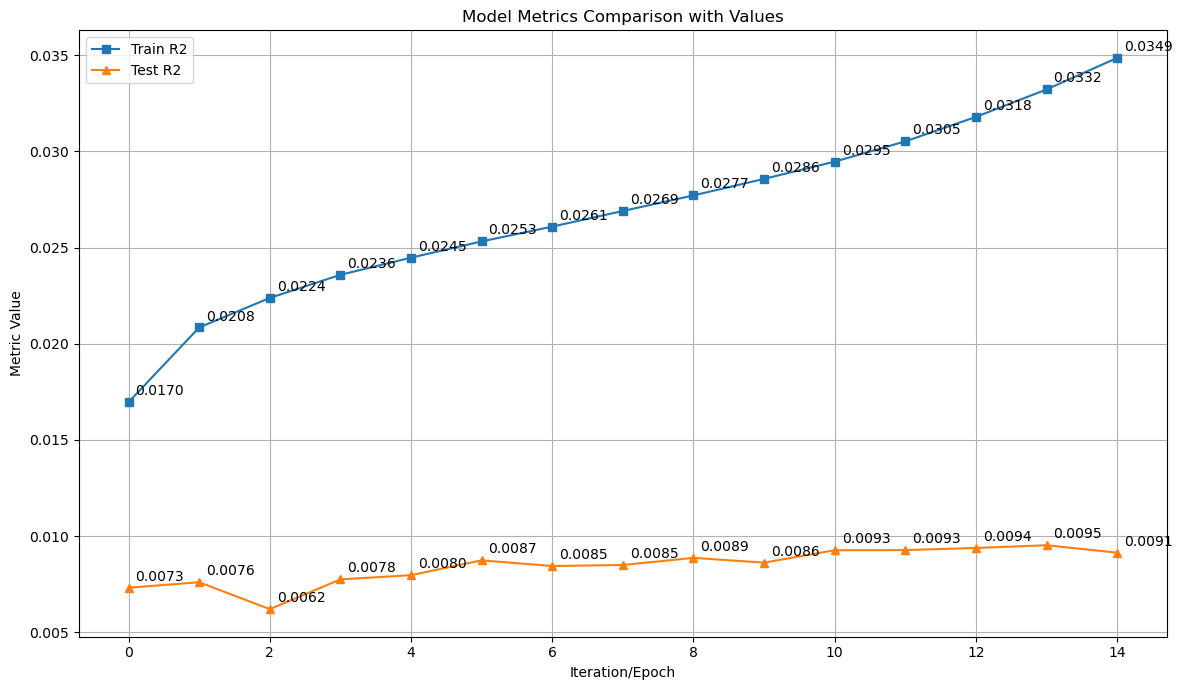

In [37]:
plt.figure(figsize=(12, 7))

plt.plot(result_dict2['train_r2'], label='Train R2', marker='s')
for i, val in enumerate(result_dict2['train_r2']):
    plt.annotate(f'{val:.4f}', (i, val), xytext=(5, 5), textcoords='offset points')

plt.plot(result_dict2['test_r2'], label='Test R2', marker='^')
for i, val in enumerate(result_dict2['test_r2']):
    plt.annotate(f'{val:.4f}', (i, val), xytext=(5, 5), textcoords='offset points')

plt.title('Model Metrics Comparison with Values')
plt.xlabel('Iteration/Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()